Data description:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

X2: Gender (1 = male; 2 = female).

X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

X4: Marital status (1 = married; 2 = single; 3 = others).

X5: Age (year).

X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 

X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;
X23 = amount paid in April, 2005.

# ML models pipeline

## Data Importing - Data cleaning

In [1]:
#import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score


In [2]:
from tensorflow.random import set_seed
from tensorflow.keras.utils import set_random_seed

In [3]:

# Seed value

seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)
# for later versions:
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

In [4]:
#Importing data
data = pd.read_excel('default of credit card clients.xls',header=1)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

All datapoints are in integer type

In [6]:
#checking for missing values
data.isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

No missing values

In [7]:
#checking the imbalance of the dataset
data['default payment next month'].value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

Imbalanced dataset:

22.12 % --> default

77.88 % --> non default


In [8]:
'''
Function for some initial preprocessing of the data:
1) replace EDUCATION values 0, 5, 6 with 4 ('other' category) since they are not mentioned in the data description
2) replace MARRIAGE value 0 with 3 ('other' category) as there is not a 0 category for marriage column on data description 
3) drop 'ID' column - useless
4) rename target column to DEFAULT, rename PAY_0 to PAY_1 for consistency and more accurate variable names
'''

def initial_preprocessing(df):
    
    print('EDUCATION values before preprocessing:\n',df['EDUCATION'].value_counts())
    df['EDUCATION'].replace([0,5,6],4,inplace=True)
    print('EDUCATION values after preprocessing:\n',df['EDUCATION'].value_counts())
    print('MARRIAGE values before preprocessing:\n',df['MARRIAGE'].value_counts())
    df['MARRIAGE'].replace(0,3,inplace=True)
    print('MARRIAGE values after preprocessing:\n',df['MARRIAGE'].value_counts())
    df.drop(columns='ID',inplace=True)
    df.rename(columns={"default payment next month": "DEFAULT","PAY_0": "PAY_1"},inplace=True)
    
    return df

    
    

In [9]:
data = initial_preprocessing(data)

EDUCATION values before preprocessing:
 2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64
EDUCATION values after preprocessing:
 2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64
MARRIAGE values before preprocessing:
 2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64
MARRIAGE values after preprocessing:
 2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64


## EDA

In [10]:
#functions for ploting boxplots and histograms of numerical columns - Useful to consider the right scaler 

def plot_boxplots(dataframe):
    num_columns = len(dataframe.columns)
    num_rows = (num_columns + 1) // 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 4 * num_rows))

    for i, column in enumerate(dataframe.columns):
        row = i // 2
        col = i % 2
        axes[row, col].boxplot(dataframe[column])
        axes[row, col].set_title(f'Boxplot of {column}')
        axes[row, col].set_xlabel(column)
        axes[row, col].set_ylabel('Values')
        axes[row, col].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
    

def plot_histograms(dataframe):
    num_columns = len(dataframe.columns)
    num_rows = (num_columns + 1) // 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 4 * num_rows))

    for i, column in enumerate(dataframe.columns):
        row = i // 2
        col = i % 2
        axes[row, col].hist(dataframe[column])
        axes[row, col].set_title(f'Histogram of {column}')
        axes[row, col].set_xlabel(column)
        axes[row, col].set_ylabel('Frequency')

    # Remove any unused subplots
    if num_columns % 2 != 0:
        fig.delaxes(axes[num_rows-1, 1])

    plt.tight_layout()
    plt.show()

In [11]:
#numerical columns
numerical_cols = ['LIMIT_BAL', 'AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

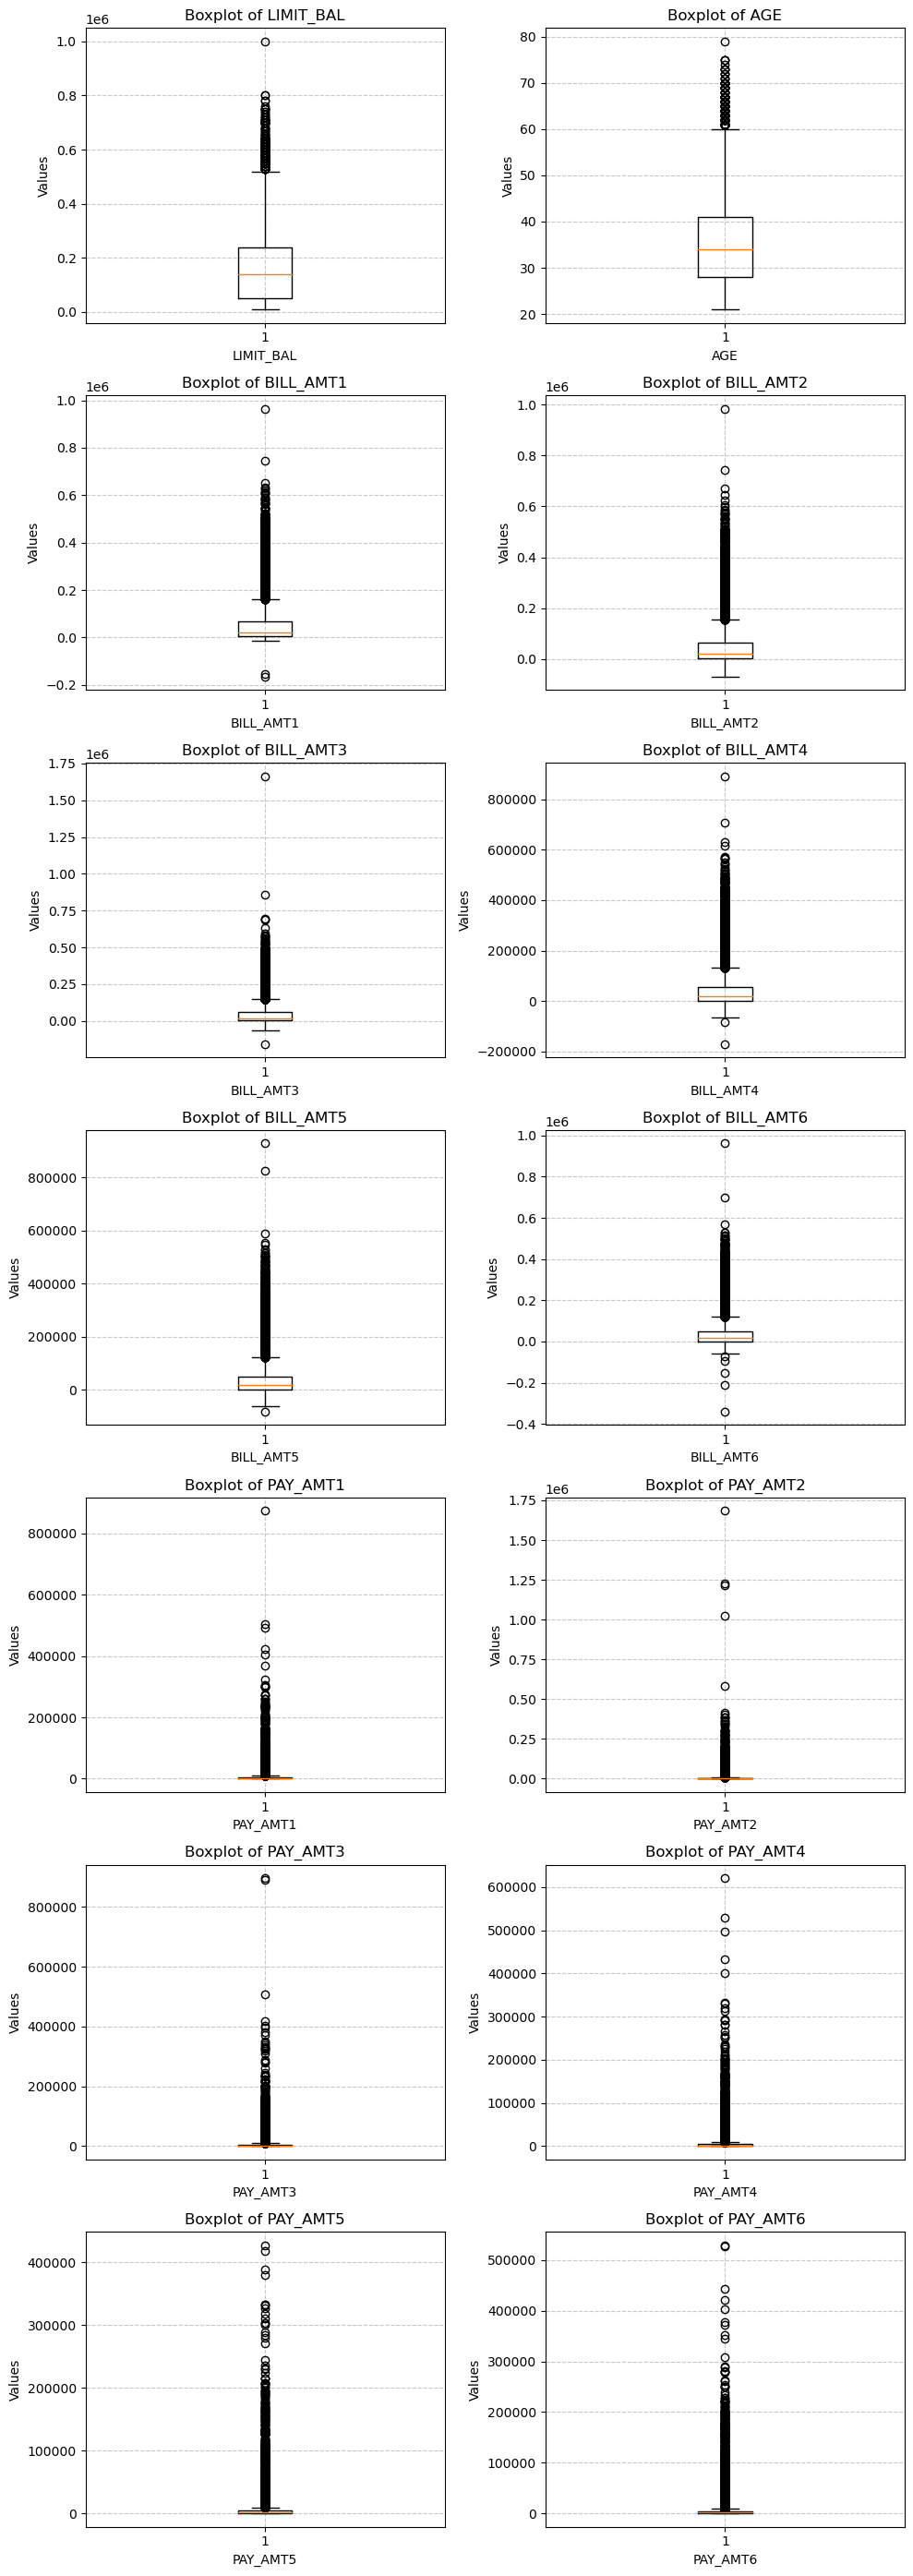

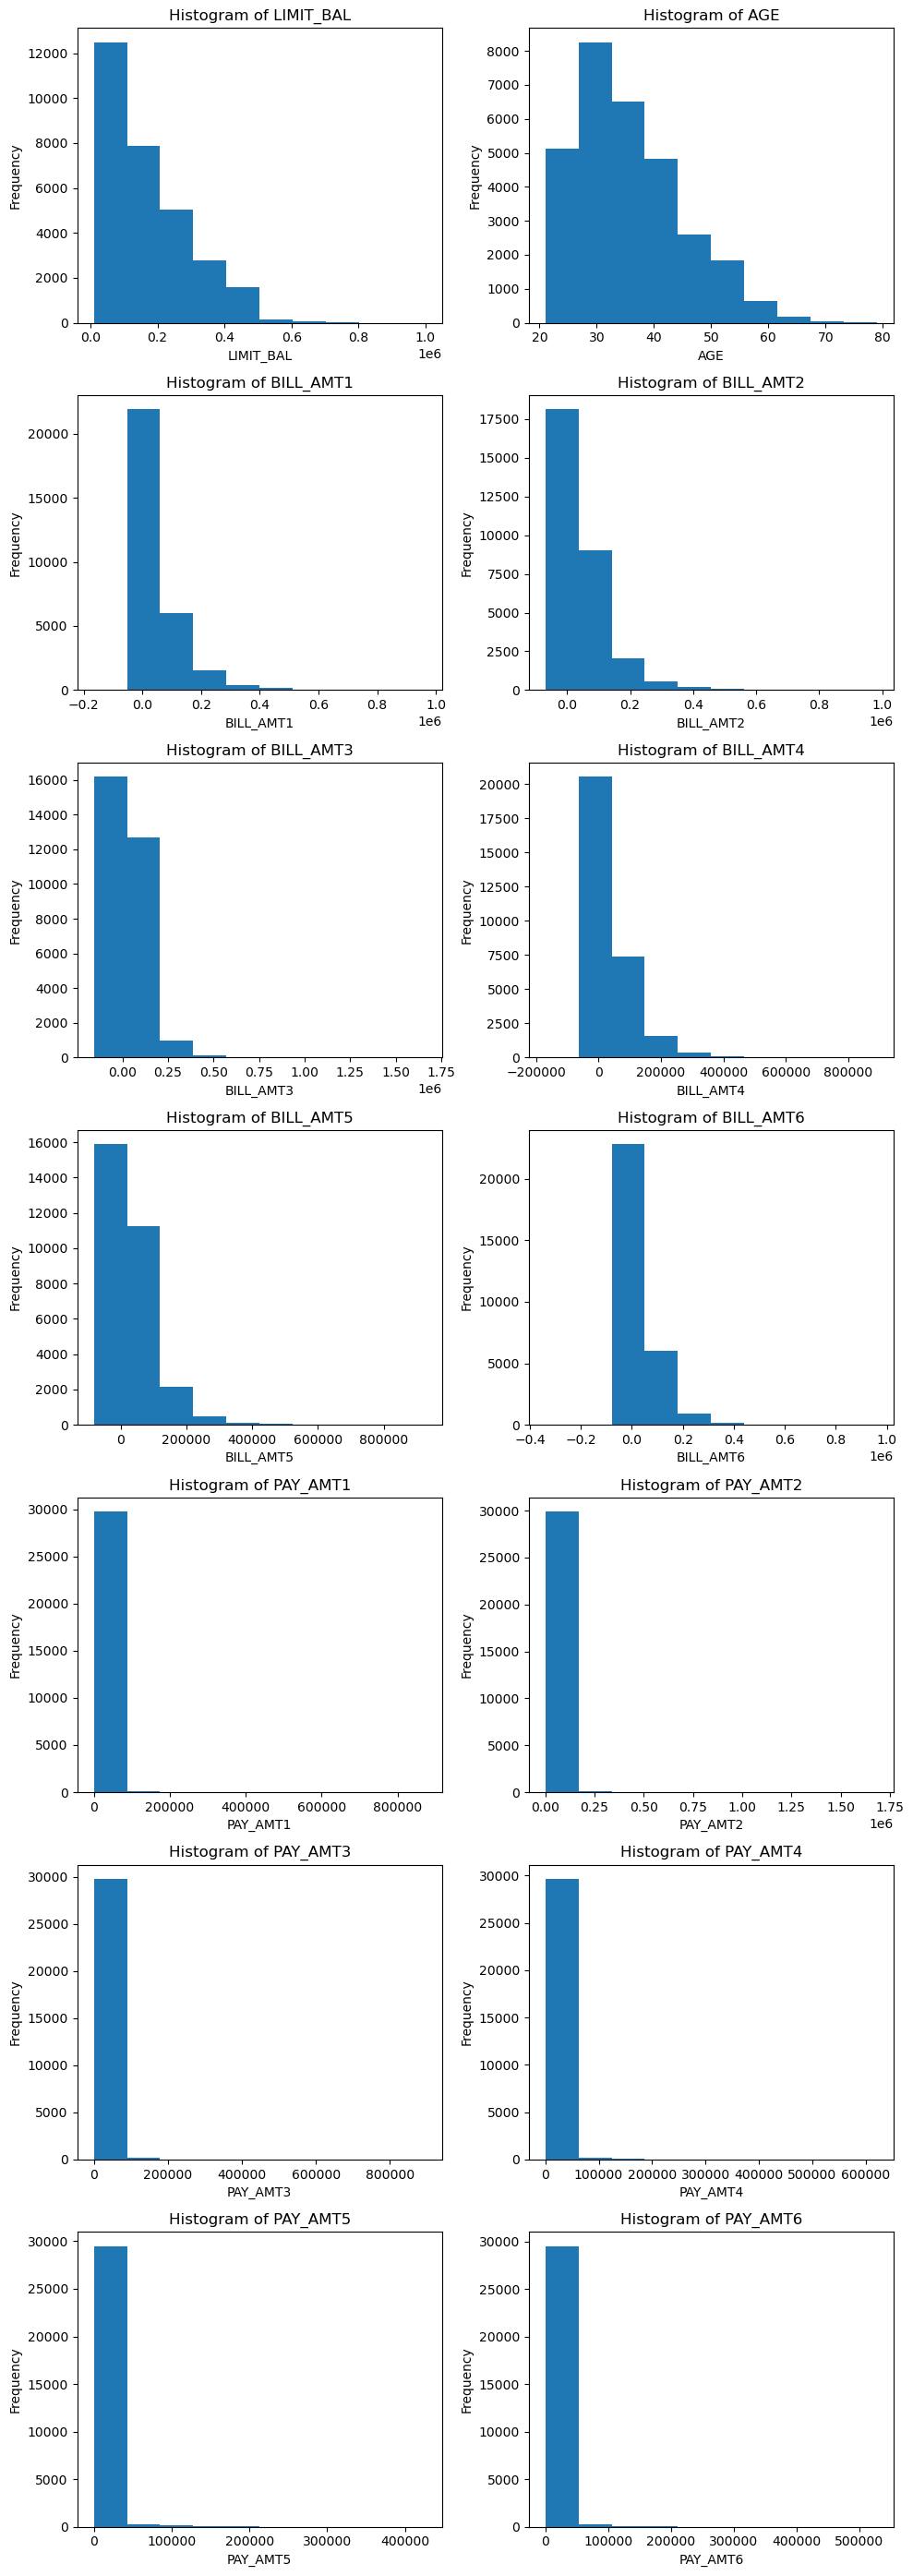

In [12]:
#boxplots and distributions of numerical columns
plot_boxplots(data[numerical_cols])
plot_histograms(data[numerical_cols])

Due to the presence of outliers and the highly skewed distributions, RobustScaler() will be used 

In [13]:
#Perform chi-square test to check the predictability of the variables PAY_1 - PAY_6 to the target variable - If it is high, then those categorical variables could one-hot-encoded

def chi2_test(data, categorical_vars, target_var):
    chi2_results = {}
    
    for var in categorical_vars:
        contingency_table = pd.crosstab(data[var], data[target_var])
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        chi2_results[var] = {'chi2': chi2, 'p_value': p_value}
    
    return chi2_results

In [14]:
chi2_test(data,['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'],'DEFAULT')

{'PAY_1': {'chi2': 5365.964977413581, 'p_value': 0.0},
 'PAY_2': {'chi2': 3474.4667904168564, 'p_value': 0.0},
 'PAY_3': {'chi2': 2622.4621276828025, 'p_value': 0.0},
 'PAY_4': {'chi2': 2341.469945438205, 'p_value': 0.0},
 'PAY_5': {'chi2': 2197.694900930992, 'p_value': 0.0},
 'PAY_6': {'chi2': 1886.835309001187, 'p_value': 0.0}}

The test shows that the predictability is high, so even if after one hot encoding the dimensionality increases a lot, it might be worth it.
EDUCATION and MARRIAGE will be one hot encoded too, in order for the models not to assume any natural ordering.

## Pipeline - Cross validation

In [15]:
'''
- train test split (10% test) before scaling and encoding to prevent data leakages 
- train set will be used for cross-validation/hyperparameter tuning and test set for final evaluation 
- Stratify is used to ensure that the proportion of the class labels will be the same as in the input dataset
'''
X_train, X_test, y_train, y_test = train_test_split(data.drop('DEFAULT',axis=1),data['DEFAULT'],test_size=0.2,stratify=data['DEFAULT'])
print('X_train shape:',X_train.shape)
print('X_test shape:',X_test.shape)

X_train shape: (24000, 23)
X_test shape: (6000, 23)


In [16]:
#Custom transformer for Robust Scaler and One Hot Encoder

class PreprocessorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns,columns_num, drop='first', handle_unknown='ignore',sparse_output=False):
        self.columns = columns
        self.columns_num = columns_num
        self.drop = drop
        self.handle_unknown = handle_unknown
        self.sparse_output = sparse_output
        self.encoders = {}
        self.robust_enc = {}
        

    def fit(self, X, y=None):
        for col in self.columns:
            encoder = OneHotEncoder(drop=self.drop, sparse_output=self.sparse_output, handle_unknown=self.handle_unknown)
            encoder.fit(X[[col]])
            self.encoders[col] = encoder
        
        for col_num in self.columns_num:
            encoder_robust = RobustScaler()
            encoder_robust.fit(X[[col_num]])
            self.robust_enc[col_num] = encoder_robust
            
        return self

    def transform(self, X):
        transformed = X.copy()
        for col in self.columns:
            encoder = self.encoders[col]
            encoded_cols = encoder.transform(transformed[[col]])
            new_cols = [f"{col}_{value}" for value in encoder.categories_[0][1:]]
            encoded_cols_df = pd.DataFrame(encoded_cols, columns=new_cols, index=transformed.index)
            transformed = pd.concat([transformed, encoded_cols_df], axis=1)
        transformed = transformed.drop(self.columns, axis=1)
        
        for col_num in self.columns_num:
            encoder_robust = self.robust_enc[col_num]
            transformed[col_num] = encoder_robust.transform(transformed[[col_num]])
            
        return transformed
    '''
    
    def inverse_transform(self,X):
        
        inv_transform = X.copy()
        for col in self.columns:            
            encoded_cols = inv_transform.filter(like=col)
            original_col = self.encoders[col].inverse_transform(encoded_cols)
            inv_transform[col] = original_col

        for col_num in inv_transform.columns:
            original_col = self.robust_enc[col_num].inverse_transform(inv_transform[[col_num]])
            inv_transform[col_num] = original_col
        
        return inv_transform
            
        '''
        
        

In [17]:
#construct the preprocessor to transform numeric and categorical columns
ohe_cols = ['EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2','PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

preprocessor = PreprocessorTransformer(columns = ohe_cols, columns_num= numerical_cols,drop='first',handle_unknown='ignore',sparse_output=False)

In [18]:
'''
construct a pipeline that applies the preprocessor and the sampling techniques

sampling techniques:
1) oversample the minority class till it's 40% percent of the majority class
2) undersample the majority class till it's 2 times larger than the minority class
'''

def run_cross_val(X, y, model, k_folds, repeats, sampling = False):
    
    if sampling == False:
        steps = [('preprocessor',preprocessor),('model',model)]
        pipeline = Pipeline(steps=steps)
        print(f'Cross validation scores without sampling techniques for {model}:\n')
    else:
        over = SMOTE(sampling_strategy=0.4)
        under = RandomUnderSampler(sampling_strategy=0.5)
        steps = [('preprocessor',preprocessor),('over',over),('under',under),('model',model)]
        pipeline = Pipeline(steps=steps)
        print(f'Cross validation scores with sampling techniques on train set for {model}:\n')
        
    cv = RepeatedStratifiedKFold(n_splits=k_folds, n_repeats=repeats)
    scores = cross_validate(pipeline, X, y, scoring=['accuracy','precision','recall','f1','roc_auc'], cv=cv, n_jobs=-1)

    print('Accuracy: %.3f (+/- %.3f)' % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))
    print('Precision: %.3f (+/- %.3f)' % (scores['test_precision'].mean(), scores['test_precision'].std()))
    print('Recall: %.3f (+/- %.3f)' % (scores['test_recall'].mean(), scores['test_recall'].std()))
    print('F1 Score: %.3f (+/- %.3f)' % (scores['test_f1'].mean(), scores['test_f1'].std()))
    print('AUC score: %.3f (+/- %.3f)' % (scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))

In [19]:
run_cross_val(X_train,y_train,model = LogisticRegression(),k_folds=10, repeats=2,sampling=False)
print('')
run_cross_val(X_train,y_train,model = LogisticRegression(),k_folds=10, repeats=2,sampling=True)

Cross validation scores without sampling techniques for LogisticRegression():

Accuracy: 0.821 (+/- 0.005)
Precision: 0.684 (+/- 0.025)
Recall: 0.358 (+/- 0.017)
F1 Score: 0.470 (+/- 0.016)
AUC score: 0.771 (+/- 0.012)

Cross validation scores with sampling techniques on train set for LogisticRegression():

Accuracy: 0.816 (+/- 0.004)
Precision: 0.621 (+/- 0.012)
Recall: 0.436 (+/- 0.020)
F1 Score: 0.512 (+/- 0.016)
AUC score: 0.770 (+/- 0.010)


In [21]:
run_cross_val(X_train,y_train,model = XGBClassifier(),k_folds=10, repeats=2,sampling=False)
print('')
run_cross_val(X_train,y_train,model = XGBClassifier(),k_folds=10, repeats=2,sampling=True)

Cross validation scores without sampling techniques for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...):



Accuracy: 0.815 (+/- 0.005)
Precision: 0.645 (+/- 0.021)
Recall: 0.361 (+/- 0.018)
F1 Score: 0.463 (+/- 0.018)
AUC score: 0.767 (+/- 0.012)

Cross validation scores with sampling techniques on train set for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...):

Accuracy: 0.806 (+/- 0.009)
Precision: 

In [22]:
run_cross_val(X_train,y_train,model = RandomForestClassifier(),k_folds=10, repeats=2,sampling=False)
print('')
run_cross_val(X_train,y_train,model = RandomForestClassifier(),k_folds=10, repeats=2,sampling=True)

Cross validation scores without sampling techniques for RandomForestClassifier():



Accuracy: 0.818 (+/- 0.004)
Precision: 0.657 (+/- 0.019)
Recall: 0.370 (+/- 0.015)
F1 Score: 0.473 (+/- 0.014)
AUC score: 0.765 (+/- 0.009)

Cross validation scores with sampling techniques on train set for RandomForestClassifier():

Accuracy: 0.812 (+/- 0.006)
Precision: 0.602 (+/- 0.020)
Recall: 0.448 (+/- 0.021)
F1 Score: 0.514 (+/- 0.019)
AUC score: 0.770 (+/- 0.011)


In [23]:
run_cross_val(X_train,y_train,model = SVC(),k_folds=10, repeats=2,sampling=False)
print('')
run_cross_val(X_train,y_train,model = SVC(),k_folds=10, repeats=2,sampling=True)

Cross validation scores without sampling techniques for SVC():



KeyboardInterrupt: 

## Hyperparameter Tuning

In [ ]:
def RandomSearch(X, y, model ,metric, k_folds, repeats,n_iter, param_grid, sampling = False):
    
    if sampling == False:
        steps = [('preprocessor',preprocessor),('model',model)]
        pipeline = Pipeline(steps=steps)
        print(f'RandomSearch without sampling techniques for {model}:\n')
        
    else:
        over = SMOTE(sampling_strategy=0.4)
        under = RandomUnderSampler(sampling_strategy=0.5)
        steps = [('preprocessor',preprocessor),('over',over),('under',under),('model',model)]
        pipeline = Pipeline(steps=steps)
        print(f'RandomSearch with sampling techniques on train set for {model}:\n')
       
    cv = RepeatedStratifiedKFold(n_splits=k_folds, n_repeats=repeats)
    rs = RandomizedSearchCV(pipeline, param_grid, n_iter = n_iter , cv = cv, scoring = metric, n_jobs = -1)
    rs.fit(X, y)
    random_search_CV_results = pd.DataFrame(rs.cv_results_)
    print('RandomSearch Results:',random_search_CV_results)
    print('Best parameters found:', rs.best_params_)
    print('Best score:', rs.best_score_)
    
    return rs.best_params_

In [ ]:
LR_grid = {
'model__solver' : ['newton-cg', 'lbfgs', 'liblinear']
'model__penalty' : ['none', 'l1', 'l2', 'elasticnet']
'model__C' : [0.001,0.01,0.1,1,10,100]

}

LR_best_params = RandomSearch(X_train, y_train, LogisticRegression(),'roc_auc', k_folds=10, repeats=2,n_iter=10, param_grid=LR_grid ,sampling=False)
LR_best_params_sampling = RandomSearch(X_train, y_train, LogisticRegression(),'roc_auc', k_folds=10, repeats=2,n_iter=10,param_grid=LR_grid ,sampling=True)

RandomSearch without sampling techniques for LogisticRegression():



c:\Users\diama\anaconda3\envs\spyder\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\diama\anaconda3\envs\spyder\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\diama\anaconda3\envs\spyder\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\diama\anaconda3\envs\spyder\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
  

RandomSearch Results:    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.222612      0.049089         0.000000        0.000000   
1       6.581776      0.744679         0.044733        0.012462   
2       0.170793      0.017750         0.000000        0.000000   
3       0.180497      0.021287         0.000000        0.000000   
4       0.892033      0.048926         0.039974        0.008867   
5       0.184732      0.022035         0.000000        0.000000   
6      22.829030      1.973307         0.041066        0.022872   
7       0.190431      0.023099         0.000000        0.000000   
8      10.755777      2.444533         0.033922        0.024367   
9       0.192365      0.019082         0.000000        0.000000   

  param_model__solver param_model__penalty param_model__C  \
0           liblinear                 none          0.001   
1           liblinear                   l2             10   
2           newton-cg           elasticnet            0.1

c:\Users\diama\anaconda3\envs\spyder\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
80 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\diama\anaconda3\envs\spyder\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\diama\anaconda3\envs\spyder\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\diama\anaconda3\envs\spyder\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
   

RandomSearch Results:    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.823660      0.264283         0.062784        0.018402   
1       4.676059      0.802418         0.056664        0.025433   
2       1.054739      0.131701         0.000000        0.000000   
3     206.183755     20.207049         0.035586        0.009466   
4     172.143941     42.870412         0.025637        0.014022   
5       1.013774      0.076767         0.000000        0.000000   
6       1.105322      0.100596         0.000000        0.000000   
7       1.033013      0.118016         0.000000        0.000000   
8       3.519945      0.300878         0.030860        0.007399   
9       3.476612      0.514487         0.027676        0.005579   

  param_model__solver param_model__penalty param_model__C  \
0           liblinear                   l2           0.01   
1           liblinear                   l2             10   
2           newton-cg                   l1           0.01

c:\Users\diama\anaconda3\envs\spyder\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [752]:
XGB_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.1, 0.01, 0.001],
    'model__gamma': [0, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

XGB_best_params = RandomSearch(X_train, y_train, XGBClassifier(),'roc_auc', k_folds=10, repeats=2,n_iter=10, param_grid=XGB_grid ,sampling=False)
XGB_best_params_sampling = RandomSearch(X_train, y_train, XGBClassifier(),'roc_auc', k_folds=10, repeats=2,n_iter=10,param_grid=XGB_grid ,sampling=True)

RandomSearch without sampling techniques for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...):

RandomSearch Results:    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       9.590998      0.205400         0.047482        0.005826   
1      35.978711      2.016939         0.0908

In [267]:
RF_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt']
}

RF_best_params = RandomSearch(X_train, y_train, RandomForestClassifier(),'roc_auc', k_folds=10, repeats=2,n_iter=10, param_grid=RF_grid ,sampling=False)
RF_best_params_sampling = RandomSearch(X_train, y_train, RandomForestClassifier(),'roc_auc', k_folds=10, repeats=2,n_iter=10,param_grid=RF_grid ,sampling=True)

GridSearch without sampling techniques for RandomForestClassifier():



c:\Users\diama\anaconda3\envs\spyder\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearch Results:     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       15.578735      0.390449         0.152424        0.013395   
1        7.680143      0.275204         0.078007        0.007623   
2        7.592965      0.224935         0.078120        0.007174   
3       31.910376      0.646665         0.334619        0.050877   
4       15.025691      1.062756         0.141671        0.011294   
5       15.337648      0.618228         0.144502        0.013590   
6       22.077513      0.562330         0.224229        0.033817   
7       19.857924      0.351633         0.196212        0.010552   
8       34.740372      0.711347         0.355271        0.024499   
9        4.581603      0.292178         0.060828        0.003251   
10       7.669704      0.177720         0.076334        0.005980   
11      14.907658      0.311095         0.131066        0.010878   
12      30.226346      0.570788         0.297672        0.017012   
13       9.555153      0.731

In [753]:
SVC_grid = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': [0.1, 0.01, 0.001]
}

SVC_best_params = RunGridSearch(X_train, y_train, SVC(),'roc_auc', k_folds=10, repeats=2,n_iter=10, param_grid=SVC_grid ,sampling=False)
SVC_best_params_sampling = RunGridSearch(X_train, y_train, SVC(),'roc_auc', k_folds=10, repeats=2,n_iter=10,param_grid=SVC_grid ,sampling=True)

GridSearch without sampling techniques for SVC():



In [748]:
run_cross_val(X_train,y_train,model = LogisticRegression(solver=LR_best_params['model__solver'],penalty=LR_best_params['model__penalty'], C=LR_best_params['model__C']),k_folds=10, repeats=2,sampling=False)
print('')
run_cross_val(X_train,y_train,model = LogisticRegression(solver=LR_best_params_sampling['model__solver'],penalty=LR_best_params_sampling['model__penalty'], C=LR_best_params_sampling['model__C']),k_folds=10, repeats=2,sampling=True)

Cross validation scores without sampling techniques for LogisticRegression(C=10, solver='newton-cg'):

Accuracy: 0.821 (+/- 0.006)
Precision: 0.680 (+/- 0.026)
Recall: 0.358 (+/- 0.023)
F1 Score: 0.468 (+/- 0.024)
AUC score: 0.767 (+/- 0.011)

Cross validation scores with sampling techniques on train set for LogisticRegression(C=0.001, penalty='none'):

Accuracy: 0.817 (+/- 0.006)
Precision: 0.624 (+/- 0.019)
Recall: 0.433 (+/- 0.021)
F1 Score: 0.511 (+/- 0.019)
AUC score: 0.767 (+/- 0.012)


In [266]:
run_cross_val(X_train,y_train,model = XGBClassifier(n_estimators = XGB_best_params['model__n_estimators'],max_depth = XGB_best_params['model__max_depth'],learning_rate=XGB_best_params['model__learning_rate']
                                                    ,gamma = XGB_best_params['model__gamma'], subsample = XGB_best_params['model__subsample'],colsample_bytree=XGB_best_params['model__colsample_bytree']),k_folds=10, repeats=3,sampling=False)
print('')
run_cross_val(X_train,y_train,model = XGBClassifier(n_estimators = XGB_best_params_sampling['model__n_estimators'],max_depth = XGB_best_params_sampling['model__max_depth'],learning_rate=XGB_best_params_sampling['model__learning_rate']
                                                    ,gamma = XGB_best_params_sampling['model__gamma'], subsample = XGB_best_params_sampling['model__subsample'],colsample_bytree=XGB_best_params_sampling['model__colsample_bytree']),k_folds=10, repeats=3,sampling=True)

Cross validation scores without sampling techniques for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...):

Accuracy: 0.821 (+/- 0.005)
Precision: 0.684 (+/- 0.022)
Recall: 0.351 (+/- 0.020)
F1 Score: 0.464 (+/- 0.021)
AUC score: 0.783 (+/- 0.011)

Cross validation scores with sampling techniques on tr

# DL models pipeline

## Cross validation - temporal only

In [20]:
# 5-fold cross-validation
n_splits = 5 
kf = KFold(n_splits=n_splits)

In [21]:
cat_cols = ['EDUCATION','MARRIAGE'] #categorical colums that are goind to be one hot encoded
enc_dl = PreprocessorTransformer(columns = cat_cols, columns_num= numerical_cols,drop='first',handle_unknown='ignore',sparse_output=False) #preprocessor for the dl pipeline

### LSTM 

In [22]:
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import LearningRateScheduler


------------------------------------------------------------------------
Training for fold 1
Epoch 1/55
281/281 [==============================] - 3s 6ms/step - loss: 0.6768 - accuracy: 0.6490 - val_loss: 0.6418 - val_accuracy: 0.7869 - lr: 1.0000e-04
Epoch 2/55
281/281 [==============================] - 1s 4ms/step - loss: 0.6429 - accuracy: 0.7241 - val_loss: 0.6039 - val_accuracy: 0.7852 - lr: 1.0000e-04
Epoch 3/55
281/281 [==============================] - 1s 4ms/step - loss: 0.6178 - accuracy: 0.7252 - val_loss: 0.5752 - val_accuracy: 0.7831 - lr: 1.0000e-04
Epoch 4/55
281/281 [==============================] - 1s 4ms/step - loss: 0.6008 - accuracy: 0.7242 - val_loss: 0.5564 - val_accuracy: 0.7825 - lr: 1.0000e-04
Epoch 5/55
281/281 [==============================] - 1s 4ms/step - loss: 0.5900 - accuracy: 0.7255 - val_loss: 0.5446 - val_accuracy: 0.7833 - lr: 1.0000e-04
Epoch 6/55
281/281 [==============================] - 1s 4ms/step - loss: 0.5830 - accuracy: 0.7261 - val_loss: 

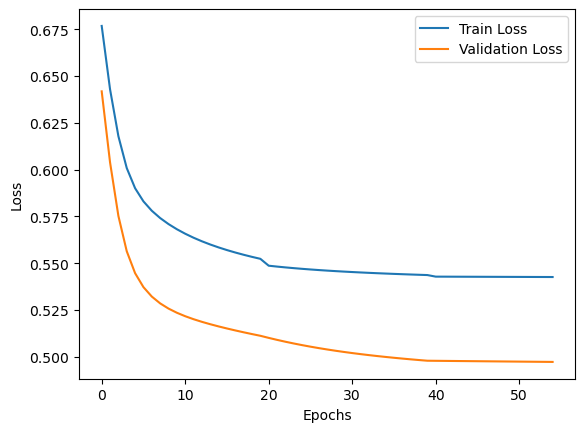

150/150 [==============================] - 1s 1ms/step
------------------------------------------------------------------------
Training for fold 2
Epoch 1/55
281/281 [==============================] - 3s 6ms/step - loss: 0.7246 - accuracy: 0.4073 - val_loss: 0.6957 - val_accuracy: 0.4973 - lr: 1.0000e-04
Epoch 2/55
281/281 [==============================] - 1s 5ms/step - loss: 0.6818 - accuracy: 0.6028 - val_loss: 0.6474 - val_accuracy: 0.7315 - lr: 1.0000e-04
Epoch 3/55
281/281 [==============================] - 1s 4ms/step - loss: 0.6490 - accuracy: 0.7059 - val_loss: 0.6073 - val_accuracy: 0.7788 - lr: 1.0000e-04
Epoch 4/55
281/281 [==============================] - 1s 4ms/step - loss: 0.6244 - accuracy: 0.7166 - val_loss: 0.5773 - val_accuracy: 0.7817 - lr: 1.0000e-04
Epoch 5/55
281/281 [==============================] - 1s 4ms/step - loss: 0.6076 - accuracy: 0.7178 - val_loss: 0.5573 - val_accuracy: 0.7833 - lr: 1.0000e-04
Epoch 6/55
281/281 [==============================] - 1s 

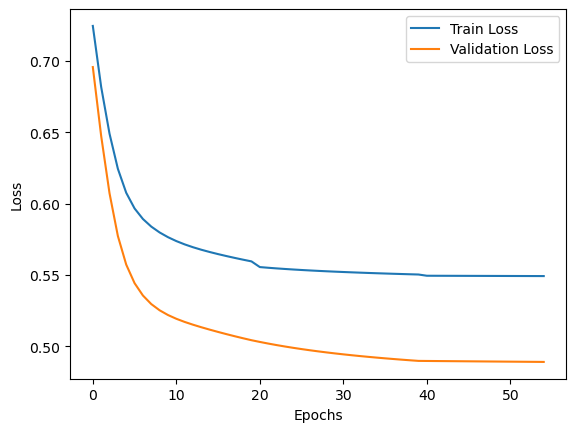

150/150 [==============================] - 1s 2ms/step
------------------------------------------------------------------------
Training for fold 3
Epoch 1/55
280/280 [==============================] - 3s 5ms/step - loss: 0.6889 - accuracy: 0.5564 - val_loss: 0.6574 - val_accuracy: 0.7665 - lr: 1.0000e-04
Epoch 2/55
280/280 [==============================] - 1s 4ms/step - loss: 0.6544 - accuracy: 0.7189 - val_loss: 0.6202 - val_accuracy: 0.7940 - lr: 1.0000e-04
Epoch 3/55
280/280 [==============================] - 1s 4ms/step - loss: 0.6284 - accuracy: 0.7282 - val_loss: 0.5875 - val_accuracy: 0.7896 - lr: 1.0000e-04
Epoch 4/55
280/280 [==============================] - 1s 4ms/step - loss: 0.6085 - accuracy: 0.7285 - val_loss: 0.5626 - val_accuracy: 0.7894 - lr: 1.0000e-04
Epoch 5/55
280/280 [==============================] - 1s 4ms/step - loss: 0.5953 - accuracy: 0.7284 - val_loss: 0.5464 - val_accuracy: 0.7896 - lr: 1.0000e-04
Epoch 6/55
280/280 [==============================] - 1s 

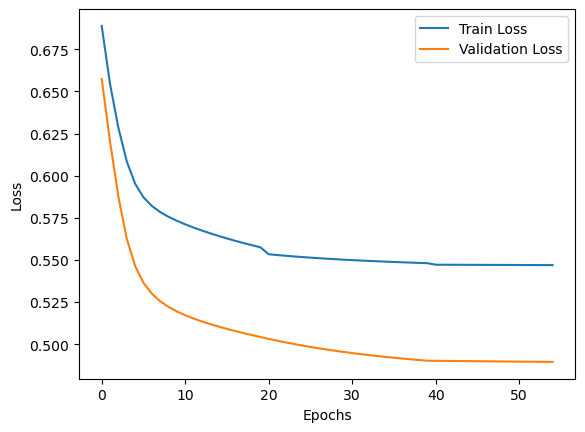

150/150 [==============================] - 1s 1ms/step
------------------------------------------------------------------------
Training for fold 4
Epoch 1/55
280/280 [==============================] - 3s 5ms/step - loss: 0.6791 - accuracy: 0.6413 - val_loss: 0.6359 - val_accuracy: 0.7594 - lr: 1.0000e-04
Epoch 2/55
280/280 [==============================] - 1s 4ms/step - loss: 0.6402 - accuracy: 0.7157 - val_loss: 0.5926 - val_accuracy: 0.7790 - lr: 1.0000e-04
Epoch 3/55
280/280 [==============================] - 1s 4ms/step - loss: 0.6149 - accuracy: 0.7181 - val_loss: 0.5649 - val_accuracy: 0.7785 - lr: 1.0000e-04
Epoch 4/55
280/280 [==============================] - 1s 4ms/step - loss: 0.6000 - accuracy: 0.7193 - val_loss: 0.5488 - val_accuracy: 0.7794 - lr: 1.0000e-04
Epoch 5/55
280/280 [==============================] - 1s 4ms/step - loss: 0.5914 - accuracy: 0.7203 - val_loss: 0.5392 - val_accuracy: 0.7821 - lr: 1.0000e-04
Epoch 6/55
280/280 [==============================] - 1s 

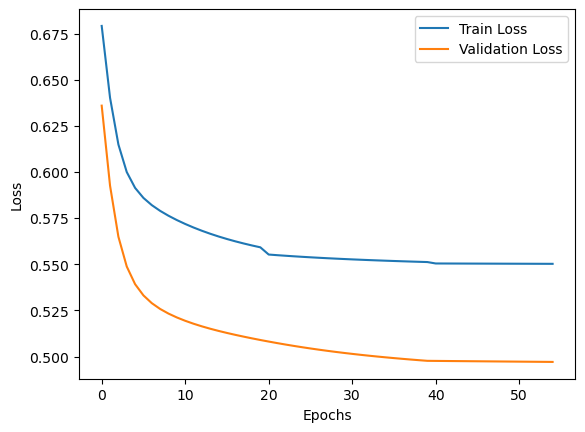

150/150 [==============================] - 1s 1ms/step
------------------------------------------------------------------------
Training for fold 5
Epoch 1/55
282/282 [==============================] - 3s 5ms/step - loss: 0.6588 - accuracy: 0.6952 - val_loss: 0.6198 - val_accuracy: 0.7608 - lr: 1.0000e-04
Epoch 2/55
282/282 [==============================] - 1s 4ms/step - loss: 0.6274 - accuracy: 0.7167 - val_loss: 0.5878 - val_accuracy: 0.7606 - lr: 1.0000e-04
Epoch 3/55
282/282 [==============================] - 1s 4ms/step - loss: 0.6086 - accuracy: 0.7175 - val_loss: 0.5674 - val_accuracy: 0.7650 - lr: 1.0000e-04
Epoch 4/55
282/282 [==============================] - 1s 4ms/step - loss: 0.5975 - accuracy: 0.7200 - val_loss: 0.5554 - val_accuracy: 0.7681 - lr: 1.0000e-04
Epoch 5/55
282/282 [==============================] - 1s 4ms/step - loss: 0.5909 - accuracy: 0.7214 - val_loss: 0.5479 - val_accuracy: 0.7698 - lr: 1.0000e-04
Epoch 6/55
282/282 [==============================] - 1s 

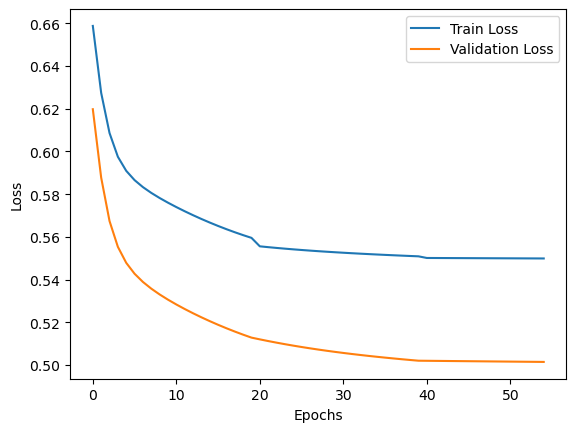

150/150 [==============================] - 1s 2ms/step
Accuracy: 0.796 (+/- 0.006)
Precision: 0.556 (+/- 0.022)
Recall: 0.399 (+/- 0.015)
F1 score: 0.464 (+/- 0.014)
AUC score: 0.654 (+/- 0.007)


In [50]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
AUC_scores = []

fold_no = 1
for train_index, test_index in kf.split(X_train, y_train):
    X_train_dl, X_test_dl = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_dl, y_test_dl = y_train.iloc[train_index], y_train.iloc[test_index]

    # Perform preprocessing steps on X_train_dl
    X_train_dl_preprocessed = enc_dl.fit_transform(X_train_dl)
    X_test_dl_preprocessed = enc_dl.transform(X_test_dl)

    # Apply SMOTE and undersampling to address class imbalance
    over = SMOTE(sampling_strategy=0.4, random_state=42)
    under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
    steps = [('o',over),('u',under)]
    pipe = Pipeline(steps=steps)
        
    X_train_dl_resampled, y_train_dl_resampled =  pipe.fit_resample(X_train_dl_preprocessed, y_train_dl)
    
    round_cols = ['SEX','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6'] + X_train_dl_resampled.filter(like='EDUCATION').columns.to_list() + X_train_dl_resampled.filter(like='MARRIAGE').columns.to_list() 
    for col in round_cols:
        X_train_dl_resampled[col] = X_train_dl_resampled[col].round()
    
    # Split training data into static and temporal features
    # Perform any necessary reshaping or transformations
    temp_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
    'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
    'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
    'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    static_cols_train = X_train_dl_resampled.drop(temp_cols,axis=1).columns.to_list()
    static_cols_test = X_test_dl_preprocessed.drop(temp_cols,axis=1).columns.to_list()
    
    X_train_dl_temp = X_train_dl_resampled[temp_cols]
    X_train_dl_static = X_train_dl_resampled[static_cols_train]
    X_test_dl_temp = X_test_dl_preprocessed[temp_cols]
    X_test_dl_static = X_test_dl_preprocessed[static_cols_test]

    PAY_cols = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2','PAY_1']
    BILL_AMT_cols = ['BILL_AMT6','BILL_AMT5','BILL_AMT4','BILL_AMT3','BILL_AMT2','BILL_AMT1']
    PAY_AMT_cols = ['PAY_AMT6','PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
    
    PAY_train_dl = X_train_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_train_dl = X_train_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_train_dl = X_train_dl_temp[PAY_AMT_cols].to_numpy()
    
    PAY_test_dl = X_test_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_test_dl = X_test_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_test_dl = X_test_dl_temp[PAY_AMT_cols].to_numpy()   
    
    # Stack temporal features
    stacked_train = np.dstack((PAY_train_dl,BILL_AMT_train_dl,PAY_AMT_train_dl))
    stacked_test = np.dstack((PAY_test_dl,BILL_AMT_test_dl,PAY_AMT_test_dl))
    y_train_dl_resampled = y_train_dl_resampled.to_numpy()
    y_test_dl = y_test_dl.to_numpy()

    # Build and compile LSTM model
    num_time_steps, num_features = stacked_train.shape[1], stacked_train.shape[2]

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(16,return_sequences=True, input_shape=(num_time_steps, num_features)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    initial_learning_rate = 0.0001  # Initial learning rate
    decay_rate = 0.1  # Decay rate
    decay_steps = 20  # Decay steps (number of steps before applying decay)
    epochs = 55

    def learning_rate_scheduler(epoch):
        return initial_learning_rate * decay_rate ** (epoch // decay_steps)
    
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=initial_learning_rate), metrics=['accuracy'])
    
    lr_scheduler = LearningRateScheduler(learning_rate_scheduler)
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no}')
 
    # Train the model
    batch_size = 64
    
    # Train the model
    history = model.fit(stacked_train, y_train_dl_resampled, epochs=epochs, batch_size=batch_size, validation_data=(stacked_test, y_test_dl),shuffle=False,callbacks=[lr_scheduler])
    
    # Plot the loss on train vs validate tests
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    y_pred_probs = model.predict(stacked_test)
    y_pred = (y_pred_probs>=0.5).astype(int)    
    
    accuracy =  accuracy_score(y_test_dl,y_pred)
    precision = precision_score(y_test_dl,y_pred)
    recall = recall_score(y_test_dl,y_pred)
    f1 =  f1_score(y_test_dl,y_pred)
    AUC = roc_auc_score(y_test_dl,y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    AUC_scores.append(AUC)
    
    fold_no = fold_no + 1


# Calculate the average and standard deviation of the evaluation metrics
print('Accuracy: %.3f (+/- %.3f)' % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print('Precision: %.3f (+/- %.3f)' % (np.mean(precision_scores), np.std(precision_scores)))
print('Recall: %.3f (+/- %.3f)' % (np.mean(recall_scores), np.std(recall_scores)))
print('F1 score: %.3f (+/- %.3f)' % (np.mean(f1_scores), np.std(f1_scores)))
print('AUC score: %.3f (+/- %.3f)' % (np.mean(AUC_scores), np.std(AUC_scores)))

Accuracy: 0.807 (+/- 0.003)
Precision: 0.578 (+/- 0.015)
Recall: 0.469 (+/- 0.015)
F1 score: 0.518 (+/- 0.012)
AUC score: 0.686 (+/- 0.007)

### LSTM ARCH 2

In [ ]:
from keras.optimizers import Adamax

------------------------------------------------------------------------
Training for fold 1
Epoch 1/55
947/947 [==============================] - 6s 4ms/step - loss: 0.5207 - accuracy: 0.7542 - val_loss: 1.3665 - val_accuracy: 0.2217 - lr: 0.0010
Epoch 2/55
947/947 [==============================] - 4s 4ms/step - loss: 0.5240 - accuracy: 0.7424 - val_loss: 1.6727 - val_accuracy: 0.2217 - lr: 0.0010
Epoch 3/55
947/947 [==============================] - 4s 4ms/step - loss: 0.5072 - accuracy: 0.7624 - val_loss: 1.7900 - val_accuracy: 0.2217 - lr: 0.0010
Epoch 4/55
947/947 [==============================] - 4s 4ms/step - loss: 0.4868 - accuracy: 0.7795 - val_loss: 1.8941 - val_accuracy: 0.2217 - lr: 0.0010
Epoch 5/55
947/947 [==============================] - 4s 4ms/step - loss: 0.4732 - accuracy: 0.7884 - val_loss: 2.0027 - val_accuracy: 0.2217 - lr: 0.0010
Epoch 6/55
947/947 [==============================] - 4s 4ms/step - loss: 0.4632 - accuracy: 0.7958 - val_loss: 2.1166 - val_accurac

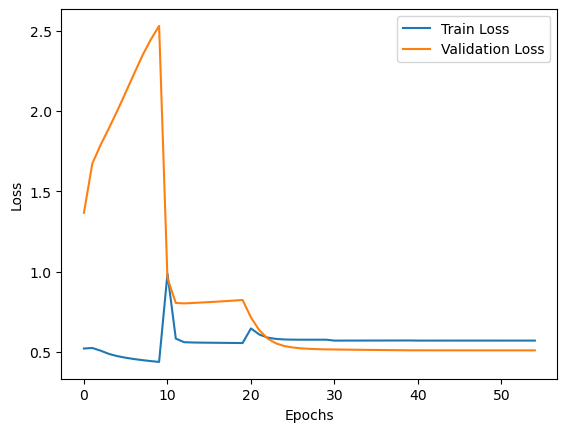

169/169 [==============================] - 1s 2ms/step
------------------------------------------------------------------------
Training for fold 2
Epoch 1/55
945/945 [==============================] - 5s 4ms/step - loss: 0.5289 - accuracy: 0.7415 - val_loss: 1.2414 - val_accuracy: 0.2374 - lr: 0.0010
Epoch 2/55
945/945 [==============================] - 3s 4ms/step - loss: 0.5269 - accuracy: 0.7358 - val_loss: 1.8069 - val_accuracy: 0.2169 - lr: 0.0010
Epoch 3/55
945/945 [==============================] - 4s 4ms/step - loss: 0.5248 - accuracy: 0.7476 - val_loss: 1.9486 - val_accuracy: 0.2169 - lr: 0.0010
Epoch 4/55
945/945 [==============================] - 4s 4ms/step - loss: 0.5027 - accuracy: 0.7685 - val_loss: 2.0907 - val_accuracy: 0.2169 - lr: 0.0010
Epoch 5/55
945/945 [==============================] - 4s 4ms/step - loss: 0.4899 - accuracy: 0.7798 - val_loss: 2.1889 - val_accuracy: 0.2169 - lr: 0.0010
Epoch 6/55
945/945 [==============================] - 4s 4ms/step - loss: 0.4

KeyboardInterrupt: 

In [ ]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
AUC_scores = []

fold_no = 1
for train_index, test_index in kf.split(X_train, y_train):
    X_train_dl, X_test_dl = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_dl, y_test_dl = y_train.iloc[train_index], y_train.iloc[test_index]

    # Perform preprocessing steps on X_train_dl
    X_train_dl_preprocessed = enc_dl.fit_transform(X_train_dl)
    X_test_dl_preprocessed = enc_dl.transform(X_test_dl)

    # Apply SMOTE and undersampling to address class imbalance
    over = SMOTE(sampling_strategy=0.8, random_state=42)
    #under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
    steps = [('o',over)]
    pipe = Pipeline(steps=steps)
        
    X_train_dl_resampled, y_train_dl_resampled =  pipe.fit_resample(X_train_dl_preprocessed, y_train_dl)
    
    round_cols = ['SEX','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6'] + X_train_dl_resampled.filter(like='EDUCATION').columns.to_list() + X_train_dl_resampled.filter(like='MARRIAGE').columns.to_list() 
    for col in round_cols:
        X_train_dl_resampled[col] = X_train_dl_resampled[col].round()
    
    # Split training data into static and temporal features
    # Perform any necessary reshaping or transformations
    temp_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
    'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
    'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
    'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    static_cols_train = X_train_dl_resampled.drop(temp_cols,axis=1).columns.to_list()
    static_cols_test = X_test_dl_preprocessed.drop(temp_cols,axis=1).columns.to_list()
    
    X_train_dl_temp = X_train_dl_resampled[temp_cols]
    X_train_dl_static = X_train_dl_resampled[static_cols_train]
    X_test_dl_temp = X_test_dl_preprocessed[temp_cols]
    X_test_dl_static = X_test_dl_preprocessed[static_cols_test]

    PAY_cols = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2','PAY_1']
    BILL_AMT_cols = ['BILL_AMT6','BILL_AMT5','BILL_AMT4','BILL_AMT3','BILL_AMT2','BILL_AMT1']
    PAY_AMT_cols = ['PAY_AMT6','PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
    
    PAY_train_dl = X_train_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_train_dl = X_train_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_train_dl = X_train_dl_temp[PAY_AMT_cols].to_numpy()
    
    PAY_test_dl = X_test_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_test_dl = X_test_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_test_dl = X_test_dl_temp[PAY_AMT_cols].to_numpy()   
    
    # Stack temporal features
    stacked_train = np.dstack((PAY_train_dl,BILL_AMT_train_dl,PAY_AMT_train_dl))
    stacked_test = np.dstack((PAY_test_dl,BILL_AMT_test_dl,PAY_AMT_test_dl))
    y_train_dl_resampled = y_train_dl_resampled.to_numpy()
    y_test_dl = y_test_dl.to_numpy()

    # Build and compile LSTM model
    num_time_steps, num_features = stacked_train.shape[1], stacked_train.shape[2]

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(16,return_sequences=True, input_shape=(num_time_steps, num_features)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    initial_learning_rate = 0.001  # Initial learning rate
    decay_rate = 0.1  # Decay rate
    decay_steps = 10  # Decay steps (number of steps before applying decay)
    epochs = 55

    def learning_rate_scheduler(epoch):
        return initial_learning_rate * decay_rate ** (epoch // decay_steps)
    
    
    model.compile(loss='binary_crossentropy', optimizer=Adamax(learning_rate=initial_learning_rate), metrics=['accuracy'])
    
    lr_scheduler = LearningRateScheduler(learning_rate_scheduler)
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no}')
 
    # Train the model
    batch_size = 32
    
    # Train the model
    history = model.fit(stacked_train, y_train_dl_resampled, epochs=epochs, batch_size=batch_size, validation_data=(stacked_test, y_test_dl),shuffle=False,callbacks=[lr_scheduler])
    
    # Plot the loss on train vs validate tests
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    y_pred_probs = model.predict(stacked_test)
    y_pred = (y_pred_probs>=0.5).astype(int)    
    
    accuracy =  accuracy_score(y_test_dl,y_pred)
    precision = precision_score(y_test_dl,y_pred)
    recall = recall_score(y_test_dl,y_pred)
    f1 =  f1_score(y_test_dl,y_pred)
    AUC = roc_auc_score(y_test_dl,y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    AUC_scores.append(AUC)
    
    fold_no = fold_no + 1


# Calculate the average and standard deviation of the evaluation metrics
print('Accuracy: %.3f (+/- %.3f)' % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print('Precision: %.3f (+/- %.3f)' % (np.mean(precision_scores), np.std(precision_scores)))
print('Recall: %.3f (+/- %.3f)' % (np.mean(recall_scores), np.std(recall_scores)))
print('F1 score: %.3f (+/- %.3f)' % (np.mean(f1_scores), np.std(f1_scores)))
print('AUC score: %.3f (+/- %.3f)' % (np.mean(AUC_scores), np.std(AUC_scores)))

### RNN 

In [39]:
y_train_dl_resampled = pd.Series(y_train_dl_resampled,name='DEFAULT')
concat = pd.concat([X_train_dl_resampled,y_train_dl_resampled],axis=1)
concat

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3,DEFAULT
0,-0.210526,1,0.769231,0,0,0,2,0,0,-0.167412,...,-0.427553,-0.405268,-0.402118,0.443590,1.0,0.0,0.0,0.0,0.0,0
1,-0.315789,1,-0.846154,-2,-2,-2,-2,-2,-2,-0.336091,...,-0.427553,-0.202634,-0.184974,-0.048718,1.0,0.0,0.0,0.0,0.0,0
2,0.315789,2,0.153846,1,-2,-2,-2,-2,-2,-0.348607,...,-0.427553,-0.405268,-0.402118,-0.384615,0.0,0.0,0.0,0.0,0.0,0
3,1.157895,2,1.230769,-1,-1,-1,-1,-1,-1,-0.346293,...,-0.057007,-0.405268,-0.328396,-0.384615,1.0,0.0,0.0,0.0,0.0,0
4,0.473684,1,-0.230769,-2,-2,-2,-2,-2,-2,-0.348607,...,-0.427553,-0.378251,0.242611,-0.384615,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18001,-0.684211,2,1.079371,0,0,0,0,0,0,-0.295396,...,-0.287210,-0.331190,-0.348200,-0.316795,1.0,0.0,0.0,0.0,0.0,1
18002,-0.627181,2,1.333401,1,2,0,0,0,0,-0.086009,...,-0.026035,-0.126579,0.262520,-0.328912,0.0,1.0,0.0,0.0,0.0,1
18003,-0.579954,2,-0.078395,0,0,2,0,0,2,0.002963,...,-0.133921,-0.016987,-0.396477,-0.239320,0.0,1.0,0.0,1.0,0.0,1
18004,-0.403315,2,1.166172,1,2,0,0,0,0,-0.143421,...,-0.127360,-0.118207,-0.127152,-0.167161,0.0,1.0,0.0,0.0,0.0,1


In [40]:
concat = concat.sample(frac=1, random_state=42)
concat



,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3,DEFAULT
751,0.789474,2,0.846154,-2,-2,-2,-2,-2,-2,-0.331415,...,-0.068171,0.313678,0.250922,9.106410,0.0,0.0,0.0,0.0,0.0,0
1570,1.368421,1,0.307692,-1,-1,-1,-1,-1,-1,-0.321040,...,1.635629,1.898278,0.681188,2.054103,0.0,0.0,0.0,0.0,0.0,0
450,0.684211,1,0.076923,0,0,0,-1,-1,-1,3.200049,...,2.090261,2.377575,2.091013,-0.128205,1.0,0.0,0.0,1.0,0.0,0
17974,-0.387075,2,1.317427,2,0,0,0,0,0,1.004105,...,0.837037,0.135844,0.194225,1.068089,0.0,1.0,0.0,0.0,1.0,1
12381,0.315789,1,1.000000,-1,-1,0,0,0,0,0.314428,...,0.809976,0.677879,0.451980,13.756923,1.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-0.157895,2,-0.307692,-1,-1,-1,-1,-2,-2,-0.331856,...,-0.427553,-0.405268,-0.402118,-0.384615,0.0,0.0,0.0,1.0,0.0,0
11964,0.631579,2,-0.538462,0,0,0,0,0,0,-0.109648,...,-0.190024,-0.135089,0.938275,0.897436,0.0,0.0,0.0,1.0,0.0,0
5390,0.631579,2,0.615385,0,0,0,0,0,0,0.539926,...,0.855107,0.945626,0.193553,0.214615,0.0,1.0,0.0,0.0,0.0,0
860,0.315789,2,-0.692308,0,0,0,-1,0,0,-0.163775,...,7.409501,9.602702,0.135112,0.256923,0.0,0.0,0.0,1.0,0.0,0


In [ ]:
X_train_dl_resampled = concat.drop('DEFAULT',axis=1)
y_train_dl_resampled= concat['DEFAULT']

------------------------------------------------------------------------
Training for fold 1
Epoch 1/55
561/561 [==============================] - 2s 3ms/step - loss: 0.7056 - accuracy: 0.5391 - val_loss: 0.6624 - val_accuracy: 0.6121 - lr: 1.0000e-05
Epoch 2/55
561/561 [==============================] - 1s 2ms/step - loss: 0.6736 - accuracy: 0.6029 - val_loss: 0.6310 - val_accuracy: 0.6652 - lr: 1.0000e-05
Epoch 3/55
561/561 [==============================] - 1s 3ms/step - loss: 0.6489 - accuracy: 0.6450 - val_loss: 0.6055 - val_accuracy: 0.7052 - lr: 1.0000e-05
Epoch 4/55
561/561 [==============================] - 1s 2ms/step - loss: 0.6298 - accuracy: 0.6724 - val_loss: 0.5848 - val_accuracy: 0.7285 - lr: 1.0000e-05
Epoch 5/55
561/561 [==============================] - 1s 2ms/step - loss: 0.6151 - accuracy: 0.6909 - val_loss: 0.5680 - val_accuracy: 0.7446 - lr: 1.0000e-05
Epoch 6/55
561/561 [==============================] - 1s 3ms/step - loss: 0.6038 - accuracy: 0.7020 - val_loss: 

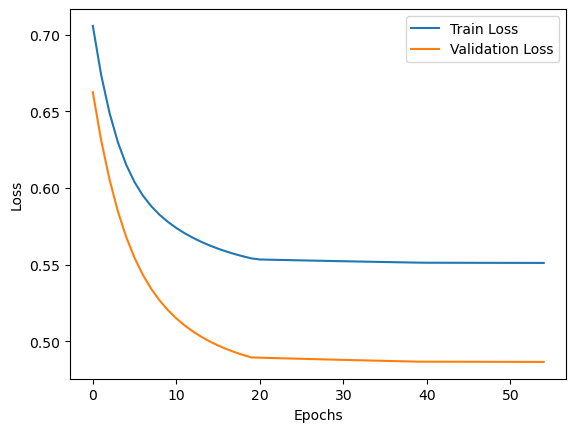

150/150 [==============================] - 0s 1ms/step
------------------------------------------------------------------------
Training for fold 2
Epoch 1/55
562/562 [==============================] - 2s 3ms/step - loss: 0.7457 - accuracy: 0.4773 - val_loss: 0.7279 - val_accuracy: 0.5185 - lr: 1.0000e-05
Epoch 2/55
562/562 [==============================] - 1s 3ms/step - loss: 0.7162 - accuracy: 0.5325 - val_loss: 0.6951 - val_accuracy: 0.5915 - lr: 1.0000e-05
Epoch 3/55
562/562 [==============================] - 1s 3ms/step - loss: 0.6918 - accuracy: 0.5908 - val_loss: 0.6671 - val_accuracy: 0.6479 - lr: 1.0000e-05
Epoch 4/55
562/562 [==============================] - 1s 3ms/step - loss: 0.6711 - accuracy: 0.6335 - val_loss: 0.6429 - val_accuracy: 0.6883 - lr: 1.0000e-05
Epoch 5/55
562/562 [==============================] - 1s 3ms/step - loss: 0.6534 - accuracy: 0.6588 - val_loss: 0.6216 - val_accuracy: 0.7175 - lr: 1.0000e-05
Epoch 6/55
562/562 [==============================] - 1s 

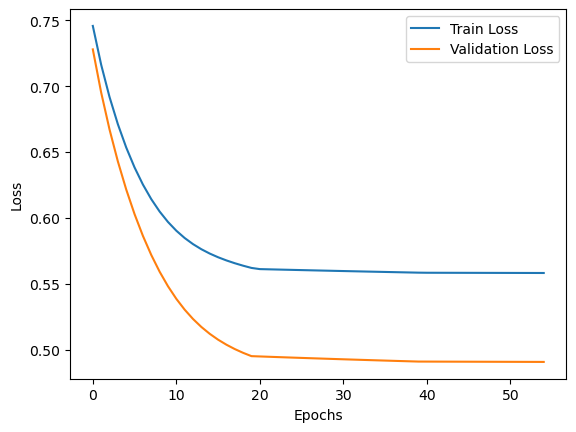

150/150 [==============================] - 0s 1ms/step
------------------------------------------------------------------------
Training for fold 3
Epoch 1/55
560/560 [==============================] - 2s 3ms/step - loss: 0.6882 - accuracy: 0.6175 - val_loss: 0.6455 - val_accuracy: 0.6602 - lr: 1.0000e-05
Epoch 2/55
560/560 [==============================] - 1s 3ms/step - loss: 0.6633 - accuracy: 0.6375 - val_loss: 0.6182 - val_accuracy: 0.6798 - lr: 1.0000e-05
Epoch 3/55
560/560 [==============================] - 1s 3ms/step - loss: 0.6449 - accuracy: 0.6530 - val_loss: 0.5974 - val_accuracy: 0.6990 - lr: 1.0000e-05
Epoch 4/55
560/560 [==============================] - 1s 3ms/step - loss: 0.6309 - accuracy: 0.6651 - val_loss: 0.5812 - val_accuracy: 0.7135 - lr: 1.0000e-05
Epoch 5/55
560/560 [==============================] - 1s 3ms/step - loss: 0.6199 - accuracy: 0.6778 - val_loss: 0.5681 - val_accuracy: 0.7319 - lr: 1.0000e-05
Epoch 6/55
560/560 [==============================] - 1s 

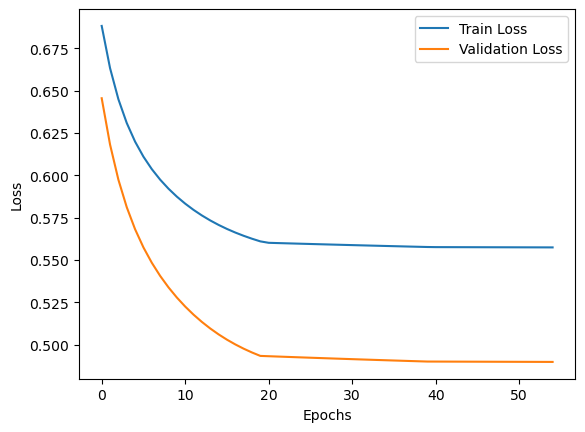

150/150 [==============================] - 0s 1ms/step
------------------------------------------------------------------------
Training for fold 4
Epoch 1/55
560/560 [==============================] - 2s 3ms/step - loss: 0.8461 - accuracy: 0.3631 - val_loss: 0.8427 - val_accuracy: 0.3600 - lr: 1.0000e-05
Epoch 2/55
560/560 [==============================] - 1s 2ms/step - loss: 0.7913 - accuracy: 0.4108 - val_loss: 0.7842 - val_accuracy: 0.4233 - lr: 1.0000e-05
Epoch 3/55
560/560 [==============================] - 1s 2ms/step - loss: 0.7478 - accuracy: 0.4661 - val_loss: 0.7360 - val_accuracy: 0.4933 - lr: 1.0000e-05
Epoch 4/55
560/560 [==============================] - 1s 2ms/step - loss: 0.7123 - accuracy: 0.5359 - val_loss: 0.6951 - val_accuracy: 0.5965 - lr: 1.0000e-05
Epoch 5/55
560/560 [==============================] - 1s 3ms/step - loss: 0.6827 - accuracy: 0.6183 - val_loss: 0.6596 - val_accuracy: 0.6625 - lr: 1.0000e-05
Epoch 6/55
560/560 [==============================] - 1s 

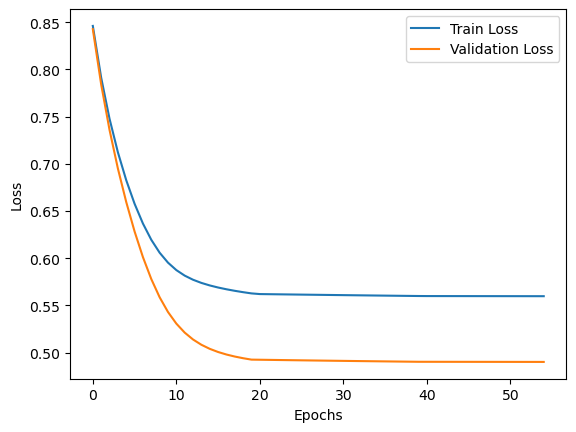

150/150 [==============================] - 0s 2ms/step
------------------------------------------------------------------------
Training for fold 5
Epoch 1/55
563/563 [==============================] - 2s 3ms/step - loss: 0.8968 - accuracy: 0.3602 - val_loss: 0.8591 - val_accuracy: 0.3706 - lr: 1.0000e-05
Epoch 2/55
563/563 [==============================] - 1s 2ms/step - loss: 0.8332 - accuracy: 0.3948 - val_loss: 0.7958 - val_accuracy: 0.4238 - lr: 1.0000e-05
Epoch 3/55
563/563 [==============================] - 1s 2ms/step - loss: 0.7811 - accuracy: 0.4415 - val_loss: 0.7431 - val_accuracy: 0.4881 - lr: 1.0000e-05
Epoch 4/55
563/563 [==============================] - 2s 3ms/step - loss: 0.7384 - accuracy: 0.4917 - val_loss: 0.6993 - val_accuracy: 0.5625 - lr: 1.0000e-05
Epoch 5/55
563/563 [==============================] - 2s 3ms/step - loss: 0.7038 - accuracy: 0.5485 - val_loss: 0.6631 - val_accuracy: 0.6300 - lr: 1.0000e-05
Epoch 6/55
563/563 [==============================] - 2s 

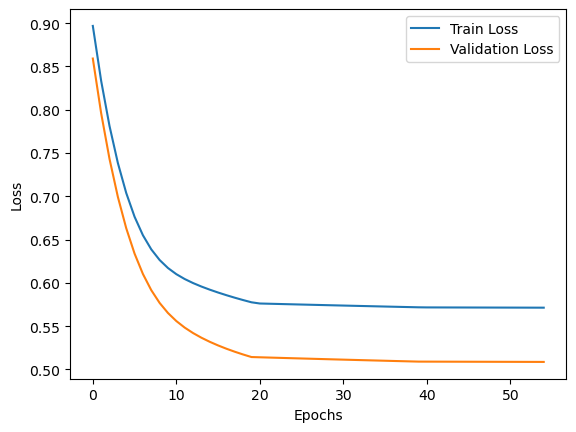

150/150 [==============================] - 0s 2ms/step
Accuracy: 0.797 (+/- 0.006)
Precision: 0.566 (+/- 0.009)
Recall: 0.357 (+/- 0.033)
F1 score: 0.437 (+/- 0.025)
AUC score: 0.640 (+/- 0.013)


In [41]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
AUC_scores = []

fold_no = 1
for train_index, test_index in kf.split(X_train, y_train):
    X_train_dl, X_test_dl = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_dl, y_test_dl = y_train.iloc[train_index], y_train.iloc[test_index]

    # Perform preprocessing steps on X_train_dl
    X_train_dl_preprocessed = enc_dl.fit_transform(X_train_dl)
    X_test_dl_preprocessed = enc_dl.transform(X_test_dl)

    # Apply SMOTE and undersampling to address class imbalance
    from imblearn.pipeline import Pipeline
    over = SMOTE(sampling_strategy=0.4)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o',over),('u',under)]
    pipe = Pipeline(steps=steps)
        
    X_train_dl_resampled, y_train_dl_resampled =  pipe.fit_resample(X_train_dl_preprocessed, y_train_dl)
    concat = pd.concat([X_train_dl_resampled,y_train_dl_resampled],axis=1)
    concat = concat.sample(frac=1)
    X_train_dl_resampled = concat.drop('DEFAULT',axis=1)
    y_train_dl_resampled= concat['DEFAULT']
    
    
    round_cols = ['SEX','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6'] + X_train_dl_resampled.filter(like='EDUCATION').columns.to_list() + X_train_dl_resampled.filter(like='MARRIAGE').columns.to_list() 
    for col in round_cols:
        X_train_dl_resampled[col] = X_train_dl_resampled[col].round()
    
    # Split training data into static and temporal features
    # Perform any necessary reshaping or transformations
    temp_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
    'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
    'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
    'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    static_cols_train = X_train_dl_resampled.drop(temp_cols,axis=1).columns.to_list()
    static_cols_test = X_test_dl_preprocessed.drop(temp_cols,axis=1).columns.to_list()
    
    X_train_dl_temp = X_train_dl_resampled[temp_cols]
    X_train_dl_static = X_train_dl_resampled[static_cols_train]
    X_test_dl_temp = X_test_dl_preprocessed[temp_cols]
    X_test_dl_static = X_test_dl_preprocessed[static_cols_test]

    PAY_cols = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2','PAY_1']
    BILL_AMT_cols = ['BILL_AMT6','BILL_AMT5','BILL_AMT4','BILL_AMT3','BILL_AMT2','BILL_AMT1']
    PAY_AMT_cols = ['PAY_AMT6','PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
    
    PAY_train_dl = X_train_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_train_dl = X_train_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_train_dl = X_train_dl_temp[PAY_AMT_cols].to_numpy()
    
    PAY_test_dl = X_test_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_test_dl = X_test_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_test_dl = X_test_dl_temp[PAY_AMT_cols].to_numpy()   
    
    # Stack temporal features
    stacked_train = np.dstack((PAY_train_dl,BILL_AMT_train_dl,PAY_AMT_train_dl))
    stacked_test = np.dstack((PAY_test_dl,BILL_AMT_test_dl,PAY_AMT_test_dl))
    y_train_dl_resampled = y_train_dl_resampled.to_numpy()
    y_test_dl = y_test_dl.to_numpy()

    # Build and compile RNN model
    num_time_steps, num_features = stacked_train.shape[1], stacked_train.shape[2]

    # Define the RNN model
    rnn_model = Sequential()
    rnn_model.add(SimpleRNN(16, return_sequences=True, input_shape=(num_time_steps, num_features)))
    rnn_model.add(Flatten())
    rnn_model.add(Dense(1, activation='sigmoid'))
    
    initial_learning_rate = 0.00001  # Initial learning rate
    decay_rate = 0.1  # Decay rate
    decay_steps = 20  # Decay steps (number of steps before applying decay)
    epochs = 55

    def learning_rate_scheduler(epoch):
        return initial_learning_rate * decay_rate ** (epoch // decay_steps)

    
    rnn_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=initial_learning_rate), metrics=['accuracy'])
    
    lr_scheduler = LearningRateScheduler(learning_rate_scheduler)
    
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no}')
 
    # Train the model
    
    batch_size = 32
    
    # Train the model
    history = rnn_model.fit(stacked_train, y_train_dl_resampled, epochs=epochs, batch_size=batch_size, validation_data=(stacked_test, y_test_dl),shuffle=False,callbacks = [lr_scheduler])
    
    # Plot the loss on train vs validate tests
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
    y_pred_probs = rnn_model.predict(stacked_test)
    y_pred = (y_pred_probs>=0.5).astype(int)    
    
    accuracy =  accuracy_score(y_test_dl,y_pred)
    precision = precision_score(y_test_dl,y_pred)
    recall = recall_score(y_test_dl,y_pred)
    f1 =  f1_score(y_test_dl,y_pred)
    AUC = roc_auc_score(y_test_dl,y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    AUC_scores.append(AUC)
    
    fold_no = fold_no + 1


# Calculate the average and standard deviation of the evaluation metrics
print('Accuracy: %.3f (+/- %.3f)' % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print('Precision: %.3f (+/- %.3f)' % (np.mean(precision_scores), np.std(precision_scores)))
print('Recall: %.3f (+/- %.3f)' % (np.mean(recall_scores), np.std(recall_scores)))
print('F1 score: %.3f (+/- %.3f)' % (np.mean(f1_scores), np.std(f1_scores)))
print('AUC score: %.3f (+/- %.3f)' % (np.mean(AUC_scores), np.std(AUC_scores)))

Accuracy: 0.764 (+/- 0.009)
Precision: 0.465 (+/- 0.027)
Recall: 0.417 (+/- 0.022)
F1 score: 0.439 (+/- 0.011)
AUC score: 0.640 (+/- 0.008)

### CNN 

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

------------------------------------------------------------------------
Training for fold 1
Epoch 1/55
561/561 [==============================] - 11s 18ms/step - loss: 0.7376 - accuracy: 0.5604 - val_loss: 0.6214 - val_accuracy: 0.7756 - lr: 1.0000e-05
Epoch 2/55
561/561 [==============================] - 12s 21ms/step - loss: 0.7227 - accuracy: 0.5810 - val_loss: 0.6144 - val_accuracy: 0.7788 - lr: 1.0000e-05
Epoch 3/55
561/561 [==============================] - 12s 22ms/step - loss: 0.7175 - accuracy: 0.5878 - val_loss: 0.6084 - val_accuracy: 0.7792 - lr: 1.0000e-05
Epoch 4/55
561/561 [==============================] - 11s 20ms/step - loss: 0.7063 - accuracy: 0.6004 - val_loss: 0.6035 - val_accuracy: 0.7810 - lr: 1.0000e-05
Epoch 5/55
561/561 [==============================] - 13s 23ms/step - loss: 0.7077 - accuracy: 0.6106 - val_loss: 0.5991 - val_accuracy: 0.7833 - lr: 1.0000e-05
Epoch 6/55
561/561 [==============================] - 6s 11ms/step - loss: 0.6951 - accuracy: 0.6203 -

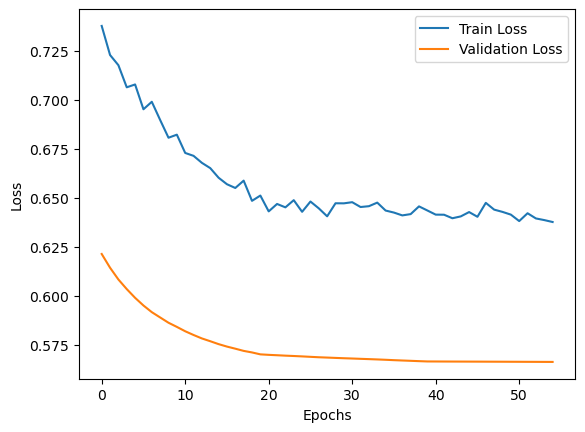

150/150 [==============================] - 0s 1ms/step
------------------------------------------------------------------------
Training for fold 2
Epoch 1/55
562/562 [==============================] - 6s 10ms/step - loss: 0.7577 - accuracy: 0.6251 - val_loss: 0.5913 - val_accuracy: 0.7719 - lr: 1.0000e-05
Epoch 2/55
562/562 [==============================] - 8s 14ms/step - loss: 0.7306 - accuracy: 0.6343 - val_loss: 0.5880 - val_accuracy: 0.7706 - lr: 1.0000e-05
Epoch 3/55
562/562 [==============================] - 8s 14ms/step - loss: 0.7152 - accuracy: 0.6331 - val_loss: 0.5855 - val_accuracy: 0.7704 - lr: 1.0000e-05
Epoch 4/55
562/562 [==============================] - 8s 15ms/step - loss: 0.7236 - accuracy: 0.6316 - val_loss: 0.5833 - val_accuracy: 0.7708 - lr: 1.0000e-05
Epoch 5/55
562/562 [==============================] - 7s 13ms/step - loss: 0.7109 - accuracy: 0.6315 - val_loss: 0.5814 - val_accuracy: 0.7715 - lr: 1.0000e-05
Epoch 6/55
562/562 [==============================] 

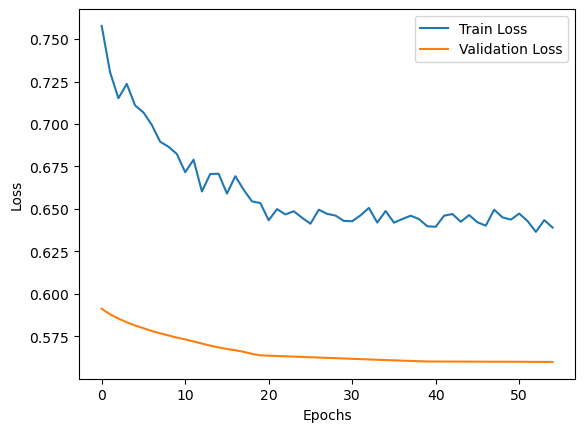

150/150 [==============================] - 0s 1ms/step
------------------------------------------------------------------------
Training for fold 3
Epoch 1/55
560/560 [==============================] - 3s 4ms/step - loss: 0.8519 - accuracy: 0.5977 - val_loss: 0.6167 - val_accuracy: 0.7765 - lr: 1.0000e-05
Epoch 2/55
560/560 [==============================] - 2s 4ms/step - loss: 0.8225 - accuracy: 0.6113 - val_loss: 0.6081 - val_accuracy: 0.7767 - lr: 1.0000e-05
Epoch 3/55
560/560 [==============================] - 2s 3ms/step - loss: 0.8053 - accuracy: 0.6135 - val_loss: 0.6008 - val_accuracy: 0.7773 - lr: 1.0000e-05
Epoch 4/55
560/560 [==============================] - 2s 4ms/step - loss: 0.7887 - accuracy: 0.6152 - val_loss: 0.5946 - val_accuracy: 0.7769 - lr: 1.0000e-05
Epoch 5/55
560/560 [==============================] - 2s 3ms/step - loss: 0.7767 - accuracy: 0.6225 - val_loss: 0.5894 - val_accuracy: 0.7756 - lr: 1.0000e-05
Epoch 6/55
560/560 [==============================] - 2s 

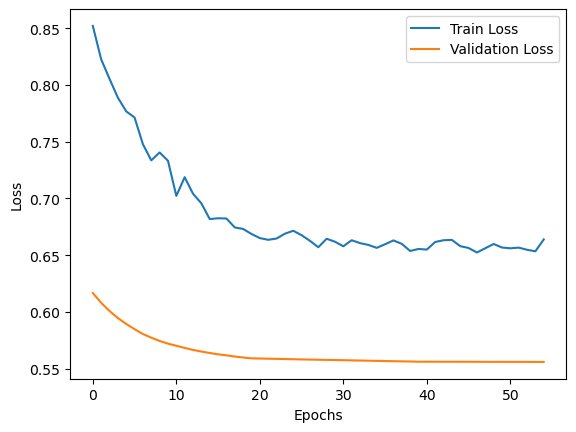

150/150 [==============================] - 0s 1ms/step
------------------------------------------------------------------------
Training for fold 4
Epoch 1/55
560/560 [==============================] - 16s 28ms/step - loss: 0.8865 - accuracy: 0.4753 - val_loss: 0.7280 - val_accuracy: 0.5121 - lr: 1.0000e-05
Epoch 2/55
560/560 [==============================] - 2s 4ms/step - loss: 0.8365 - accuracy: 0.4989 - val_loss: 0.6848 - val_accuracy: 0.6321 - lr: 1.0000e-05
Epoch 3/55
560/560 [==============================] - 3s 5ms/step - loss: 0.8039 - accuracy: 0.5310 - val_loss: 0.6549 - val_accuracy: 0.7033 - lr: 1.0000e-05
Epoch 4/55
560/560 [==============================] - 6s 10ms/step - loss: 0.7854 - accuracy: 0.5488 - val_loss: 0.6328 - val_accuracy: 0.7462 - lr: 1.0000e-05
Epoch 5/55
560/560 [==============================] - 5s 9ms/step - loss: 0.7629 - accuracy: 0.5654 - val_loss: 0.6181 - val_accuracy: 0.7729 - lr: 1.0000e-05
Epoch 6/55
560/560 [==============================] - 

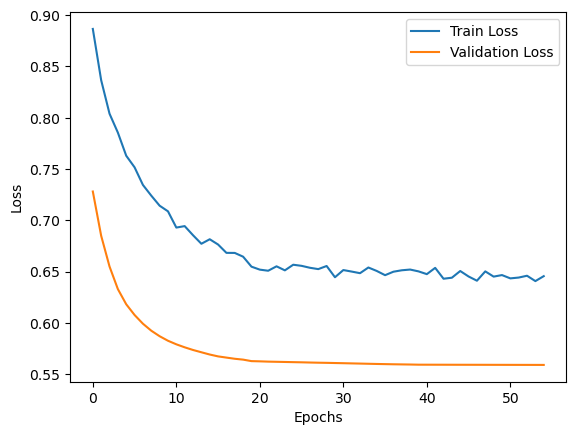

150/150 [==============================] - 0s 1ms/step
------------------------------------------------------------------------
Training for fold 5
Epoch 1/55
563/563 [==============================] - 3s 4ms/step - loss: 0.8668 - accuracy: 0.5239 - val_loss: 0.6468 - val_accuracy: 0.7473 - lr: 1.0000e-05
Epoch 2/55
563/563 [==============================] - 5s 9ms/step - loss: 0.8368 - accuracy: 0.5439 - val_loss: 0.6309 - val_accuracy: 0.7633 - lr: 1.0000e-05
Epoch 3/55
563/563 [==============================] - 2s 4ms/step - loss: 0.8127 - accuracy: 0.5631 - val_loss: 0.6187 - val_accuracy: 0.7671 - lr: 1.0000e-05
Epoch 4/55
563/563 [==============================] - 2s 4ms/step - loss: 0.7843 - accuracy: 0.5790 - val_loss: 0.6101 - val_accuracy: 0.7742 - lr: 1.0000e-05
Epoch 5/55
563/563 [==============================] - 2s 4ms/step - loss: 0.7702 - accuracy: 0.5926 - val_loss: 0.6033 - val_accuracy: 0.7760 - lr: 1.0000e-05
Epoch 6/55
563/563 [==============================] - 2s 

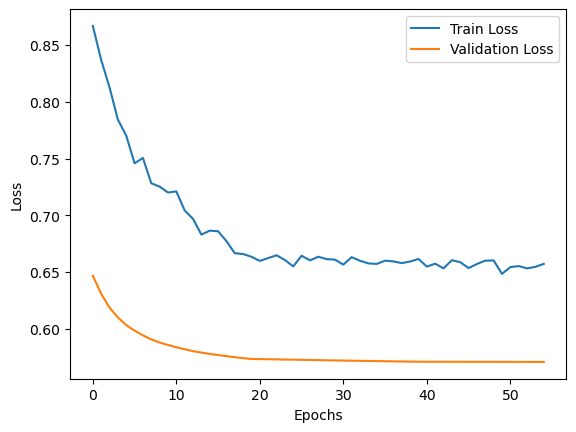

150/150 [==============================] - 0s 1ms/step
Accuracy: 0.795 (+/- 0.007)
Precision: 0.558 (+/- 0.032)
Recall: 0.355 (+/- 0.026)
F1 score: 0.433 (+/- 0.021)
AUC score: 0.637 (+/- 0.010)


In [25]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
AUC_scores = []

fold_no = 1
for train_index, test_index in kf.split(X_train, y_train):
    X_train_dl, X_test_dl = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_dl, y_test_dl = y_train.iloc[train_index], y_train.iloc[test_index]

    # Perform preprocessing steps on X_train_dl
    X_train_dl_preprocessed = enc_dl.fit_transform(X_train_dl)
    X_test_dl_preprocessed = enc_dl.transform(X_test_dl)

    # Apply SMOTE and undersampling to address class imbalance
    from imblearn.pipeline import Pipeline
    over = SMOTE(sampling_strategy=0.4)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o',over),('u',under)]
    pipe = Pipeline(steps=steps)
        
    X_train_dl_resampled, y_train_dl_resampled =  pipe.fit_resample(X_train_dl_preprocessed, y_train_dl)
    
    round_cols = ['SEX','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6'] + X_train_dl_resampled.filter(like='EDUCATION').columns.to_list() + X_train_dl_resampled.filter(like='MARRIAGE').columns.to_list() 
    for col in round_cols:
        X_train_dl_resampled[col] = X_train_dl_resampled[col].round()
    
    # Split training data into static and temporal features
    # Perform any necessary reshaping or transformations
    temp_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
    'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
    'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
    'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    static_cols_train = X_train_dl_resampled.drop(temp_cols,axis=1).columns.to_list()
    static_cols_test = X_test_dl_preprocessed.drop(temp_cols,axis=1).columns.to_list()
    
    X_train_dl_temp = X_train_dl_resampled[temp_cols]
    X_train_dl_static = X_train_dl_resampled[static_cols_train]
    X_test_dl_temp = X_test_dl_preprocessed[temp_cols]
    X_test_dl_static = X_test_dl_preprocessed[static_cols_test]

    PAY_cols = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2','PAY_1']
    BILL_AMT_cols = ['BILL_AMT6','BILL_AMT5','BILL_AMT4','BILL_AMT3','BILL_AMT2','BILL_AMT1']
    PAY_AMT_cols = ['PAY_AMT6','PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
    
    PAY_train_dl = X_train_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_train_dl = X_train_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_train_dl = X_train_dl_temp[PAY_AMT_cols].to_numpy()
    
    PAY_test_dl = X_test_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_test_dl = X_test_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_test_dl = X_test_dl_temp[PAY_AMT_cols].to_numpy()   
    
    # Stack temporal features
    stacked_train = np.dstack((PAY_train_dl,BILL_AMT_train_dl,PAY_AMT_train_dl))
    stacked_test = np.dstack((PAY_test_dl,BILL_AMT_test_dl,PAY_AMT_test_dl))
    y_train_dl_resampled = y_train_dl_resampled.to_numpy()
    y_test_dl = y_test_dl.to_numpy()


    # Build and compile CNN model
    num_time_steps, num_features = stacked_train.shape[1], stacked_train.shape[2]

    # Define the CNN model
    cnn_model = Sequential()
    cnn_model.add(Conv1D(filters=16, kernel_size=5, activation='relu',padding='same', input_shape=(num_time_steps, num_features)))
    cnn_model.add(MaxPooling1D(pool_size=3))
    cnn_model.add(Conv1D(filters=32, padding='same', kernel_size=3, activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Flatten())
    cnn_model.add(Dropout(0.7))
    cnn_model.add(Dense(1, activation='sigmoid'))
    
    initial_learning_rate = 0.00001  # Initial learning rate
    decay_rate = 0.1  # Decay rate
    decay_steps = 20  # Decay steps (number of steps before applying decay)
    epochs = 55

    def learning_rate_scheduler(epoch):
        return initial_learning_rate * decay_rate ** (epoch // decay_steps)
    
    cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = initial_learning_rate), metrics=['accuracy'])
    
    lr_scheduler = LearningRateScheduler(learning_rate_scheduler)
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no}')
 
    # Train the model
    
    batch_size = 32
    
    # Train the model
    history = cnn_model.fit(stacked_train, y_train_dl_resampled, epochs=epochs, batch_size=batch_size, validation_data=(stacked_test, y_test_dl),shuffle=False,callbacks=[lr_scheduler])
    
    # Plot the loss on train vs validate tests
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    y_pred_probs = cnn_model.predict(stacked_test)
    y_pred = (y_pred_probs>=0.5).astype(int)    
    
    accuracy =  accuracy_score(y_test_dl,y_pred)
    precision = precision_score(y_test_dl,y_pred)
    recall = recall_score(y_test_dl,y_pred)
    f1 =  f1_score(y_test_dl,y_pred)
    AUC = roc_auc_score(y_test_dl,y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    AUC_scores.append(AUC)
    
    fold_no = fold_no + 1


# Calculate the average and standard deviation of the evaluation metrics
print('Accuracy: %.3f (+/- %.3f)' % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print('Precision: %.3f (+/- %.3f)' % (np.mean(precision_scores), np.std(precision_scores)))
print('Recall: %.3f (+/- %.3f)' % (np.mean(recall_scores), np.std(recall_scores)))
print('F1 score: %.3f (+/- %.3f)' % (np.mean(f1_scores), np.std(f1_scores)))
print('AUC score: %.3f (+/- %.3f)' % (np.mean(AUC_scores), np.std(AUC_scores)))

prin: 

Accuracy: 0.798 (+/- 0.008)
Precision: 0.577 (+/- 0.031)
Recall: 0.324 (+/- 0.033)
F1 score: 0.414 (+/- 0.034)
AUC score: 0.628 (+/- 0.017)


## Concatenation layer

LSTM (STATIC  + TEMPORAL 2) - augmented

------------------------------------------------------------------------
Training for fold 1
Epoch 1/55
561/561 [==============================] - 4s 4ms/step - loss: 0.6090 - accuracy: 0.6777 - val_loss: 0.5083 - val_accuracy: 0.7917 - lr: 1.0000e-04
Epoch 2/55
561/561 [==============================] - 2s 4ms/step - loss: 0.5521 - accuracy: 0.7369 - val_loss: 0.4930 - val_accuracy: 0.7967 - lr: 1.0000e-04
Epoch 3/55
561/561 [==============================] - 2s 4ms/step - loss: 0.5395 - accuracy: 0.7423 - val_loss: 0.4847 - val_accuracy: 0.7992 - lr: 1.0000e-04
Epoch 4/55
561/561 [==============================] - 2s 4ms/step - loss: 0.5318 - accuracy: 0.7464 - val_loss: 0.4790 - val_accuracy: 0.8027 - lr: 1.0000e-04
Epoch 5/55
561/561 [==============================] - 2s 4ms/step - loss: 0.5264 - accuracy: 0.7503 - val_loss: 0.4752 - val_accuracy: 0.8062 - lr: 1.0000e-04
Epoch 6/55
561/561 [==============================] - 2s 4ms/step - loss: 0.5226 - accuracy: 0.7529 - val_loss: 

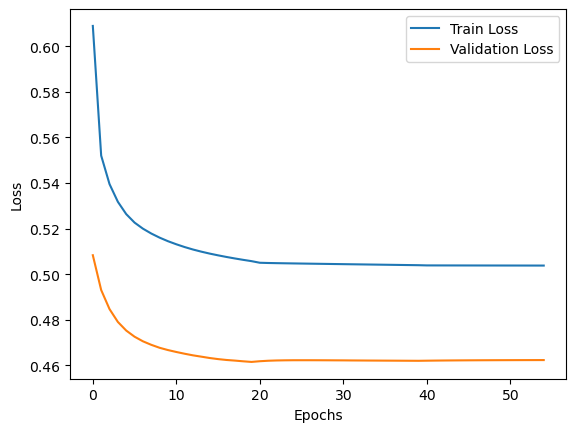

150/150 [==============================] - 1s 1ms/step
------------------------------------------------------------------------
Training for fold 2
Epoch 1/55
562/562 [==============================] - 4s 5ms/step - loss: 0.6137 - accuracy: 0.6960 - val_loss: 0.5019 - val_accuracy: 0.8037 - lr: 1.0000e-04
Epoch 2/55
562/562 [==============================] - 2s 4ms/step - loss: 0.5575 - accuracy: 0.7311 - val_loss: 0.4832 - val_accuracy: 0.8071 - lr: 1.0000e-04
Epoch 3/55
562/562 [==============================] - 2s 4ms/step - loss: 0.5463 - accuracy: 0.7356 - val_loss: 0.4747 - val_accuracy: 0.8092 - lr: 1.0000e-04
Epoch 4/55
562/562 [==============================] - 2s 4ms/step - loss: 0.5395 - accuracy: 0.7395 - val_loss: 0.4693 - val_accuracy: 0.8104 - lr: 1.0000e-04
Epoch 5/55
562/562 [==============================] - 2s 4ms/step - loss: 0.5345 - accuracy: 0.7438 - val_loss: 0.4657 - val_accuracy: 0.8110 - lr: 1.0000e-04
Epoch 6/55
562/562 [==============================] - 2s 

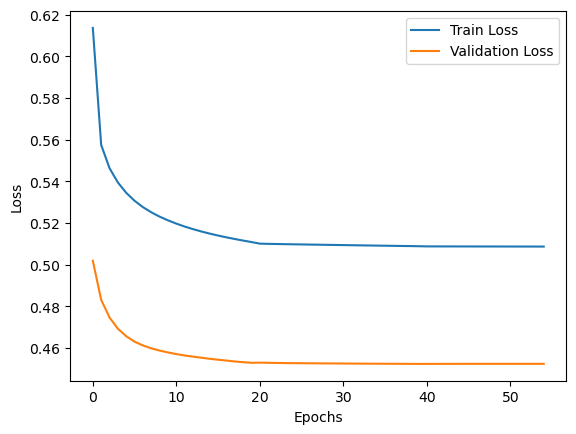

150/150 [==============================] - 1s 2ms/step
------------------------------------------------------------------------
Training for fold 3
Epoch 1/55
560/560 [==============================] - 5s 5ms/step - loss: 0.5906 - accuracy: 0.7158 - val_loss: 0.4972 - val_accuracy: 0.8027 - lr: 1.0000e-04
Epoch 2/55
560/560 [==============================] - 3s 5ms/step - loss: 0.5494 - accuracy: 0.7381 - val_loss: 0.4817 - val_accuracy: 0.8060 - lr: 1.0000e-04
Epoch 3/55
560/560 [==============================] - 2s 4ms/step - loss: 0.5372 - accuracy: 0.7436 - val_loss: 0.4751 - val_accuracy: 0.8075 - lr: 1.0000e-04
Epoch 4/55
560/560 [==============================] - 2s 4ms/step - loss: 0.5302 - accuracy: 0.7476 - val_loss: 0.4713 - val_accuracy: 0.8046 - lr: 1.0000e-04
Epoch 5/55
560/560 [==============================] - 2s 4ms/step - loss: 0.5256 - accuracy: 0.7505 - val_loss: 0.4690 - val_accuracy: 0.8065 - lr: 1.0000e-04
Epoch 6/55
560/560 [==============================] - 2s 

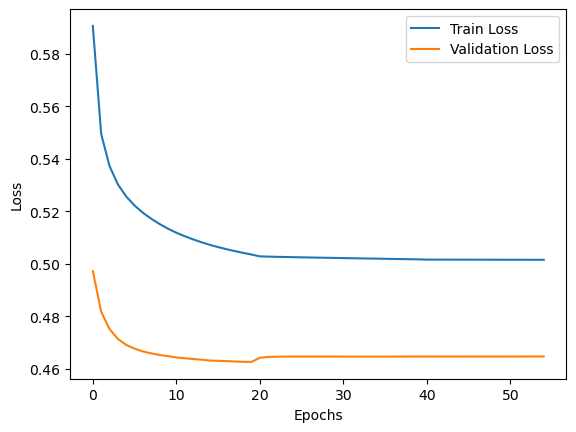

150/150 [==============================] - 1s 2ms/step
------------------------------------------------------------------------
Training for fold 4
Epoch 1/55
560/560 [==============================] - 5s 5ms/step - loss: 0.5880 - accuracy: 0.7151 - val_loss: 0.4968 - val_accuracy: 0.7992 - lr: 1.0000e-04
Epoch 2/55
560/560 [==============================] - 3s 5ms/step - loss: 0.5501 - accuracy: 0.7401 - val_loss: 0.4825 - val_accuracy: 0.8054 - lr: 1.0000e-04
Epoch 3/55
560/560 [==============================] - 3s 5ms/step - loss: 0.5381 - accuracy: 0.7451 - val_loss: 0.4753 - val_accuracy: 0.8081 - lr: 1.0000e-04
Epoch 4/55
560/560 [==============================] - 3s 5ms/step - loss: 0.5318 - accuracy: 0.7499 - val_loss: 0.4711 - val_accuracy: 0.8117 - lr: 1.0000e-04
Epoch 5/55
560/560 [==============================] - 3s 5ms/step - loss: 0.5276 - accuracy: 0.7534 - val_loss: 0.4683 - val_accuracy: 0.8135 - lr: 1.0000e-04
Epoch 6/55
560/560 [==============================] - 3s 

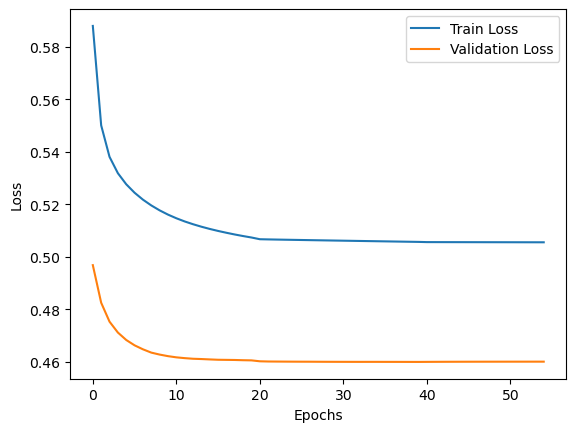

150/150 [==============================] - 1s 2ms/step
------------------------------------------------------------------------
Training for fold 5
Epoch 1/55
563/563 [==============================] - 5s 5ms/step - loss: 0.6101 - accuracy: 0.6838 - val_loss: 0.5158 - val_accuracy: 0.7846 - lr: 1.0000e-04
Epoch 2/55
563/563 [==============================] - 2s 4ms/step - loss: 0.5602 - accuracy: 0.7305 - val_loss: 0.4953 - val_accuracy: 0.7946 - lr: 1.0000e-04
Epoch 3/55
563/563 [==============================] - 3s 4ms/step - loss: 0.5450 - accuracy: 0.7379 - val_loss: 0.4847 - val_accuracy: 0.7971 - lr: 1.0000e-04
Epoch 4/55
563/563 [==============================] - 3s 5ms/step - loss: 0.5361 - accuracy: 0.7444 - val_loss: 0.4786 - val_accuracy: 0.7981 - lr: 1.0000e-04
Epoch 5/55
563/563 [==============================] - 2s 4ms/step - loss: 0.5309 - accuracy: 0.7491 - val_loss: 0.4751 - val_accuracy: 0.8004 - lr: 1.0000e-04
Epoch 6/55
563/563 [==============================] - 3s 

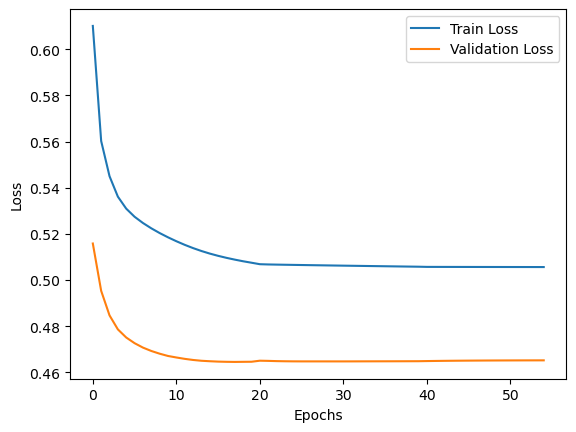

150/150 [==============================] - 1s 1ms/step
Accuracy: 0.810 (+/- 0.002)
Precision: 0.585 (+/- 0.015)
Recall: 0.481 (+/- 0.017)
F1 score: 0.527 (+/- 0.010)
AUC score: 0.692 (+/- 0.006)


In [49]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
AUC_scores = []

fold_no = 1
for train_index, test_index in kf.split(X_train, y_train):
    X_train_dl, X_test_dl = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_dl, y_test_dl = y_train.iloc[train_index], y_train.iloc[test_index]

    # Perform preprocessing steps on X_train_dl
    X_train_dl_preprocessed = enc_dl.fit_transform(X_train_dl)
    X_test_dl_preprocessed = enc_dl.transform(X_test_dl)

    # Apply SMOTE and undersampling to address class imbalance
    from imblearn.pipeline import Pipeline
    over = SMOTE(sampling_strategy=0.4)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o',over),('u',under)]
    pipe = Pipeline(steps=steps)
        
    X_train_dl_resampled, y_train_dl_resampled =  pipe.fit_resample(X_train_dl_preprocessed, y_train_dl)
    
    round_cols = ['SEX','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6'] + X_train_dl_resampled.filter(like='EDUCATION').columns.to_list() + X_train_dl_resampled.filter(like='MARRIAGE').columns.to_list() 
    for col in round_cols:
        X_train_dl_resampled[col] = X_train_dl_resampled[col].round()
        
    y_train_dl_resampled = pd.Series(y_train_dl_resampled,name='DEFAULT')
    concat = pd.concat([X_train_dl_resampled,y_train_dl_resampled],axis=1)
    non_default = concat[concat['DEFAULT']==0].drop('DEFAULT',axis=1)
    default = concat[concat['DEFAULT']==1].drop('DEFAULT',axis=1)
    
    null_columns = ['LIMIT_BAL','AGE','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6']
    
    augmented_default = augment_data_with_knn(default, null_columns)
    augmented_non_default = augment_data_with_knn(non_default, null_columns)
    augmented_non_default['DEFAULT'] = 0
    augmented_default['DEFAULT'] = 1
    augmented_data = pd.concat([augmented_default,augmented_non_default],axis=0)
    augmented_data = augmented_data.sample(frac=1, random_state=42)
    
    X_train_dl_augmented = augmented_data.drop('DEFAULT',axis=1)
    y_train_dl_augmented = augmented_data['DEFAULT']
    
    
    # Split training data into static and temporal features
    # Perform any necessary reshaping or transformations
    temp_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
    'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
    'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
    'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    static_cols_train = X_train_dl_augmented.drop(temp_cols,axis=1).columns.to_list()
    static_cols_test = X_test_dl_preprocessed.drop(temp_cols,axis=1).columns.to_list()
    
    X_train_dl_temp = X_train_dl_augmented[temp_cols]
    X_train_dl_static = X_train_dl_augmented[static_cols_train]
    X_test_dl_temp = X_test_dl_preprocessed[temp_cols]
    X_test_dl_static = X_test_dl_preprocessed[static_cols_test]

    PAY_cols = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2','PAY_1']
    BILL_AMT_cols = ['BILL_AMT6','BILL_AMT5','BILL_AMT4','BILL_AMT3','BILL_AMT2','BILL_AMT1']
    PAY_AMT_cols = ['PAY_AMT6','PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
    
    PAY_train_dl = X_train_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_train_dl = X_train_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_train_dl = X_train_dl_temp[PAY_AMT_cols].to_numpy()
    
    PAY_test_dl = X_test_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_test_dl = X_test_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_test_dl = X_test_dl_temp[PAY_AMT_cols].to_numpy()   
    
    # Stack temporal features
    stacked_train = np.dstack((PAY_train_dl,BILL_AMT_train_dl,PAY_AMT_train_dl))
    stacked_test = np.dstack((PAY_test_dl,BILL_AMT_test_dl,PAY_AMT_test_dl))
    y_train_dl_augmented = y_train_dl_augmented.to_numpy()
    y_test_dl = y_test_dl.to_numpy()

    # Build and compile LSTM model
    num_time_steps, num_features = stacked_train.shape[1], stacked_train.shape[2]
    
    temporal_input = Input(shape=(num_time_steps, num_features),name = 'TEMPORAL_INPUT')
    static_input = Input(shape=(X_train_dl_static.shape[1]),name = 'STATIC_INPUT')

    lstm_layer = LSTM(16,return_sequences=True, name = 'LSTM_LAYER')(temporal_input)
    lstm_flat = Flatten(name = 'FLATTEN')(lstm_layer)
    


    combined = Concatenate(name ='CONCAT')([lstm_flat,static_input])
    combined = Dense(32,activation='relu')(combined)
    
    output = Dense(1,activation='sigmoid',name='OUTPUT_LAYER')(combined)

    model = Model(inputs=[temporal_input,static_input],outputs=[output])


    initial_learning_rate = 0.0001  # Initial learning rate
    decay_rate = 0.1  # Decay rate
    decay_steps = 20  # Decay steps (number of steps before applying decay)
    epochs = 55

    def learning_rate_scheduler(epoch):
        return initial_learning_rate * decay_rate ** (epoch // decay_steps)


    model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate=initial_learning_rate), metrics=['accuracy'])

    lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

    
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no}')
        

    
    #Train the model
    batch_size = 64    
  
    history = model.fit([stacked_train, X_train_dl_static], y_train_dl_augmented, epochs=epochs, batch_size=batch_size, validation_data=([stacked_test, X_test_dl_static], y_test_dl),shuffle=False,callbacks = [lr_scheduler])
    
    # Plot the loss on train vs validate tests
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Make predictions on the test set    
    y_pred_probs = model.predict([stacked_test, X_test_dl_static])
    y_pred = (y_pred_probs>=0.5).astype(int)    
    
    accuracy =  accuracy_score(y_test_dl,y_pred)
    precision = precision_score(y_test_dl,y_pred)
    recall = recall_score(y_test_dl,y_pred)
    f1 =  f1_score(y_test_dl,y_pred)
    AUC = roc_auc_score(y_test_dl,y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    AUC_scores.append(AUC)
    
    fold_no = fold_no + 1


# Calculate the average and standard deviation of the evaluation metrics
print('Accuracy: %.3f (+/- %.3f)' % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print('Precision: %.3f (+/- %.3f)' % (np.mean(precision_scores), np.std(precision_scores)))
print('Recall: %.3f (+/- %.3f)' % (np.mean(recall_scores), np.std(recall_scores)))
print('F1 score: %.3f (+/- %.3f)' % (np.mean(f1_scores), np.std(f1_scores)))
print('AUC score: %.3f (+/- %.3f)' % (np.mean(AUC_scores), np.std(AUC_scores)))

### LSTM (Static + Temporal)

------------------------------------------------------------------------
Training for fold 1
Epoch 1/50
631/631 [==============================] - 4s 4ms/step - loss: 0.6922 - accuracy: 0.5161 - val_loss: 0.6776 - val_accuracy: 0.5846 - lr: 1.0000e-05
Epoch 2/50
631/631 [==============================] - 3s 4ms/step - loss: 0.6803 - accuracy: 0.5689 - val_loss: 0.6630 - val_accuracy: 0.6539 - lr: 1.0000e-05
Epoch 3/50
631/631 [==============================] - 3s 4ms/step - loss: 0.6694 - accuracy: 0.6141 - val_loss: 0.6495 - val_accuracy: 0.7120 - lr: 1.0000e-05
Epoch 4/50
631/631 [==============================] - 2s 4ms/step - loss: 0.6594 - accuracy: 0.6566 - val_loss: 0.6371 - val_accuracy: 0.7428 - lr: 1.0000e-05
Epoch 5/50
631/631 [==============================] - 2s 4ms/step - loss: 0.6503 - accuracy: 0.6775 - val_loss: 0.6256 - val_accuracy: 0.7554 - lr: 1.0000e-05
Epoch 6/50
631/631 [==============================] - 2s 4ms/step - loss: 0.6419 - accuracy: 0.6850 - val_loss: 

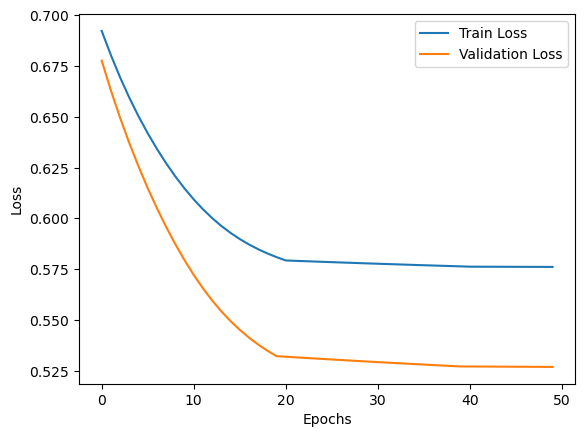

169/169 [==============================] - 1s 2ms/step
------------------------------------------------------------------------
Training for fold 2
Epoch 1/50
630/630 [==============================] - 4s 4ms/step - loss: 0.7761 - accuracy: 0.3844 - val_loss: 0.7941 - val_accuracy: 0.3257 - lr: 1.0000e-05
Epoch 2/50
630/630 [==============================] - 2s 4ms/step - loss: 0.7576 - accuracy: 0.4121 - val_loss: 0.7700 - val_accuracy: 0.3689 - lr: 1.0000e-05
Epoch 3/50
630/630 [==============================] - 3s 4ms/step - loss: 0.7397 - accuracy: 0.4448 - val_loss: 0.7474 - val_accuracy: 0.4246 - lr: 1.0000e-05
Epoch 4/50
630/630 [==============================] - 3s 4ms/step - loss: 0.7232 - accuracy: 0.4816 - val_loss: 0.7263 - val_accuracy: 0.4809 - lr: 1.0000e-05
Epoch 5/50
630/630 [==============================] - 3s 5ms/step - loss: 0.7079 - accuracy: 0.5199 - val_loss: 0.7067 - val_accuracy: 0.5372 - lr: 1.0000e-05
Epoch 6/50
630/630 [==============================] - 3s 

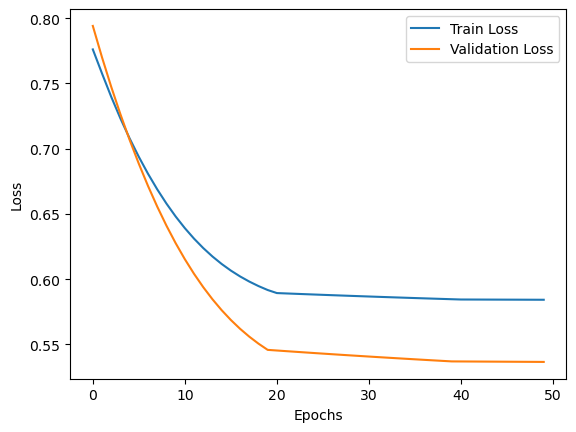

169/169 [==============================] - 1s 1ms/step
------------------------------------------------------------------------
Training for fold 3
Epoch 1/50
632/632 [==============================] - 4s 4ms/step - loss: 0.6463 - accuracy: 0.6793 - val_loss: 0.6219 - val_accuracy: 0.7596 - lr: 1.0000e-05
Epoch 2/50
632/632 [==============================] - 2s 4ms/step - loss: 0.6385 - accuracy: 0.6925 - val_loss: 0.6115 - val_accuracy: 0.7696 - lr: 1.0000e-05
Epoch 3/50
632/632 [==============================] - 3s 4ms/step - loss: 0.6314 - accuracy: 0.7020 - val_loss: 0.6019 - val_accuracy: 0.7798 - lr: 1.0000e-05
Epoch 4/50
632/632 [==============================] - 3s 5ms/step - loss: 0.6250 - accuracy: 0.7085 - val_loss: 0.5929 - val_accuracy: 0.7852 - lr: 1.0000e-05
Epoch 5/50
632/632 [==============================] - 3s 4ms/step - loss: 0.6191 - accuracy: 0.7117 - val_loss: 0.5844 - val_accuracy: 0.7887 - lr: 1.0000e-05
Epoch 6/50
632/632 [==============================] - 3s 

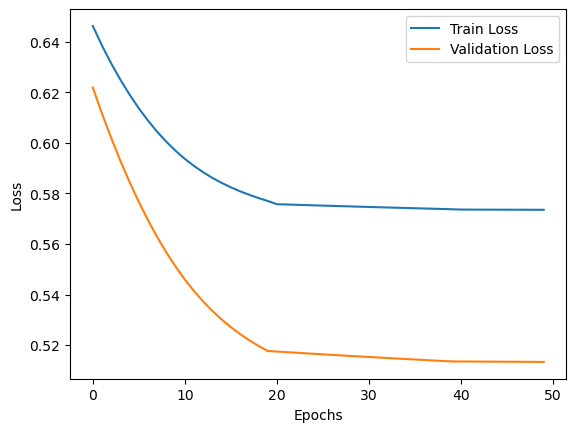

169/169 [==============================] - 1s 1ms/step
------------------------------------------------------------------------
Training for fold 4
Epoch 1/50
631/631 [==============================] - 5s 4ms/step - loss: 0.6812 - accuracy: 0.5669 - val_loss: 0.6538 - val_accuracy: 0.6665 - lr: 1.0000e-05
Epoch 2/50
631/631 [==============================] - 2s 4ms/step - loss: 0.6706 - accuracy: 0.6072 - val_loss: 0.6410 - val_accuracy: 0.7111 - lr: 1.0000e-05
Epoch 3/50
631/631 [==============================] - 3s 4ms/step - loss: 0.6616 - accuracy: 0.6375 - val_loss: 0.6296 - val_accuracy: 0.7448 - lr: 1.0000e-05
Epoch 4/50
631/631 [==============================] - 3s 4ms/step - loss: 0.6536 - accuracy: 0.6624 - val_loss: 0.6193 - val_accuracy: 0.7659 - lr: 1.0000e-05
Epoch 5/50
631/631 [==============================] - 2s 4ms/step - loss: 0.6464 - accuracy: 0.6834 - val_loss: 0.6099 - val_accuracy: 0.7826 - lr: 1.0000e-05
Epoch 6/50
631/631 [==============================] - 3s 

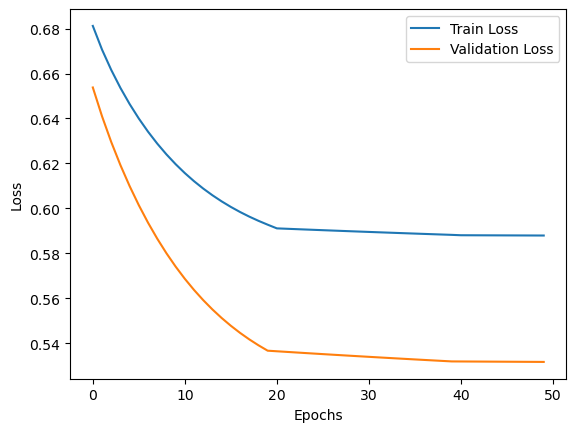

169/169 [==============================] - 1s 2ms/step
------------------------------------------------------------------------
Training for fold 5
Epoch 1/50
632/632 [==============================] - 6s 5ms/step - loss: 0.7053 - accuracy: 0.5229 - val_loss: 0.6829 - val_accuracy: 0.5943 - lr: 1.0000e-05
Epoch 2/50
632/632 [==============================] - 3s 4ms/step - loss: 0.6897 - accuracy: 0.5552 - val_loss: 0.6655 - val_accuracy: 0.6363 - lr: 1.0000e-05
Epoch 3/50
632/632 [==============================] - 3s 4ms/step - loss: 0.6758 - accuracy: 0.5867 - val_loss: 0.6497 - val_accuracy: 0.6787 - lr: 1.0000e-05
Epoch 4/50
632/632 [==============================] - 3s 4ms/step - loss: 0.6633 - accuracy: 0.6138 - val_loss: 0.6352 - val_accuracy: 0.7150 - lr: 1.0000e-05
Epoch 5/50
632/632 [==============================] - 3s 4ms/step - loss: 0.6519 - accuracy: 0.6385 - val_loss: 0.6220 - val_accuracy: 0.7411 - lr: 1.0000e-05
Epoch 6/50
632/632 [==============================] - 3s 

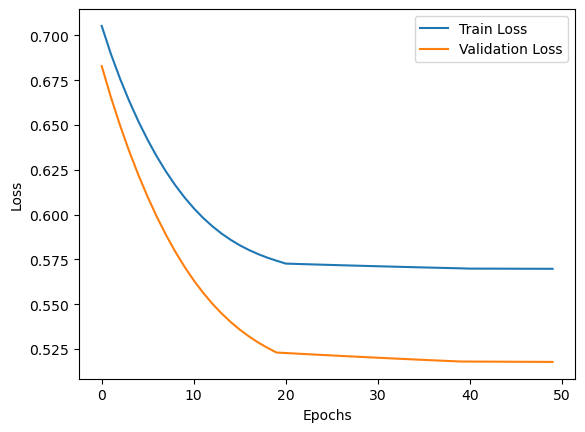

169/169 [==============================] - 1s 2ms/step
Accuracy: 0.791 (+/- 0.005)
Precision: 0.543 (+/- 0.022)
Recall: 0.340 (+/- 0.026)
F1 score: 0.418 (+/- 0.023)
AUC score: 0.630 (+/- 0.012)


In [ ]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
AUC_scores = []

fold_no = 1
for train_index, test_index in kf.split(X_train, y_train):
    X_train_dl, X_test_dl = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_dl, y_test_dl = y_train.iloc[train_index], y_train.iloc[test_index]

    # Perform preprocessing steps on X_train_dl
    X_train_dl_preprocessed = enc_dl.fit_transform(X_train_dl)
    X_test_dl_preprocessed = enc_dl.transform(X_test_dl)

    # Apply SMOTE and undersampling to address class imbalance
    from imblearn.pipeline import Pipeline
    over = SMOTE(sampling_strategy=0.4)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o',over),('u',under)]
    pipe = Pipeline(steps=steps)
        
    X_train_dl_resampled, y_train_dl_resampled =  pipe.fit_resample(X_train_dl_preprocessed, y_train_dl)
    
    round_cols = ['SEX','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6'] + X_train_dl_resampled.filter(like='EDUCATION').columns.to_list() + X_train_dl_resampled.filter(like='MARRIAGE').columns.to_list() 
    for col in round_cols:
        X_train_dl_resampled[col] = X_train_dl_resampled[col].round()
    
    # Split training data into static and temporal features
    # Perform any necessary reshaping or transformations
    temp_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
    'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
    'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
    'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    static_cols_train = X_train_dl_resampled.drop(temp_cols,axis=1).columns.to_list()
    static_cols_test = X_test_dl_preprocessed.drop(temp_cols,axis=1).columns.to_list()
    
    X_train_dl_temp = X_train_dl_resampled[temp_cols]
    X_train_dl_static = X_train_dl_resampled[static_cols_train]
    X_test_dl_temp = X_test_dl_preprocessed[temp_cols]
    X_test_dl_static = X_test_dl_preprocessed[static_cols_test]

    PAY_cols = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2','PAY_1']
    BILL_AMT_cols = ['BILL_AMT6','BILL_AMT5','BILL_AMT4','BILL_AMT3','BILL_AMT2','BILL_AMT1']
    PAY_AMT_cols = ['PAY_AMT6','PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
    
    PAY_train_dl = X_train_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_train_dl = X_train_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_train_dl = X_train_dl_temp[PAY_AMT_cols].to_numpy()
    
    PAY_test_dl = X_test_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_test_dl = X_test_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_test_dl = X_test_dl_temp[PAY_AMT_cols].to_numpy()   
    
    # Stack temporal features
    stacked_train = np.dstack((PAY_train_dl,BILL_AMT_train_dl,PAY_AMT_train_dl))
    stacked_test = np.dstack((PAY_test_dl,BILL_AMT_test_dl,PAY_AMT_test_dl))
    y_train_dl_resampled = y_train_dl_resampled.to_numpy()
    y_test_dl = y_test_dl.to_numpy()

    # Build and compile LSTM model
    num_time_steps, num_features = stacked_train.shape[1], stacked_train.shape[2]
    
    temporal_input = Input(shape=(num_time_steps, num_features),name = 'TEMPORAL_INPUT')
    static_input = Input(shape=(X_train_dl_static.shape[1]),name = 'STATIC_INPUT')

    lstm_layer = LSTM(16,return_sequences=True, name = 'LSTM_LAYER')(temporal_input)
    lstm_layer = Flatten(name = 'FLATTEN')(lstm_layer)
    
    static_layer = Dense(16, activation='relu')(static_input)

    combined = Concatenate(name ='CONCAT')([lstm_layer,static_layer])
    output = Dense(1,activation='sigmoid',name='OUTPUT_LAYER')(combined)

    model = Model(inputs=[temporal_input,static_input],outputs=[output])


    initial_learning_rate = 0.0001  # Initial learning rate
    decay_rate = 0.1  # Decay rate
    decay_steps = 20  # Decay steps (number of steps before applying decay)
    epochs = 55

    def learning_rate_scheduler(epoch):
        return initial_learning_rate * decay_rate ** (epoch // decay_steps)


    model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate=initial_learning_rate), metrics=['accuracy'])

    lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

    
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no}')
        

    
    #Train the model
    batch_size = 32    
  
    history = model.fit([stacked_train, X_train_dl_static], y_train_dl_resampled, epochs=epochs, batch_size=batch_size, validation_data=([stacked_test, X_test_dl_static], y_test_dl),shuffle=False,callbacks = [lr_scheduler])
    
    # Plot the loss on train vs validate tests
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Make predictions on the test set    
    y_pred_probs = model.predict([stacked_test, X_test_dl_static])
    y_pred = (y_pred_probs>=0.5).astype(int)    
    
    accuracy =  accuracy_score(y_test_dl,y_pred)
    precision = precision_score(y_test_dl,y_pred)
    recall = recall_score(y_test_dl,y_pred)
    f1 =  f1_score(y_test_dl,y_pred)
    AUC = roc_auc_score(y_test_dl,y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    AUC_scores.append(AUC)
    
    fold_no = fold_no + 1


# Calculate the average and standard deviation of the evaluation metrics
print('Accuracy: %.3f (+/- %.3f)' % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print('Precision: %.3f (+/- %.3f)' % (np.mean(precision_scores), np.std(precision_scores)))
print('Recall: %.3f (+/- %.3f)' % (np.mean(recall_scores), np.std(recall_scores)))
print('F1 score: %.3f (+/- %.3f)' % (np.mean(f1_scores), np.std(f1_scores)))
print('AUC score: %.3f (+/- %.3f)' % (np.mean(AUC_scores), np.std(AUC_scores)))

LSTM Temporal

* Accuracy: 0.777 (+/- 0.007)
* Precision: 0.496 (+/- 0.018)
* Recall: 0.383 (+/- 0.028)
* F1 score: 0.432 (+/- 0.021)
* AUC score: 0.636 (+/- 0.011)


In [ ]:
# Create a LogisticRegression object, max_iter=300 to remove the warning "ConvergenceWarning: lbfgs failed to converge (status=1)"
logreg2 = LogisticRegression(max_iter=300)

# Fit the model on the training data
logreg2.fit(X_train_dl_static, y_train_dl_resampled)

# Predict on the test data
y_predk = logreg2.predict(X_test_dl_static)

#Lower scores compared to the VIF solution 
print('Accuracy:', accuracy_score(y_test_dl,y_predk))
print('Precision:', precision_score(y_test_dl,y_predk))
print('Recall:', recall_score(y_test_dl,y_predk))
print('F1 score:', f1_score(y_test_dl,y_predk))

Accuracy: 0.765
Precision: 0.37362637362637363
Recall: 0.05560098119378577
F1 score: 0.09679715302491104


### RNN (Static + Temporal)

------------------------------------------------------------------------
Training for fold 1
Epoch 1/50
631/631 [==============================] - 3s 3ms/step - loss: 0.6635 - accuracy: 0.6338 - val_loss: 0.6070 - val_accuracy: 0.7446 - lr: 1.0000e-05
Epoch 2/50
631/631 [==============================] - 2s 3ms/step - loss: 0.6299 - accuracy: 0.6929 - val_loss: 0.5816 - val_accuracy: 0.7700 - lr: 1.0000e-05
Epoch 3/50
631/631 [==============================] - 2s 3ms/step - loss: 0.6107 - accuracy: 0.7112 - val_loss: 0.5649 - val_accuracy: 0.7794 - lr: 1.0000e-05
Epoch 4/50
631/631 [==============================] - 2s 3ms/step - loss: 0.5979 - accuracy: 0.7180 - val_loss: 0.5533 - val_accuracy: 0.7841 - lr: 1.0000e-05
Epoch 5/50
631/631 [==============================] - 2s 3ms/step - loss: 0.5888 - accuracy: 0.7222 - val_loss: 0.5450 - val_accuracy: 0.7857 - lr: 1.0000e-05
Epoch 6/50
631/631 [==============================] - 2s 3ms/step - loss: 0.5820 - accuracy: 0.7259 - val_loss: 

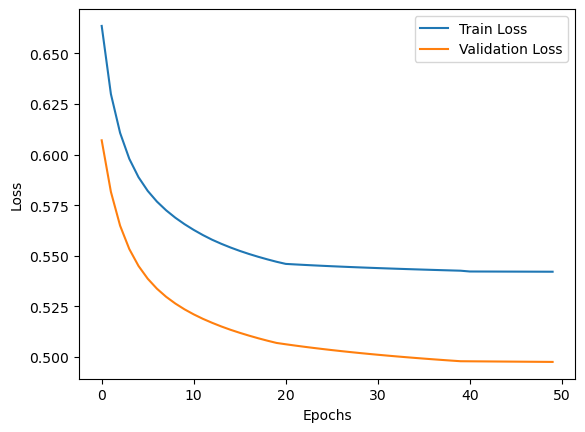

169/169 [==============================] - 0s 2ms/step
------------------------------------------------------------------------
Training for fold 2
Epoch 1/50
630/630 [==============================] - 3s 3ms/step - loss: 0.6929 - accuracy: 0.5393 - val_loss: 0.6435 - val_accuracy: 0.6613 - lr: 1.0000e-05
Epoch 2/50
630/630 [==============================] - 2s 3ms/step - loss: 0.6411 - accuracy: 0.6635 - val_loss: 0.5978 - val_accuracy: 0.7443 - lr: 1.0000e-05
Epoch 3/50
630/630 [==============================] - 2s 4ms/step - loss: 0.6132 - accuracy: 0.7060 - val_loss: 0.5701 - val_accuracy: 0.7691 - lr: 1.0000e-05
Epoch 4/50
630/630 [==============================] - 2s 4ms/step - loss: 0.5963 - accuracy: 0.7205 - val_loss: 0.5525 - val_accuracy: 0.7809 - lr: 1.0000e-05
Epoch 5/50
630/630 [==============================] - 2s 4ms/step - loss: 0.5853 - accuracy: 0.7291 - val_loss: 0.5408 - val_accuracy: 0.7870 - lr: 1.0000e-05
Epoch 6/50
630/630 [==============================] - 2s 

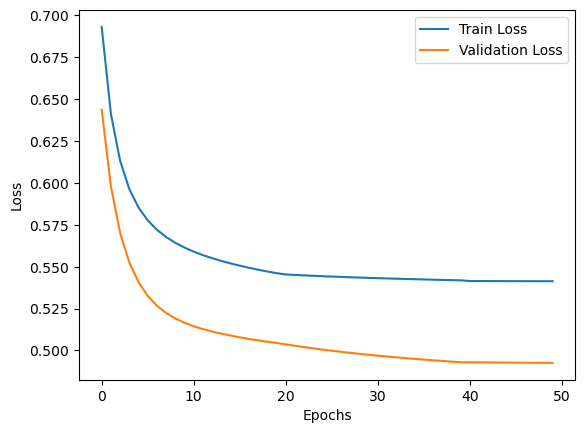

169/169 [==============================] - 0s 2ms/step
------------------------------------------------------------------------
Training for fold 3
Epoch 1/50
632/632 [==============================] - 3s 4ms/step - loss: 0.6125 - accuracy: 0.6960 - val_loss: 0.5252 - val_accuracy: 0.7920 - lr: 1.0000e-05
Epoch 2/50
632/632 [==============================] - 2s 3ms/step - loss: 0.5920 - accuracy: 0.7148 - val_loss: 0.5178 - val_accuracy: 0.7957 - lr: 1.0000e-05
Epoch 3/50
632/632 [==============================] - 2s 4ms/step - loss: 0.5822 - accuracy: 0.7193 - val_loss: 0.5138 - val_accuracy: 0.7996 - lr: 1.0000e-05
Epoch 4/50
632/632 [==============================] - 2s 3ms/step - loss: 0.5752 - accuracy: 0.7218 - val_loss: 0.5115 - val_accuracy: 0.7998 - lr: 1.0000e-05
Epoch 5/50
632/632 [==============================] - 2s 3ms/step - loss: 0.5700 - accuracy: 0.7248 - val_loss: 0.5101 - val_accuracy: 0.7991 - lr: 1.0000e-05
Epoch 6/50
632/632 [==============================] - 2s 

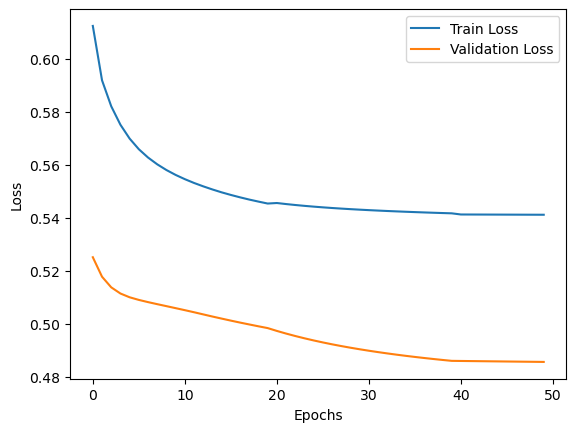

169/169 [==============================] - 0s 1ms/step
------------------------------------------------------------------------
Training for fold 4
Epoch 1/50
631/631 [==============================] - 3s 3ms/step - loss: 0.6210 - accuracy: 0.6892 - val_loss: 0.5344 - val_accuracy: 0.7835 - lr: 1.0000e-05
Epoch 2/50
631/631 [==============================] - 2s 3ms/step - loss: 0.6003 - accuracy: 0.7128 - val_loss: 0.5276 - val_accuracy: 0.7917 - lr: 1.0000e-05
Epoch 3/50
631/631 [==============================] - 2s 3ms/step - loss: 0.5901 - accuracy: 0.7212 - val_loss: 0.5233 - val_accuracy: 0.7924 - lr: 1.0000e-05
Epoch 4/50
631/631 [==============================] - 2s 3ms/step - loss: 0.5824 - accuracy: 0.7254 - val_loss: 0.5203 - val_accuracy: 0.7961 - lr: 1.0000e-05
Epoch 5/50
631/631 [==============================] - 2s 3ms/step - loss: 0.5764 - accuracy: 0.7290 - val_loss: 0.5183 - val_accuracy: 0.7943 - lr: 1.0000e-05
Epoch 6/50
631/631 [==============================] - 2s 

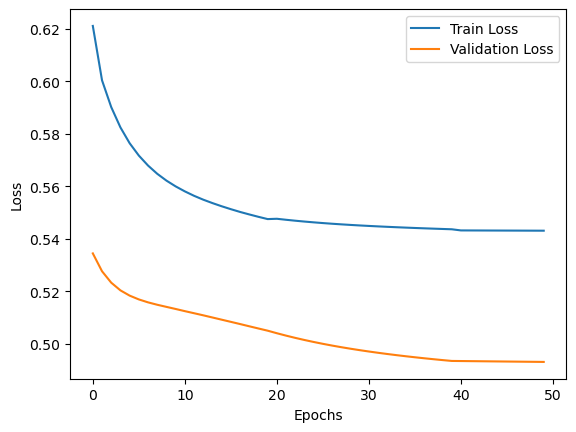

169/169 [==============================] - 0s 1ms/step
------------------------------------------------------------------------
Training for fold 5
Epoch 1/50
632/632 [==============================] - 3s 3ms/step - loss: 0.6743 - accuracy: 0.5983 - val_loss: 0.6278 - val_accuracy: 0.6822 - lr: 1.0000e-05
Epoch 2/50
632/632 [==============================] - 2s 3ms/step - loss: 0.6344 - accuracy: 0.6665 - val_loss: 0.5909 - val_accuracy: 0.7419 - lr: 1.0000e-05
Epoch 3/50
632/632 [==============================] - 2s 3ms/step - loss: 0.6110 - accuracy: 0.6958 - val_loss: 0.5678 - val_accuracy: 0.7648 - lr: 1.0000e-05
Epoch 4/50
632/632 [==============================] - 2s 3ms/step - loss: 0.5955 - accuracy: 0.7102 - val_loss: 0.5524 - val_accuracy: 0.7787 - lr: 1.0000e-05
Epoch 5/50
632/632 [==============================] - 2s 3ms/step - loss: 0.5845 - accuracy: 0.7180 - val_loss: 0.5417 - val_accuracy: 0.7844 - lr: 1.0000e-05
Epoch 6/50
632/632 [==============================] - 2s 

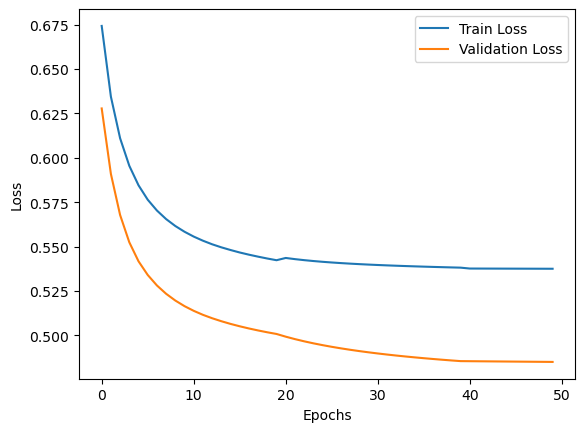

169/169 [==============================] - 0s 1ms/step
Accuracy: 0.804 (+/- 0.003)
Precision: 0.581 (+/- 0.014)
Recall: 0.411 (+/- 0.031)
F1 score: 0.481 (+/- 0.022)
AUC score: 0.663 (+/- 0.012)


In [ ]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
AUC_scores = []

fold_no = 1
for train_index, test_index in kf.split(X_train, y_train):
    X_train_dl, X_test_dl = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_dl, y_test_dl = y_train.iloc[train_index], y_train.iloc[test_index]

    # Perform preprocessing steps on X_train_dl
    X_train_dl_preprocessed = enc_dl.fit_transform(X_train_dl)
    X_test_dl_preprocessed = enc_dl.transform(X_test_dl)

    # Apply SMOTE and undersampling to address class imbalance
    from imblearn.pipeline import Pipeline
    over = SMOTE(sampling_strategy=0.4)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o',over),('u',under)]
    pipe = Pipeline(steps=steps)
        
    X_train_dl_resampled, y_train_dl_resampled =  pipe.fit_resample(X_train_dl_preprocessed, y_train_dl)
    
    round_cols = ['SEX','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6'] + X_train_dl_resampled.filter(like='EDUCATION').columns.to_list() + X_train_dl_resampled.filter(like='MARRIAGE').columns.to_list() 
    for col in round_cols:
        X_train_dl_resampled[col] = X_train_dl_resampled[col].round()
    
    # Split training data into static and temporal features
    # Perform any necessary reshaping or transformations
    temp_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
    'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
    'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
    'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    static_cols_train = X_train_dl_resampled.drop(temp_cols,axis=1).columns.to_list()
    static_cols_test = X_test_dl_preprocessed.drop(temp_cols,axis=1).columns.to_list()
    
    X_train_dl_temp = X_train_dl_resampled[temp_cols]
    X_train_dl_static = X_train_dl_resampled[static_cols_train]
    X_test_dl_temp = X_test_dl_preprocessed[temp_cols]
    X_test_dl_static = X_test_dl_preprocessed[static_cols_test]

    PAY_cols = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2','PAY_1']
    BILL_AMT_cols = ['BILL_AMT6','BILL_AMT5','BILL_AMT4','BILL_AMT3','BILL_AMT2','BILL_AMT1']
    PAY_AMT_cols = ['PAY_AMT6','PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
    
    PAY_train_dl = X_train_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_train_dl = X_train_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_train_dl = X_train_dl_temp[PAY_AMT_cols].to_numpy()
    
    PAY_test_dl = X_test_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_test_dl = X_test_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_test_dl = X_test_dl_temp[PAY_AMT_cols].to_numpy()   
    
    # Stack temporal features
    stacked_train = np.dstack((PAY_train_dl,BILL_AMT_train_dl,PAY_AMT_train_dl))
    stacked_test = np.dstack((PAY_test_dl,BILL_AMT_test_dl,PAY_AMT_test_dl))
    y_train_dl_resampled = y_train_dl_resampled.to_numpy()
    y_test_dl = y_test_dl.to_numpy()

    # Build and compile RNN model
    num_time_steps, num_features = stacked_train.shape[1], stacked_train.shape[2]
    
    temporal_input = Input(shape=(num_time_steps, num_features),name = 'TEMPORAL_INPUT')
    static_input = Input(shape=(X_train_dl_static.shape[1]),name = 'STATIC_INPUT')

    rnn_layer = SimpleRNN(16,return_sequences=True, name = 'RNN_LAYER')(temporal_input)
    rnn_layer = Flatten(name = 'FLATTEN')(rnn_layer)

    static_layer = Dense(32,activation='relu', name = 'DENSE_LAYER_1')(static_input)

    combined = Concatenate(axis=1, name ='CONCAT')([rnn_layer,static_layer])
    combined_dense = Dense(32,activation='relu',name = 'DENSE_CONC')(combined)
    output = Dense(1,activation='sigmoid',name='OUTPUT_LAYER')(combined_dense)

    rnn_conc_model = Model(inputs=[temporal_input,static_input],outputs=[output])


    initial_learning_rate = 0.00001  # Initial learning rate
    decay_rate = 0.1  # Decay rate
    decay_steps = 20  # Decay steps (number of steps before applying decay)
    epochs = 50

    def learning_rate_scheduler(epoch):
        return initial_learning_rate * decay_rate ** (epoch // decay_steps)


    rnn_conc_model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate=initial_learning_rate), metrics=['accuracy'])

    lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

    
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no}')
        

    
    #Train the model
    batch_size = 32    
  
    history = rnn_conc_model.fit([stacked_train, X_train_dl_static], y_train_dl_resampled, epochs=epochs, batch_size=batch_size, validation_data=([stacked_test, X_test_dl_static], y_test_dl),shuffle=False,callbacks = [lr_scheduler])
    
    # Plot the loss on train vs validate tests
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

    # Make predictions on the test set    
    y_pred_probs = rnn_conc_model.predict([stacked_test, X_test_dl_static])
    y_pred = (y_pred_probs>=0.5).astype(int)    
    
    accuracy =  accuracy_score(y_test_dl,y_pred)
    precision = precision_score(y_test_dl,y_pred)
    recall = recall_score(y_test_dl,y_pred)
    f1 =  f1_score(y_test_dl,y_pred)
    AUC = roc_auc_score(y_test_dl,y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    AUC_scores.append(AUC)
    
    fold_no = fold_no + 1


# Calculate the average and standard deviation of the evaluation metrics
print('Accuracy: %.3f (+/- %.3f)' % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print('Precision: %.3f (+/- %.3f)' % (np.mean(precision_scores), np.std(precision_scores)))
print('Recall: %.3f (+/- %.3f)' % (np.mean(recall_scores), np.std(recall_scores)))
print('F1 score: %.3f (+/- %.3f)' % (np.mean(f1_scores), np.std(f1_scores)))
print('AUC score: %.3f (+/- %.3f)' % (np.mean(AUC_scores), np.std(AUC_scores)))

RNN Temporal

* Accuracy: 0.772 (+/- 0.013)
* Precision: 0.486 (+/- 0.028)
* Recall: 0.440 (+/- 0.019)
* F1 score: 0.461 (+/- 0.015)
* AUC score: 0.653 (+/- 0.009)


### CNN (Static + Temporal)

------------------------------------------------------------------------
Training for fold 1
Epoch 1/50
631/631 [==============================] - 4s 5ms/step - loss: 0.8270 - accuracy: 0.3904 - val_loss: 0.7598 - val_accuracy: 0.3224 - lr: 1.0000e-05
Epoch 2/50
631/631 [==============================] - 3s 5ms/step - loss: 0.7674 - accuracy: 0.4450 - val_loss: 0.7060 - val_accuracy: 0.4539 - lr: 1.0000e-05
Epoch 3/50
631/631 [==============================] - 4s 7ms/step - loss: 0.7331 - accuracy: 0.4869 - val_loss: 0.6720 - val_accuracy: 0.5572 - lr: 1.0000e-05
Epoch 4/50
631/631 [==============================] - 4s 7ms/step - loss: 0.7069 - accuracy: 0.5289 - val_loss: 0.6468 - val_accuracy: 0.6235 - lr: 1.0000e-05
Epoch 5/50
631/631 [==============================] - 3s 6ms/step - loss: 0.6902 - accuracy: 0.5678 - val_loss: 0.6284 - val_accuracy: 0.6733 - lr: 1.0000e-05
Epoch 6/50
631/631 [==============================] - 3s 4ms/step - loss: 0.6777 - accuracy: 0.5950 - val_loss: 

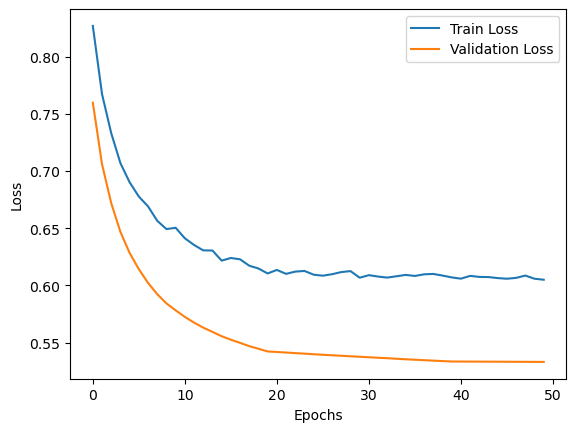

169/169 [==============================] - 0s 1ms/step
------------------------------------------------------------------------
Training for fold 2
Epoch 1/50
630/630 [==============================] - 5s 7ms/step - loss: 0.8880 - accuracy: 0.4118 - val_loss: 0.7290 - val_accuracy: 0.4606 - lr: 1.0000e-05
Epoch 2/50
630/630 [==============================] - 14s 22ms/step - loss: 0.8222 - accuracy: 0.4701 - val_loss: 0.6690 - val_accuracy: 0.6789 - lr: 1.0000e-05
Epoch 3/50
630/630 [==============================] - 3s 4ms/step - loss: 0.7700 - accuracy: 0.5381 - val_loss: 0.6313 - val_accuracy: 0.7711 - lr: 1.0000e-05
Epoch 4/50
630/630 [==============================] - 3s 4ms/step - loss: 0.7395 - accuracy: 0.5811 - val_loss: 0.6081 - val_accuracy: 0.7824 - lr: 1.0000e-05
Epoch 5/50
630/630 [==============================] - 3s 4ms/step - loss: 0.7145 - accuracy: 0.6087 - val_loss: 0.5929 - val_accuracy: 0.7831 - lr: 1.0000e-05
Epoch 6/50
630/630 [==============================] - 3

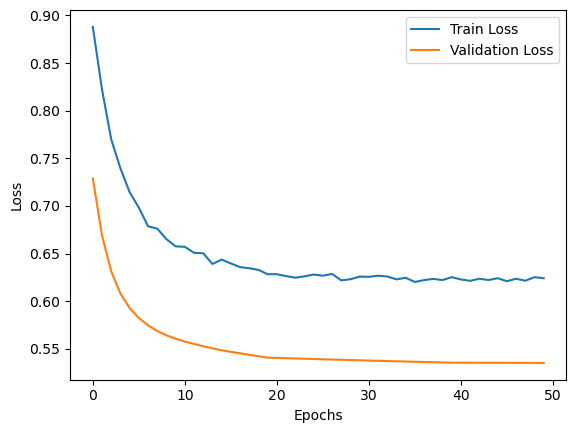

169/169 [==============================] - 0s 1ms/step
------------------------------------------------------------------------
Training for fold 3
Epoch 1/50
632/632 [==============================] - 6s 8ms/step - loss: 0.7693 - accuracy: 0.4774 - val_loss: 0.7025 - val_accuracy: 0.4900 - lr: 1.0000e-05
Epoch 2/50
632/632 [==============================] - 6s 9ms/step - loss: 0.7535 - accuracy: 0.5049 - val_loss: 0.6849 - val_accuracy: 0.5187 - lr: 1.0000e-05
Epoch 3/50
632/632 [==============================] - 3s 4ms/step - loss: 0.7341 - accuracy: 0.5249 - val_loss: 0.6700 - val_accuracy: 0.5448 - lr: 1.0000e-05
Epoch 4/50
632/632 [==============================] - 3s 5ms/step - loss: 0.7254 - accuracy: 0.5422 - val_loss: 0.6584 - val_accuracy: 0.5704 - lr: 1.0000e-05
Epoch 5/50
632/632 [==============================] - 3s 5ms/step - loss: 0.7171 - accuracy: 0.5540 - val_loss: 0.6479 - val_accuracy: 0.5948 - lr: 1.0000e-05
Epoch 6/50
632/632 [==============================] - 3s 

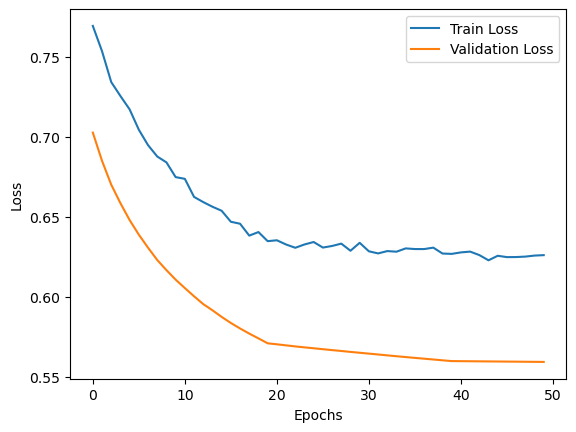

169/169 [==============================] - 0s 2ms/step
------------------------------------------------------------------------
Training for fold 4
Epoch 1/50
631/631 [==============================] - 6s 8ms/step - loss: 0.7506 - accuracy: 0.4548 - val_loss: 0.6918 - val_accuracy: 0.4741 - lr: 1.0000e-05
Epoch 2/50
631/631 [==============================] - 4s 6ms/step - loss: 0.7198 - accuracy: 0.4966 - val_loss: 0.6616 - val_accuracy: 0.5502 - lr: 1.0000e-05
Epoch 3/50
631/631 [==============================] - 3s 4ms/step - loss: 0.7041 - accuracy: 0.5426 - val_loss: 0.6395 - val_accuracy: 0.6374 - lr: 1.0000e-05
Epoch 4/50
631/631 [==============================] - 3s 5ms/step - loss: 0.6917 - accuracy: 0.5723 - val_loss: 0.6231 - val_accuracy: 0.6974 - lr: 1.0000e-05
Epoch 5/50
631/631 [==============================] - 3s 5ms/step - loss: 0.6782 - accuracy: 0.6016 - val_loss: 0.6114 - val_accuracy: 0.7267 - lr: 1.0000e-05
Epoch 6/50
631/631 [==============================] - 3s 

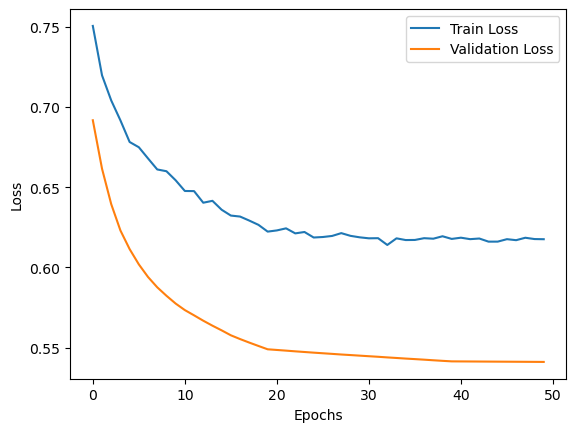

169/169 [==============================] - 0s 1ms/step
------------------------------------------------------------------------
Training for fold 5
Epoch 1/50
632/632 [==============================] - 6s 9ms/step - loss: 0.7742 - accuracy: 0.5628 - val_loss: 0.6160 - val_accuracy: 0.7581 - lr: 1.0000e-05
Epoch 2/50
632/632 [==============================] - 3s 4ms/step - loss: 0.7415 - accuracy: 0.5937 - val_loss: 0.5968 - val_accuracy: 0.7704 - lr: 1.0000e-05
Epoch 3/50
632/632 [==============================] - 5s 9ms/step - loss: 0.7134 - accuracy: 0.6186 - val_loss: 0.5855 - val_accuracy: 0.7724 - lr: 1.0000e-05
Epoch 4/50
632/632 [==============================] - 6s 9ms/step - loss: 0.6924 - accuracy: 0.6335 - val_loss: 0.5783 - val_accuracy: 0.7746 - lr: 1.0000e-05
Epoch 5/50
632/632 [==============================] - 4s 7ms/step - loss: 0.6882 - accuracy: 0.6450 - val_loss: 0.5729 - val_accuracy: 0.7765 - lr: 1.0000e-05
Epoch 6/50
632/632 [==============================] - 3s 

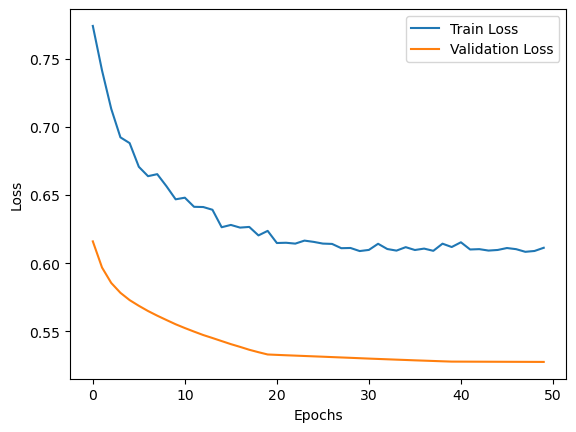

169/169 [==============================] - 0s 1ms/step
Accuracy: 0.804 (+/- 0.004)
Precision: 0.569 (+/- 0.016)
Recall: 0.476 (+/- 0.011)
F1 score: 0.518 (+/- 0.012)
AUC score: 0.687 (+/- 0.006)


In [ ]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
AUC_scores = []

fold_no = 1
for train_index, test_index in kf.split(X_train, y_train):
    X_train_dl, X_test_dl = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_dl, y_test_dl = y_train.iloc[train_index], y_train.iloc[test_index]

    # Perform preprocessing steps on X_train_dl
    X_train_dl_preprocessed = enc_dl.fit_transform(X_train_dl)
    X_test_dl_preprocessed = enc_dl.transform(X_test_dl)

    # Apply SMOTE and undersampling to address class imbalance
    from imblearn.pipeline import Pipeline
    over = SMOTE(sampling_strategy=0.4)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o',over),('u',under)]
    pipe = Pipeline(steps=steps)
        
    X_train_dl_resampled, y_train_dl_resampled =  pipe.fit_resample(X_train_dl_preprocessed, y_train_dl)
    
    round_cols = ['SEX','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6'] + X_train_dl_resampled.filter(like='EDUCATION').columns.to_list() + X_train_dl_resampled.filter(like='MARRIAGE').columns.to_list() 
    for col in round_cols:
        X_train_dl_resampled[col] = X_train_dl_resampled[col].round()
    
    # Split training data into static and temporal features
    # Perform any necessary reshaping or transformations
    temp_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
    'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
    'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
    'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    static_cols_train = X_train_dl_resampled.drop(temp_cols,axis=1).columns.to_list()
    static_cols_test = X_test_dl_preprocessed.drop(temp_cols,axis=1).columns.to_list()
    
    X_train_dl_temp = X_train_dl_resampled[temp_cols]
    X_train_dl_static = X_train_dl_resampled[static_cols_train]
    X_test_dl_temp = X_test_dl_preprocessed[temp_cols]
    X_test_dl_static = X_test_dl_preprocessed[static_cols_test]

    PAY_cols = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2','PAY_1']
    BILL_AMT_cols = ['BILL_AMT6','BILL_AMT5','BILL_AMT4','BILL_AMT3','BILL_AMT2','BILL_AMT1']
    PAY_AMT_cols = ['PAY_AMT6','PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
    
    PAY_train_dl = X_train_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_train_dl = X_train_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_train_dl = X_train_dl_temp[PAY_AMT_cols].to_numpy()
    
    PAY_test_dl = X_test_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_test_dl = X_test_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_test_dl = X_test_dl_temp[PAY_AMT_cols].to_numpy()   
    
    # Stack temporal features
    stacked_train = np.dstack((PAY_train_dl,BILL_AMT_train_dl,PAY_AMT_train_dl))
    stacked_test = np.dstack((PAY_test_dl,BILL_AMT_test_dl,PAY_AMT_test_dl))
    y_train_dl_resampled = y_train_dl_resampled.to_numpy()
    y_test_dl = y_test_dl.to_numpy()

    # Build and compile CNN model
    num_time_steps, num_features = stacked_train.shape[1], stacked_train.shape[2]
    
    temporal_input = Input(shape=(num_time_steps, num_features),name = 'TEMPORAL_INPUT')
    static_input = Input(shape=(X_train_dl_static.shape[1]),name = 'STATIC_INPUT')
    
    # CNN layers
    cnn_layer = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(temporal_input)
    cnn_layer = MaxPooling1D(pool_size=3)(cnn_layer)
    cnn_layer = Conv1D(filters=32, padding='same', kernel_size=2, activation='relu')(cnn_layer)
    cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
    cnn_layer = Flatten()(cnn_layer)
    cnn_layer = Dropout(0.7)(cnn_layer)

    static_layer = Dense(32,activation='relu', name = 'DENSE_LAYER_1')(static_input)

    combined = Concatenate(axis=1, name ='CONCAT')([cnn_layer,static_layer])
    combined_dense = Dense(32,activation='relu',name = 'DENSE_CONC')(combined)
    output = Dense(1,activation='sigmoid',name='OUTPUT_LAYER')(combined_dense)

    cnn_conc_model = Model(inputs=[temporal_input,static_input],outputs=[output])
    
    initial_learning_rate = 0.00001  # Initial learning rate
    decay_rate = 0.1  # Decay rate
    decay_steps = 20  # Decay steps (number of steps before applying decay)
    epochs = 50

    def learning_rate_scheduler(epoch):
        return initial_learning_rate * decay_rate ** (epoch // decay_steps)


    cnn_conc_model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate=initial_learning_rate), metrics=['accuracy'])

    lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

    
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no}')
        

    
    #Train the model
    batch_size = 32    
  
    history = cnn_conc_model.fit([stacked_train, X_train_dl_static], y_train_dl_resampled, epochs=epochs, batch_size=batch_size, validation_data=([stacked_test, X_test_dl_static], y_test_dl),shuffle=False,callbacks = [lr_scheduler])
    
    # Plot the loss on train vs validate tests
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

    # Make predictions on the test set    
    y_pred_probs = cnn_conc.predict([stacked_test, X_test_dl_static])
    y_pred = (y_pred_probs>=0.5).astype(int)    
    
    accuracy =  accuracy_score(y_test_dl,y_pred)
    precision = precision_score(y_test_dl,y_pred)
    recall = recall_score(y_test_dl,y_pred)
    f1 =  f1_score(y_test_dl,y_pred)
    AUC = roc_auc_score(y_test_dl,y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    AUC_scores.append(AUC)
    
    fold_no = fold_no + 1


# Calculate the average and standard deviation of the evaluation metrics
print('Accuracy: %.3f (+/- %.3f)' % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print('Precision: %.3f (+/- %.3f)' % (np.mean(precision_scores), np.std(precision_scores)))
print('Recall: %.3f (+/- %.3f)' % (np.mean(recall_scores), np.std(recall_scores)))
print('F1 score: %.3f (+/- %.3f)' % (np.mean(f1_scores), np.std(f1_scores)))
print('AUC score: %.3f (+/- %.3f)' % (np.mean(AUC_scores), np.std(AUC_scores)))

CNN Temporal

* Accuracy: 0.798 (+/- 0.008)
* Precision: 0.577 (+/- 0.031)
* Recall: 0.324 (+/- 0.033)
* F1 score: 0.414 (+/- 0.034)
* AUC score: 0.628 (+/- 0.017

## CNN + XGB

In [ ]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
AUC_scores = []

fold_no = 1
for train_index, test_index in kf.split(X_train, y_train):
    X_train_dl, X_test_dl = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_dl, y_test_dl = y_train.iloc[train_index], y_train.iloc[test_index]

    # Perform preprocessing steps on X_train_dl
    X_train_dl_preprocessed = enc_dl.fit_transform(X_train_dl)
    X_test_dl_preprocessed = enc_dl.transform(X_test_dl)

    # Apply SMOTE and undersampling to address class imbalance
    from imblearn.pipeline import Pipeline
    over = SMOTE(sampling_strategy=0.4)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o',over),('u',under)]
    pipe = Pipeline(steps=steps)
        
    X_train_dl_resampled, y_train_dl_resampled =  pipe.fit_resample(X_train_dl_preprocessed, y_train_dl)
    
    round_cols = ['SEX','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6'] + X_train_dl_resampled.filter(like='EDUCATION').columns.to_list() + X_train_dl_resampled.filter(like='MARRIAGE').columns.to_list() 
    for col in round_cols:
        X_train_dl_resampled[col] = X_train_dl_resampled[col].round()
    
    # Split training data into static and temporal features
    # Perform any necessary reshaping or transformations
    temp_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
    'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
    'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
    'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    static_cols_train = X_train_dl_resampled.drop(temp_cols,axis=1).columns.to_list()
    static_cols_test = X_test_dl_preprocessed.drop(temp_cols,axis=1).columns.to_list()
    
    X_train_dl_temp = X_train_dl_resampled[temp_cols]
    X_train_dl_static = X_train_dl_resampled[static_cols_train]
    X_test_dl_temp = X_test_dl_preprocessed[temp_cols]
    X_test_dl_static = X_test_dl_preprocessed[static_cols_test]

    PAY_cols = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2','PAY_1']
    BILL_AMT_cols = ['BILL_AMT6','BILL_AMT5','BILL_AMT4','BILL_AMT3','BILL_AMT2','BILL_AMT1']
    PAY_AMT_cols = ['PAY_AMT6','PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
    
    PAY_train_dl = X_train_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_train_dl = X_train_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_train_dl = X_train_dl_temp[PAY_AMT_cols].to_numpy()
    
    PAY_test_dl = X_test_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_test_dl = X_test_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_test_dl = X_test_dl_temp[PAY_AMT_cols].to_numpy()   
    
    # Stack temporal features
    stacked_train = np.dstack((PAY_train_dl,BILL_AMT_train_dl,PAY_AMT_train_dl))
    stacked_test = np.dstack((PAY_test_dl,BILL_AMT_test_dl,PAY_AMT_test_dl))
    y_train_dl_resampled = y_train_dl_resampled.to_numpy()
    y_test_dl = y_test_dl.to_numpy()

    # Build and compile CNN model
    num_time_steps, num_features = stacked_train.shape[1], stacked_train.shape[2]

    # Define the CNN layer
    cnn_input = Input(shape=(num_time_steps, num_features), name='CNN_INPUT')
    cnn_layer = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(cnn_input)
    cnn_layer = MaxPooling1D(pool_size=3)(cnn_layer)
    cnn_layer = Conv1D(filters=32, padding='same', kernel_size=2, activation='relu')(cnn_layer)
    cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
    cnn_layer = Flatten()(cnn_layer)

    # Concatenate the CNN output with the static input
    combined = Concatenate(name='CONCAT')([cnn_layer, static_input])
    
    # Extract features from LSTM
    feature_extractor_model = Model(inputs=[cnn_input, static_input], outputs=[combined])
    extracted_features_train = feature_extractor_model.predict([stacked_train, X_train_dl_static])
    extracted_features_test = feature_extractor_model.predict([stacked_test, X_test_dl_static])
    
    # Train an XGBoost classifier
    xgb_model = XGBClassifier()
    xgb_model.fit(extracted_features_train, y_train_dl_resampled)
    
    y_pred = xgb_model.predict(extracted_features_test) 
    
    accuracy =  accuracy_score(y_test_dl,y_pred)
    precision = precision_score(y_test_dl,y_pred)
    recall = recall_score(y_test_dl,y_pred)
    f1 =  f1_score(y_test_dl,y_pred)
    AUC = roc_auc_score(y_test_dl,y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    AUC_scores.append(AUC)
    
    fold_no = fold_no + 1


# Calculate the average and standard deviation of the evaluation metrics
print('Accuracy: %.3f (+/- %.3f)' % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print('Precision: %.3f (+/- %.3f)' % (np.mean(precision_scores), np.std(precision_scores)))
print('Recall: %.3f (+/- %.3f)' % (np.mean(recall_scores), np.std(recall_scores)))
print('F1 score: %.3f (+/- %.3f)' % (np.mean(f1_scores), np.std(f1_scores)))
print('AUC score: %.3f (+/- %.3f)' % (np.mean(AUC_scores), np.std(AUC_scores)))

169/169 [==============================] - 0s 1ms/step
Accuracy: 0.792 (+/- 0.005)
Precision: 0.536 (+/- 0.019)
Recall: 0.437 (+/- 0.012)
F1 score: 0.481 (+/- 0.015)
AUC score: 0.665 (+/- 0.008)


In [ ]:
print(combined)

KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='CONCAT/concat:0', description="created by layer 'CONCAT'")


## LSTM + XGB

In [ ]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
AUC_scores = []

fold_no = 1
for train_index, test_index in kf.split(X_train, y_train):
    X_train_dl, X_test_dl = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_dl, y_test_dl = y_train.iloc[train_index], y_train.iloc[test_index]

    # Perform preprocessing steps on X_train_dl
    X_train_dl_preprocessed = enc_dl.fit_transform(X_train_dl)
    X_test_dl_preprocessed = enc_dl.transform(X_test_dl)

    # Apply SMOTE and undersampling to address class imbalance
    from imblearn.pipeline import Pipeline
    over = SMOTE(sampling_strategy=0.4)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o',over),('u',under)]
    pipe = Pipeline(steps=steps)
        
    X_train_dl_resampled, y_train_dl_resampled =  pipe.fit_resample(X_train_dl_preprocessed, y_train_dl)
    
    round_cols = ['SEX','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6'] + X_train_dl_resampled.filter(like='EDUCATION').columns.to_list() + X_train_dl_resampled.filter(like='MARRIAGE').columns.to_list() 
    for col in round_cols:
        X_train_dl_resampled[col] = X_train_dl_resampled[col].round()
    
    # Split training data into static and temporal features
    # Perform any necessary reshaping or transformations
    temp_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
    'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
    'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
    'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    static_cols_train = X_train_dl_resampled.drop(temp_cols,axis=1).columns.to_list()
    static_cols_test = X_test_dl_preprocessed.drop(temp_cols,axis=1).columns.to_list()
    
    X_train_dl_temp = X_train_dl_resampled[temp_cols]
    X_train_dl_static = X_train_dl_resampled[static_cols_train]
    X_test_dl_temp = X_test_dl_preprocessed[temp_cols]
    X_test_dl_static = X_test_dl_preprocessed[static_cols_test]

    PAY_cols = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2','PAY_1']
    BILL_AMT_cols = ['BILL_AMT6','BILL_AMT5','BILL_AMT4','BILL_AMT3','BILL_AMT2','BILL_AMT1']
    PAY_AMT_cols = ['PAY_AMT6','PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
    
    PAY_train_dl = X_train_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_train_dl = X_train_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_train_dl = X_train_dl_temp[PAY_AMT_cols].to_numpy()
    
    PAY_test_dl = X_test_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_test_dl = X_test_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_test_dl = X_test_dl_temp[PAY_AMT_cols].to_numpy()   
    
    # Stack temporal features
    stacked_train = np.dstack((PAY_train_dl,BILL_AMT_train_dl,PAY_AMT_train_dl))
    stacked_test = np.dstack((PAY_test_dl,BILL_AMT_test_dl,PAY_AMT_test_dl))
    y_train_dl_resampled = y_train_dl_resampled.to_numpy()
    y_test_dl = y_test_dl.to_numpy()

    # Build and compile LSTM model
    num_time_steps, num_features = stacked_train.shape[1], stacked_train.shape[2]
    
    temporal_input = Input(shape=(num_time_steps, num_features),name = 'TEMPORAL_INPUT')
    static_input = Input(shape=(X_train_dl_static.shape[1]),name = 'STATIC_INPUT')

    lstm_layer = LSTM(16,return_sequences=True, name = 'LSTM_LAYER')(temporal_input)
    lstm_flat = Flatten(name = 'FLATTEN')(lstm_layer)
    
    combined = Concatenate(name ='CONCAT')([lstm_flat,static_input])
    
    # Extract features from LSTM
    feature_extractor_model = Model(inputs=[temporal_input, static_input], outputs=[combined])
    extracted_features_train = feature_extractor_model.predict([stacked_train, X_train_dl_static])
    extracted_features_test = feature_extractor_model.predict([stacked_test, X_test_dl_static])
    
    # Train an XGBoost classifier
    xgb_model = XGBClassifier()
    xgb_model.fit(extracted_features_train, y_train_dl_resampled)
    
    y_pred = xgb_model.predict(extracted_features_test) 
    
    accuracy =  accuracy_score(y_test_dl,y_pred)
    precision = precision_score(y_test_dl,y_pred)
    recall = recall_score(y_test_dl,y_pred)
    f1 =  f1_score(y_test_dl,y_pred)
    AUC = roc_auc_score(y_test_dl,y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    AUC_scores.append(AUC)
    
    fold_no = fold_no + 1


# Calculate the average and standard deviation of the evaluation metrics
print('Accuracy: %.3f (+/- %.3f)' % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print('Precision: %.3f (+/- %.3f)' % (np.mean(precision_scores), np.std(precision_scores)))
print('Recall: %.3f (+/- %.3f)' % (np.mean(recall_scores), np.std(recall_scores)))
print('F1 score: %.3f (+/- %.3f)' % (np.mean(f1_scores), np.std(f1_scores)))
print('AUC score: %.3f (+/- %.3f)' % (np.mean(AUC_scores), np.std(AUC_scores)))

169/169 [==============================] - 0s 2ms/step
Accuracy: 0.794 (+/- 0.005)
Precision: 0.544 (+/- 0.021)
Recall: 0.436 (+/- 0.013)
F1 score: 0.484 (+/- 0.013)
AUC score: 0.666 (+/- 0.007)


## RNN + XGB

In [ ]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
AUC_scores = []

fold_no = 1
for train_index, test_index in kf.split(X_train, y_train):
    X_train_dl, X_test_dl = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_dl, y_test_dl = y_train.iloc[train_index], y_train.iloc[test_index]

    # Perform preprocessing steps on X_train_dl
    X_train_dl_preprocessed = enc_dl.fit_transform(X_train_dl)
    X_test_dl_preprocessed = enc_dl.transform(X_test_dl)

    # Apply SMOTE and undersampling to address class imbalance
    from imblearn.pipeline import Pipeline
    over = SMOTE(sampling_strategy=0.4)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o',over),('u',under)]
    pipe = Pipeline(steps=steps)
        
    X_train_dl_resampled, y_train_dl_resampled =  pipe.fit_resample(X_train_dl_preprocessed, y_train_dl)
    
    round_cols = ['SEX','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6'] + X_train_dl_resampled.filter(like='EDUCATION').columns.to_list() + X_train_dl_resampled.filter(like='MARRIAGE').columns.to_list() 
    for col in round_cols:
        X_train_dl_resampled[col] = X_train_dl_resampled[col].round()
    
    # Split training data into static and temporal features
    # Perform any necessary reshaping or transformations
    temp_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
    'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
    'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
    'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    static_cols_train = X_train_dl_resampled.drop(temp_cols,axis=1).columns.to_list()
    static_cols_test = X_test_dl_preprocessed.drop(temp_cols,axis=1).columns.to_list()
    
    X_train_dl_temp = X_train_dl_resampled[temp_cols]
    X_train_dl_static = X_train_dl_resampled[static_cols_train]
    X_test_dl_temp = X_test_dl_preprocessed[temp_cols]
    X_test_dl_static = X_test_dl_preprocessed[static_cols_test]

    PAY_cols = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2','PAY_1']
    BILL_AMT_cols = ['BILL_AMT6','BILL_AMT5','BILL_AMT4','BILL_AMT3','BILL_AMT2','BILL_AMT1']
    PAY_AMT_cols = ['PAY_AMT6','PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
    
    PAY_train_dl = X_train_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_train_dl = X_train_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_train_dl = X_train_dl_temp[PAY_AMT_cols].to_numpy()
    
    PAY_test_dl = X_test_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_test_dl = X_test_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_test_dl = X_test_dl_temp[PAY_AMT_cols].to_numpy()   
    
    # Stack temporal features
    stacked_train = np.dstack((PAY_train_dl,BILL_AMT_train_dl,PAY_AMT_train_dl))
    stacked_test = np.dstack((PAY_test_dl,BILL_AMT_test_dl,PAY_AMT_test_dl))
    y_train_dl_resampled = y_train_dl_resampled.to_numpy()
    y_test_dl = y_test_dl.to_numpy()

    # Build and compile CNN model
    num_time_steps, num_features = stacked_train.shape[1], stacked_train.shape[2]
    
    temporal_input = Input(shape=(num_time_steps, num_features),name = 'TEMPORAL_INPUT')
    static_input = Input(shape=(X_train_dl_static.shape[1]),name = 'STATIC_INPUT')

    rnn_layer = SimpleRNN(16,return_sequences=True, name = 'RNN_LAYER')(temporal_input)
    rnn_flat = Flatten(name = 'FLATTEN')(rnn_layer)
    
    combined = Concatenate(name ='CONCAT')([rnn_flat,static_input])
    
    # Extract features from LSTM
    feature_extractor_model = Model(inputs=[temporal_input, static_input], outputs=[combined])
    extracted_features_train = feature_extractor_model.predict([stacked_train, X_train_dl_static])
    extracted_features_test = feature_extractor_model.predict([stacked_test, X_test_dl_static])
    
    # Train an XGBoost classifier
    xgb_model = XGBClassifier()
    xgb_model.fit(extracted_features_train, y_train_dl_resampled)
    
    y_pred = xgb_model.predict(extracted_features_test) 
    
    accuracy =  accuracy_score(y_test_dl,y_pred)
    precision = precision_score(y_test_dl,y_pred)
    recall = recall_score(y_test_dl,y_pred)
    f1 =  f1_score(y_test_dl,y_pred)
    AUC = roc_auc_score(y_test_dl,y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    AUC_scores.append(AUC)
    
    fold_no = fold_no + 1


# Calculate the average and standard deviation of the evaluation metrics
print('Accuracy: %.3f (+/- %.3f)' % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print('Precision: %.3f (+/- %.3f)' % (np.mean(precision_scores), np.std(precision_scores)))
print('Recall: %.3f (+/- %.3f)' % (np.mean(recall_scores), np.std(recall_scores)))
print('F1 score: %.3f (+/- %.3f)' % (np.mean(f1_scores), np.std(f1_scores)))
print('AUC score: %.3f (+/- %.3f)' % (np.mean(AUC_scores), np.std(AUC_scores)))

169/169 [==============================] - 0s 2ms/step
Accuracy: 0.795 (+/- 0.003)
Precision: 0.546 (+/- 0.015)
Recall: 0.443 (+/- 0.010)
F1 score: 0.489 (+/- 0.009)
AUC score: 0.669 (+/- 0.005)


## Hyper parameter tuning DL

In [ ]:
from keras import optimizers

------------------------------------------------------------------------
Training for fold 1
Epoch 1/50
631/631 [==============================] - 10s 9ms/step - loss: 0.7018 - accuracy: 0.4146 - val_loss: 0.7034 - val_accuracy: 0.3869 - lr: 1.0000e-05
Epoch 2/50
631/631 [==============================] - 4s 7ms/step - loss: 0.7010 - accuracy: 0.4187 - val_loss: 0.7023 - val_accuracy: 0.3907 - lr: 1.0000e-05
Epoch 3/50
631/631 [==============================] - 4s 7ms/step - loss: 0.7001 - accuracy: 0.4223 - val_loss: 0.7012 - val_accuracy: 0.3952 - lr: 1.0000e-05
Epoch 4/50
631/631 [==============================] - 4s 7ms/step - loss: 0.6993 - accuracy: 0.4258 - val_loss: 0.7001 - val_accuracy: 0.4000 - lr: 1.0000e-05
Epoch 5/50
631/631 [==============================] - 4s 7ms/step - loss: 0.6985 - accuracy: 0.4286 - val_loss: 0.6990 - val_accuracy: 0.4056 - lr: 1.0000e-05
Epoch 6/50
631/631 [==============================] - 5s 7ms/step - loss: 0.6977 - accuracy: 0.4327 - val_loss:

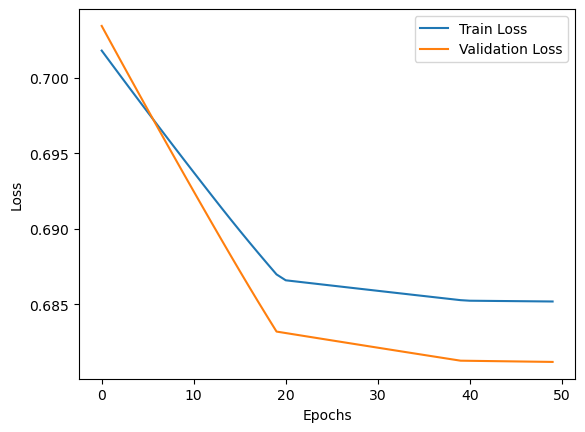

169/169 [==============================] - 1s 2ms/step
------------------------------------------------------------------------
Training for fold 2
Epoch 1/50
630/630 [==============================] - 6s 5ms/step - loss: 0.6407 - accuracy: 0.6559 - val_loss: 0.6272 - val_accuracy: 0.6789 - lr: 1.0000e-05
Epoch 2/50
630/630 [==============================] - 3s 5ms/step - loss: 0.6404 - accuracy: 0.6573 - val_loss: 0.6266 - val_accuracy: 0.6809 - lr: 1.0000e-05
Epoch 3/50
630/630 [==============================] - 3s 4ms/step - loss: 0.6401 - accuracy: 0.6582 - val_loss: 0.6261 - val_accuracy: 0.6828 - lr: 1.0000e-05
Epoch 4/50
630/630 [==============================] - 3s 4ms/step - loss: 0.6398 - accuracy: 0.6589 - val_loss: 0.6256 - val_accuracy: 0.6844 - lr: 1.0000e-05
Epoch 5/50
630/630 [==============================] - 3s 4ms/step - loss: 0.6395 - accuracy: 0.6600 - val_loss: 0.6251 - val_accuracy: 0.6867 - lr: 1.0000e-05
Epoch 6/50
630/630 [==============================] - 3s 

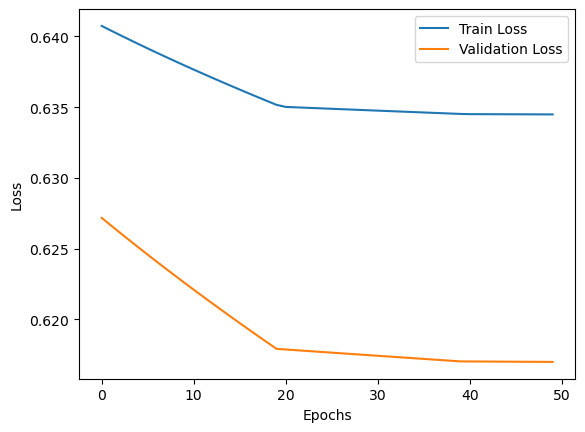

169/169 [==============================] - 1s 2ms/step
------------------------------------------------------------------------
Training for fold 3
Epoch 1/50
632/632 [==============================] - 5s 5ms/step - loss: 0.6826 - accuracy: 0.5888 - val_loss: 0.6660 - val_accuracy: 0.6281 - lr: 1.0000e-05
Epoch 2/50
632/632 [==============================] - 2s 4ms/step - loss: 0.6820 - accuracy: 0.5902 - val_loss: 0.6652 - val_accuracy: 0.6319 - lr: 1.0000e-05
Epoch 3/50
632/632 [==============================] - 2s 4ms/step - loss: 0.6815 - accuracy: 0.5913 - val_loss: 0.6644 - val_accuracy: 0.6363 - lr: 1.0000e-05
Epoch 4/50
632/632 [==============================] - 2s 4ms/step - loss: 0.6809 - accuracy: 0.5930 - val_loss: 0.6636 - val_accuracy: 0.6391 - lr: 1.0000e-05
Epoch 5/50
632/632 [==============================] - 2s 4ms/step - loss: 0.6803 - accuracy: 0.5946 - val_loss: 0.6628 - val_accuracy: 0.6407 - lr: 1.0000e-05
Epoch 6/50
632/632 [==============================] - 2s 

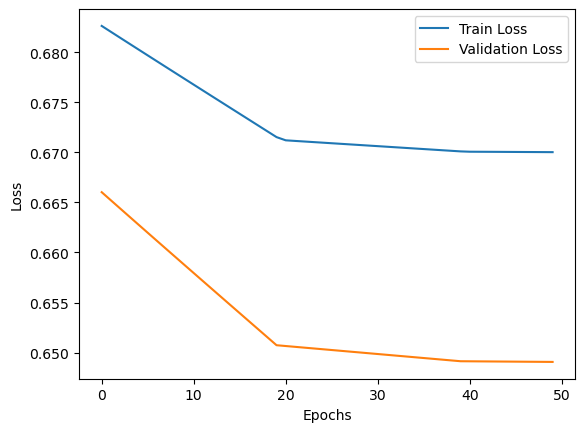

169/169 [==============================] - 1s 3ms/step
------------------------------------------------------------------------
Training for fold 4
Epoch 1/50
631/631 [==============================] - 9s 8ms/step - loss: 0.7161 - accuracy: 0.4459 - val_loss: 0.7191 - val_accuracy: 0.4369 - lr: 1.0000e-05
Epoch 2/50
631/631 [==============================] - 4s 7ms/step - loss: 0.7154 - accuracy: 0.4476 - val_loss: 0.7180 - val_accuracy: 0.4393 - lr: 1.0000e-05
Epoch 3/50
631/631 [==============================] - 4s 7ms/step - loss: 0.7147 - accuracy: 0.4501 - val_loss: 0.7170 - val_accuracy: 0.4441 - lr: 1.0000e-05
Epoch 4/50
631/631 [==============================] - 4s 7ms/step - loss: 0.7139 - accuracy: 0.4518 - val_loss: 0.7160 - val_accuracy: 0.4483 - lr: 1.0000e-05
Epoch 5/50
631/631 [==============================] - 4s 7ms/step - loss: 0.7132 - accuracy: 0.4533 - val_loss: 0.7150 - val_accuracy: 0.4515 - lr: 1.0000e-05
Epoch 6/50
631/631 [==============================] - 4s 

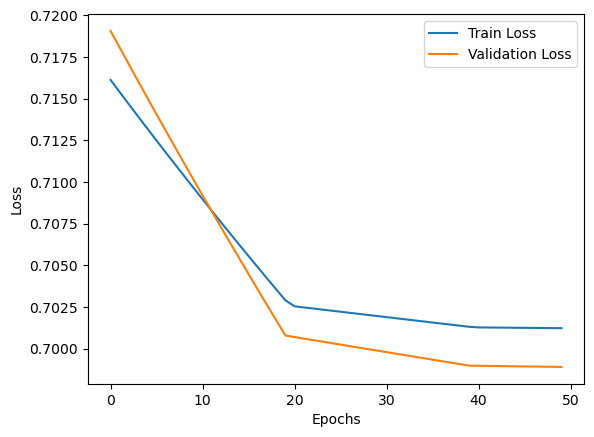

169/169 [==============================] - 2s 3ms/step
------------------------------------------------------------------------
Training for fold 5
Epoch 1/50
632/632 [==============================] - 8s 10ms/step - loss: 0.7206 - accuracy: 0.4378 - val_loss: 0.7312 - val_accuracy: 0.3956 - lr: 1.0000e-05
Epoch 2/50
632/632 [==============================] - 5s 7ms/step - loss: 0.7199 - accuracy: 0.4412 - val_loss: 0.7302 - val_accuracy: 0.4006 - lr: 1.0000e-05
Epoch 3/50
632/632 [==============================] - 5s 7ms/step - loss: 0.7192 - accuracy: 0.4451 - val_loss: 0.7292 - val_accuracy: 0.4048 - lr: 1.0000e-05
Epoch 4/50
632/632 [==============================] - 4s 7ms/step - loss: 0.7184 - accuracy: 0.4488 - val_loss: 0.7282 - val_accuracy: 0.4094 - lr: 1.0000e-05
Epoch 5/50
632/632 [==============================] - 5s 7ms/step - loss: 0.7177 - accuracy: 0.4522 - val_loss: 0.7272 - val_accuracy: 0.4130 - lr: 1.0000e-05
Epoch 6/50
632/632 [==============================] - 4s

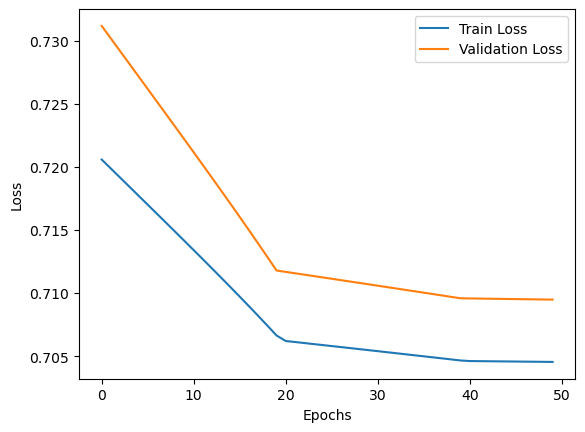

169/169 [==============================] - 1s 3ms/step
------------------------------------------------------------------------
Training for fold 1
Epoch 1/50
631/631 [==============================] - 9s 9ms/step - loss: 0.6597 - accuracy: 0.6383 - val_loss: 0.6443 - val_accuracy: 0.6765 - lr: 1.0000e-05
Epoch 2/50
631/631 [==============================] - 4s 7ms/step - loss: 0.6538 - accuracy: 0.6553 - val_loss: 0.6366 - val_accuracy: 0.6983 - lr: 1.0000e-05
Epoch 3/50
631/631 [==============================] - 4s 7ms/step - loss: 0.6484 - accuracy: 0.6695 - val_loss: 0.6292 - val_accuracy: 0.7159 - lr: 1.0000e-05
Epoch 4/50
631/631 [==============================] - 4s 7ms/step - loss: 0.6432 - accuracy: 0.6813 - val_loss: 0.6221 - val_accuracy: 0.7293 - lr: 1.0000e-05
Epoch 5/50
631/631 [==============================] - 5s 7ms/step - loss: 0.6384 - accuracy: 0.6886 - val_loss: 0.6154 - val_accuracy: 0.7350 - lr: 1.0000e-05
Epoch 6/50
631/631 [==============================] - 4s 

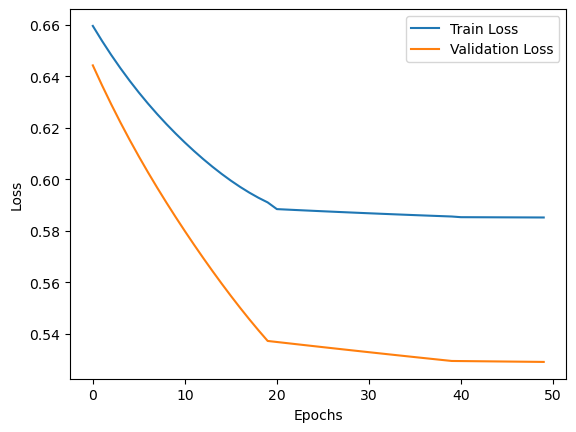

169/169 [==============================] - 2s 4ms/step
------------------------------------------------------------------------
Training for fold 2
Epoch 1/50
630/630 [==============================] - 10s 9ms/step - loss: 0.7433 - accuracy: 0.4196 - val_loss: 0.7459 - val_accuracy: 0.4324 - lr: 1.0000e-05
Epoch 2/50
630/630 [==============================] - 4s 7ms/step - loss: 0.7348 - accuracy: 0.4324 - val_loss: 0.7360 - val_accuracy: 0.4424 - lr: 1.0000e-05
Epoch 3/50
630/630 [==============================] - 4s 7ms/step - loss: 0.7266 - accuracy: 0.4436 - val_loss: 0.7266 - val_accuracy: 0.4544 - lr: 1.0000e-05
Epoch 4/50
630/630 [==============================] - 5s 7ms/step - loss: 0.7189 - accuracy: 0.4587 - val_loss: 0.7176 - val_accuracy: 0.4663 - lr: 1.0000e-05
Epoch 5/50
630/630 [==============================] - 5s 7ms/step - loss: 0.7115 - accuracy: 0.4811 - val_loss: 0.7089 - val_accuracy: 0.4830 - lr: 1.0000e-05
Epoch 6/50
630/630 [==============================] - 5s

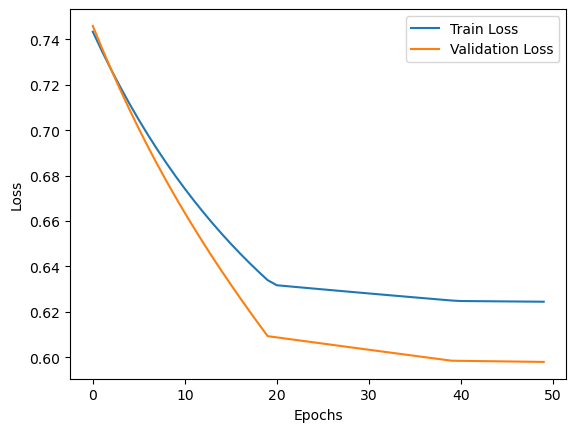

169/169 [==============================] - 1s 3ms/step
------------------------------------------------------------------------
Training for fold 3
Epoch 1/50
632/632 [==============================] - 12s 9ms/step - loss: 0.7215 - accuracy: 0.4124 - val_loss: 0.7168 - val_accuracy: 0.4456 - lr: 1.0000e-05
Epoch 2/50
632/632 [==============================] - 4s 7ms/step - loss: 0.7143 - accuracy: 0.4411 - val_loss: 0.7076 - val_accuracy: 0.4896 - lr: 1.0000e-05
Epoch 3/50
632/632 [==============================] - 4s 7ms/step - loss: 0.7076 - accuracy: 0.4643 - val_loss: 0.6988 - val_accuracy: 0.5274 - lr: 1.0000e-05
Epoch 4/50
632/632 [==============================] - 4s 7ms/step - loss: 0.7013 - accuracy: 0.4969 - val_loss: 0.6904 - val_accuracy: 0.5702 - lr: 1.0000e-05
Epoch 5/50
632/632 [==============================] - 4s 7ms/step - loss: 0.6954 - accuracy: 0.5299 - val_loss: 0.6823 - val_accuracy: 0.6094 - lr: 1.0000e-05
Epoch 6/50
632/632 [==============================] - 4s

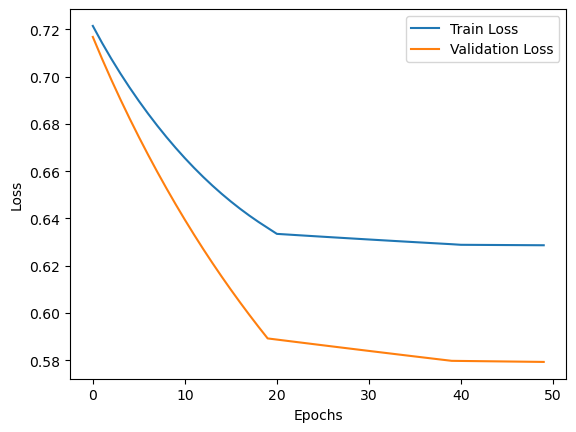

169/169 [==============================] - 1s 3ms/step
------------------------------------------------------------------------
Training for fold 4
Epoch 1/50
631/631 [==============================] - 9s 9ms/step - loss: 0.6833 - accuracy: 0.5368 - val_loss: 0.6778 - val_accuracy: 0.5333 - lr: 1.0000e-05
Epoch 2/50
631/631 [==============================] - 4s 7ms/step - loss: 0.6787 - accuracy: 0.5557 - val_loss: 0.6718 - val_accuracy: 0.5574 - lr: 1.0000e-05
Epoch 3/50
631/631 [==============================] - 1070s 2s/step - loss: 0.6743 - accuracy: 0.5813 - val_loss: 0.6659 - val_accuracy: 0.5906 - lr: 1.0000e-05
Epoch 4/50
631/631 [==============================] - 6s 10ms/step - loss: 0.6700 - accuracy: 0.6074 - val_loss: 0.6602 - val_accuracy: 0.6335 - lr: 1.0000e-05
Epoch 5/50
631/631 [==============================] - 8s 12ms/step - loss: 0.6659 - accuracy: 0.6399 - val_loss: 0.6546 - val_accuracy: 0.6774 - lr: 1.0000e-05
Epoch 6/50
631/631 [==============================] -

KeyboardInterrupt: 

In [190]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
import numpy as np

# Define the hyperparameters to tune
param_grid = {
    'lstm_units': [8,128],  # Number of LSTM units
    'lstm_epochs': [50],  # Number of training epochs
    'lstm_batch_size': [32],  # Batch size
    'optimizer': ['sgd','rmsprop','adamax'],
    'learning_rate' : [0.00001,0.001]
    
}


# Initialize variables to store the best hyperparameters and AUC score
best_params = {}
best_rec = -np.inf


# Iterate over all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    
    rec_scores = []


    fold_no = 1
    for train_index, test_index in kf.split(X_train, y_train):
        X_train_dl, X_test_dl = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
        y_train_dl, y_test_dl = y_train.iloc[train_index], y_train.iloc[test_index]

        # Perform preprocessing steps on X_train_dl
        X_train_dl_preprocessed = enc_dl.fit_transform(X_train_dl)
        X_test_dl_preprocessed = enc_dl.transform(X_test_dl)

        # Apply SMOTE and undersampling to address class imbalance
        over = SMOTE(sampling_strategy=0.4, random_state=42)
        under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
        steps = [('o',over),('u',under)]
        pipe = Pipeline(steps=steps)
            
        X_train_dl_resampled, y_train_dl_resampled =  pipe.fit_resample(X_train_dl_preprocessed, y_train_dl)
        
        round_cols = ['SEX','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6'] + X_train_dl_resampled.filter(like='EDUCATION').columns.to_list() + X_train_dl_resampled.filter(like='MARRIAGE').columns.to_list() 
        for col in round_cols:
            X_train_dl_resampled[col] = X_train_dl_resampled[col].round()
        
        # Split training data into static and temporal features
        # Perform any necessary reshaping or transformations
        temp_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
        'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
        'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
        'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
        static_cols_train = X_train_dl_resampled.drop(temp_cols,axis=1).columns.to_list()
        static_cols_test = X_test_dl_preprocessed.drop(temp_cols,axis=1).columns.to_list()
        
        X_train_dl_temp = X_train_dl_resampled[temp_cols]
        X_train_dl_static = X_train_dl_resampled[static_cols_train]
        X_test_dl_temp = X_test_dl_preprocessed[temp_cols]
        X_test_dl_static = X_test_dl_preprocessed[static_cols_test]

        PAY_cols = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2','PAY_1']
        BILL_AMT_cols = ['BILL_AMT6','BILL_AMT5','BILL_AMT4','BILL_AMT3','BILL_AMT2','BILL_AMT1']
        PAY_AMT_cols = ['PAY_AMT6','PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
        
        PAY_train_dl = X_train_dl_temp[PAY_cols].to_numpy()
        BILL_AMT_train_dl = X_train_dl_temp[BILL_AMT_cols].to_numpy()
        PAY_AMT_train_dl = X_train_dl_temp[PAY_AMT_cols].to_numpy()
        
        PAY_test_dl = X_test_dl_temp[PAY_cols].to_numpy()
        BILL_AMT_test_dl = X_test_dl_temp[BILL_AMT_cols].to_numpy()
        PAY_AMT_test_dl = X_test_dl_temp[PAY_AMT_cols].to_numpy()   
        
        # Stack temporal features
        stacked_train = np.dstack((PAY_train_dl,BILL_AMT_train_dl,PAY_AMT_train_dl))
        stacked_test = np.dstack((PAY_test_dl,BILL_AMT_test_dl,PAY_AMT_test_dl))
        y_train_dl_resampled = y_train_dl_resampled.to_numpy()
        y_test_dl = y_test_dl.to_numpy()

        # Build and compile LSTM model
        num_time_steps, num_features = stacked_train.shape[1], stacked_train.shape[2]

        # Define the LSTM model
        model = Sequential()
        model.add(LSTM(params['lstm_units'],return_sequences=True, input_shape=(num_time_steps, num_features)))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        initial_learning_rate = params['learning_rate']  # Initial learning rate
        decay_rate = 0.1  # Decay rate
        decay_steps = 20  # Decay steps (number of steps before applying decay)
        epochs = params['lstm_epochs']

        def learning_rate_scheduler(epoch):
            return initial_learning_rate * decay_rate ** (epoch // decay_steps)
        
        optimizer_name = params['optimizer']
        if optimizer_name == 'adam':
            optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
        elif optimizer_name == 'rmsprop':
            optimizer = optimizers.RMSprop(learning_rate=initial_learning_rate)
        elif optimizer_name == 'sgd':
            optimizer = optimizers.SGD(learning_rate=initial_learning_rate)
        elif optimizer_name == 'adamax':
            optimizer = optimizers.Adamax(learning_rate=initial_learning_rate)
        else:
            raise ValueError(f"Unknown optimizer: {optimizer_name}")

        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        lr_scheduler = LearningRateScheduler(learning_rate_scheduler)
        
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no}')
    
        # Train the model
        batch_size = params['lstm_batch_size']
        
        # Train the model
        history = model.fit(stacked_train, y_train_dl_resampled, epochs=epochs, batch_size=batch_size, validation_data=(stacked_test, y_test_dl),shuffle=False,callbacks=[lr_scheduler])
        
        # Plot the loss on train vs validate tests
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        y_pred_probs = model.predict(stacked_test)
        y_pred = (y_pred_probs>=0.5).astype(int)    
        rec = recall_score(y_test_dl,y_pred)
        rec_scores.append(rec)
        
        fold_no = fold_no + 1
    
    avg_rec = np.mean(rec_scores)

    if avg_rec > best_rec:
            best_rec = avg_rec
            best_params = params


# Print the best AUC score and hyperparameters
print("Best AUC score: %.4f" % best_rec)
print("Best hyperparameters: ", best_params)

# VAE Data augmentation

In [125]:
p = copy.deepcopy(X_train)
j = copy.deepcopy(y_train)
new = pd.concat([p,j],axis=1)
non_default = new[new['DEFAULT']==0].drop('DEFAULT',axis=1)
default = new[new['DEFAULT']==1].drop('DEFAULT',axis=1)

In [126]:
p_sub = p[:10]


In [44]:
p_sub

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
22788,160000,2,2,2,33,2,2,3,2,0,...,168541,164310,162681,163005,15000,0,0,6100,12300,6100
29006,150000,2,1,2,34,1,-1,-1,-2,-2,...,0,0,0,0,53,0,0,0,0,0
16950,10000,1,2,1,50,1,2,0,0,0,...,8446,8067,8227,8400,2,1281,1134,294,305,1000
22280,220000,2,1,2,29,0,0,0,0,0,...,215139,218513,131660,134346,9100,9000,7887,4800,4900,6000
11346,310000,2,1,2,32,1,-2,-1,0,0,...,326,326,-235,-235,0,326,0,0,0,1200
4102,240000,2,1,2,36,-1,-1,2,0,-1,...,6649,5149,13750,5777,6959,15,0,7013,0,726
28654,160000,2,3,2,33,-1,2,2,2,2,...,44255,43228,-772,-772,0,43500,0,0,0,3000
26150,50000,2,2,1,34,3,3,2,2,2,...,48602,46289,44837,44535,2000,2001,499,2000,2000,1500
15091,360000,1,1,1,32,0,0,0,0,0,...,128518,134368,135626,134864,6000,6000,8000,4918,5000,3300
6266,320000,1,2,2,29,0,0,0,0,0,...,325024,322246,297637,301575,11650,12500,11900,10503,10886,10040


In [127]:
enc_new = PreprocessorTransformer(columns = ohe_cols, columns_num= numerical_cols,drop='first',handle_unknown='ignore',sparse_output=False)

In [128]:
p_sub_enc = enc_dl.fit_transform(p_sub)

In [120]:
p_sub_enc[:5]

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,MARRIAGE_2
22788,-0.214286,2,0.0,2,2,3,2,0,0,0.888387,...,1.024362,1.286550,-0.201171,-0.040250,0.471122,2.240704,0.900585,1.0,0.0,1.0
29006,-0.285714,2,0.5,1,-1,-1,-2,-2,-2,-0.228095,...,-0.198570,-0.461637,-0.201171,-0.040250,-0.593265,-0.231658,-0.526316,0.0,0.0,1.0
16950,-1.285714,1,8.5,1,2,0,0,0,0,-0.157899,...,-0.135550,-0.467602,-0.044133,0.142690,-0.541965,-0.170352,-0.292398,1.0,0.0,0.0
22280,0.214286,2,-2.0,0,0,0,0,0,0,1.199705,...,0.809350,0.596491,0.902142,1.232103,0.244285,0.753266,0.877193,0.0,0.0,1.0
11346,0.857143,2,-0.5,1,-2,-1,0,0,-2,-0.228095,...,-0.200333,-0.467836,-0.161206,-0.040250,-0.593265,-0.231658,-0.245614,0.0,0.0,1.0


In [221]:
p_sub_enc

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,MARRIAGE_2
22788,-0.214286,2,0.0,2,2,3,2,0,0,0.888387,...,1.024362,1.286550,-0.201171,-0.040250,0.471122,2.240704,0.900585,1.0,0.0,1.0
29006,-0.285714,2,0.5,1,-1,-1,-2,-2,-2,-0.228095,...,-0.198570,-0.461637,-0.201171,-0.040250,-0.593265,-0.231658,-0.526316,0.0,0.0,1.0
16950,-1.285714,1,8.5,1,2,0,0,0,0,-0.157899,...,-0.135550,-0.467602,-0.044133,0.142690,-0.541965,-0.170352,-0.292398,1.0,0.0,0.0
22280,0.214286,2,-2.0,0,0,0,0,0,0,1.199705,...,0.809350,0.596491,0.902142,1.232103,0.244285,0.753266,0.877193,0.0,0.0,1.0
11346,0.857143,2,-0.5,1,-2,-1,0,0,-2,-0.228095,...,-0.200333,-0.467836,-0.161206,-0.040250,-0.593265,-0.231658,-0.245614,0.0,0.0,1.0
4102,0.357143,2,1.5,-1,-1,2,0,-1,2,-0.191054,...,-0.155229,0.346082,-0.199332,-0.040250,0.630431,-0.231658,-0.356491,0.0,0.0,1.0
28654,-0.214286,2,0.0,-1,2,2,2,2,-2,-0.102520,...,-0.204362,-0.467836,5.131509,-0.040250,-0.593265,-0.231658,0.175439,0.0,1.0,1.0
26150,-1.000000,2,0.5,3,3,2,2,2,2,0.102520,...,0.135550,-0.233918,0.044133,0.040250,-0.244285,0.170352,-0.175439,1.0,0.0,0.0
15091,1.214286,1,-0.5,0,0,0,0,0,0,0.603778,...,0.813237,0.233918,0.534371,1.250333,0.264875,0.773367,0.245614,0.0,0.0,0.0
6266,0.928571,1,-2.0,0,0,0,0,0,0,2.012813,...,2.063973,0.894737,1.331208,1.879492,1.239400,1.956482,1.822222,1.0,0.0,1.0


In [113]:
 from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [45]:
from sklearn.impute import KNNImputer


def augment_data_with_knn(df, null_columns, k=5):
    # Duplicate the entire dataframe
    duplicated = df.copy()
    
    
    # Set null values in specified columns
    for col in null_columns:
        duplicated[col] = np.nan
    
    # Concatenate the duplicated dataframe with the original dataframe
    augmented_df = pd.concat([df, duplicated], ignore_index=True)
    
    # Perform KNN imputation
    imputer = KNNImputer(n_neighbors=k)
    augmented_df_imputed = imputer.fit_transform(augmented_df)
    
    # Convert the imputed array back to a dataframe
    augmented_df_imputed = pd.DataFrame(augmented_df_imputed, columns=augmented_df.columns)
    
    return augmented_df_imputed


In [138]:
null_columns = ['LIMIT_BAL','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6','PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


augmented_df = augment_data_with_knn(p_sub_enc, null_columns)

c:\Users\diama\anaconda3\envs\spyder\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [139]:
p_sub_enc

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,MARRIAGE_2
22788,-0.214286,2,0.0,2,2,3,2,0,0,0.888387,...,1.024362,1.286550,-0.201171,-0.040250,0.471122,2.240704,0.900585,1.0,0.0,1.0
29006,-0.285714,2,0.5,1,-1,-1,-2,-2,-2,-0.228095,...,-0.198570,-0.461637,-0.201171,-0.040250,-0.593265,-0.231658,-0.526316,0.0,0.0,1.0
16950,-1.285714,1,8.5,1,2,0,0,0,0,-0.157899,...,-0.135550,-0.467602,-0.044133,0.142690,-0.541965,-0.170352,-0.292398,1.0,0.0,0.0
22280,0.214286,2,-2.0,0,0,0,0,0,0,1.199705,...,0.809350,0.596491,0.902142,1.232103,0.244285,0.753266,0.877193,0.0,0.0,1.0
11346,0.857143,2,-0.5,1,-2,-1,0,0,-2,-0.228095,...,-0.200333,-0.467836,-0.161206,-0.040250,-0.593265,-0.231658,-0.245614,0.0,0.0,1.0
4102,0.357143,2,1.5,-1,-1,2,0,-1,2,-0.191054,...,-0.155229,0.346082,-0.199332,-0.040250,0.630431,-0.231658,-0.356491,0.0,0.0,1.0
28654,-0.214286,2,0.0,-1,2,2,2,2,-2,-0.102520,...,-0.204362,-0.467836,5.131509,-0.040250,-0.593265,-0.231658,0.175439,0.0,1.0,1.0
26150,-1.000000,2,0.5,3,3,2,2,2,2,0.102520,...,0.135550,-0.233918,0.044133,0.040250,-0.244285,0.170352,-0.175439,1.0,0.0,0.0
15091,1.214286,1,-0.5,0,0,0,0,0,0,0.603778,...,0.813237,0.233918,0.534371,1.250333,0.264875,0.773367,0.245614,0.0,0.0,0.0
6266,0.928571,1,-2.0,0,0,0,0,0,0,2.012813,...,2.063973,0.894737,1.331208,1.879492,1.239400,1.956482,1.822222,1.0,0.0,1.0


In [140]:
augmented_df

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,MARRIAGE_2
0,-0.214286,2.0,0.0,2.0,2.0,3.0,2.0,0.0,0.0,0.888387,...,1.024362,1.286550,-0.201171,-0.040250,0.471122,2.240704,0.900585,1.0,0.0,1.0
1,-0.285714,2.0,0.5,1.0,-1.0,-1.0,-2.0,-2.0,-2.0,-0.228095,...,-0.198570,-0.461637,-0.201171,-0.040250,-0.593265,-0.231658,-0.526316,0.0,0.0,1.0
2,-1.285714,1.0,8.5,1.0,2.0,0.0,0.0,0.0,0.0,-0.157899,...,-0.135550,-0.467602,-0.044133,0.142690,-0.541965,-0.170352,-0.292398,1.0,0.0,0.0
3,0.214286,2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.199705,...,0.809350,0.596491,0.902142,1.232103,0.244285,0.753266,0.877193,0.0,0.0,1.0
4,0.857143,2.0,-0.5,1.0,-2.0,-1.0,0.0,0.0,-2.0,-0.228095,...,-0.200333,-0.467836,-0.161206,-0.040250,-0.593265,-0.231658,-0.245614,0.0,0.0,1.0
5,0.357143,2.0,1.5,-1.0,-1.0,2.0,0.0,-1.0,2.0,-0.191054,...,-0.155229,0.346082,-0.199332,-0.040250,0.630431,-0.231658,-0.356491,0.0,0.0,1.0
6,-0.214286,2.0,0.0,-1.0,2.0,2.0,2.0,2.0,-2.0,-0.102520,...,-0.204362,-0.467836,5.131509,-0.040250,-0.593265,-0.231658,0.175439,0.0,1.0,1.0
7,-1.000000,2.0,0.5,3.0,3.0,2.0,2.0,2.0,2.0,0.102520,...,0.135550,-0.233918,0.044133,0.040250,-0.244285,0.170352,-0.175439,1.0,0.0,0.0
8,1.214286,1.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.603778,...,0.813237,0.233918,0.534371,1.250333,0.264875,0.773367,0.245614,0.0,0.0,0.0
9,0.928571,1.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.012813,...,2.063973,0.894737,1.331208,1.879492,1.239400,1.956482,1.822222,1.0,0.0,1.0


In [222]:
trial = copy.deepcopy(X_train_dl_resampled)
trial

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3
0,-0.684211,1,0.769231,0,0,0,0,0,0,-0.209734,...,-0.188580,-0.193705,-0.350920,-0.356060,-0.384615,0.0,0.0,1.0,1.0,0.0
1,-0.473684,2,-0.692308,0,0,0,0,0,0,0.251871,...,-0.002399,-0.072639,-0.134246,-0.052750,-0.051282,0.0,0.0,0.0,1.0,0.0
2,-0.421053,2,-0.615385,2,2,2,2,2,2,0.532344,...,-0.482246,0.774818,0.271446,-0.394039,0.384615,1.0,0.0,0.0,1.0,0.0
3,-0.473684,2,-0.384615,0,0,0,0,0,0,-0.033520,...,-0.002399,0.048426,0.134246,0.131874,0.128205,1.0,0.0,0.0,0.0,0.0
4,-0.631579,2,-0.692308,0,0,2,2,2,2,-0.229435,...,-0.218330,0.556901,-0.401128,0.131874,-0.384615,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17953,1.157895,1,-0.461538,1,-2,-2,-2,-2,-2,-0.351370,...,-0.482246,-0.435835,-0.402739,-0.395622,-0.384615,1.0,0.0,0.0,1.0,0.0
17954,-0.155184,2,-0.659701,-1,-1,-2,-2,-2,-2,-0.303306,...,-0.482246,-0.435835,-0.402739,-0.395622,-0.384615,1.0,0.0,0.0,1.0,0.0
17955,-0.573954,1,-0.387048,2,0,0,0,-2,-2,0.093394,...,0.702195,-0.435835,-0.402739,-0.395622,-0.384615,1.0,0.0,0.0,1.0,0.0
17956,-0.550525,1,-0.668571,-2,-2,-2,-2,-2,-2,-0.339513,...,-0.388676,-0.253900,-0.306105,-0.383434,-0.194129,0.0,1.0,0.0,1.0,0.0


In [227]:
y_train_dl_resampled[80:90]

80    0
81    0
82    0
83    0
84    0
85    0
86    0
87    0
88    0
89    0
Name: DEFAULT, dtype: int64

In [198]:
trial_y = copy.deepcopy(y_train_dl_resampled)
trial_y = pd.Series(trial_y,name='DEFAULT')

In [199]:
trial_concat = pd.concat([trial,trial_y],axis=1)
trial_concat
non_default = trial_concat[trial_concat['DEFAULT']==0].drop('DEFAULT',axis=1)
default = trial_concat[trial_concat['DEFAULT']==1].drop('DEFAULT',axis=1)

In [200]:
non_default

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3
0,0.736842,1,-0.076923,-2,-2,-2,-2,-2,-2,-0.353280,...,0.307193,0.431256,0.326181,1.579139,0.751537,1.0,0.0,0.0,1.0,0.0
1,-0.631579,2,-0.538462,0,0,0,0,0,-1,-0.054967,...,-0.121868,-0.072550,0.430720,4.797094,-0.097080,1.0,0.0,0.0,1.0,0.0
2,-0.105263,2,0.538462,-2,-2,-2,-2,-2,-2,-0.353280,...,-0.133646,-0.434586,-0.401043,-0.392320,-0.384221,0.0,0.0,1.0,0.0,0.0
3,0.368421,2,0.384615,1,-2,-2,-2,-2,-2,-0.353280,...,-0.484586,-0.434586,-0.401043,-0.392320,-0.384221,0.0,0.0,0.0,1.0,0.0
4,1.157895,1,0.692308,-1,-1,-1,-1,-1,0,-0.290513,...,0.331230,2.634396,6.817726,-0.392320,17.284324,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11943,-0.315789,2,0.846154,0,0,0,0,0,0,0.206845,...,-0.033411,-0.014034,-0.055611,-0.158796,-0.034580,0.0,1.0,0.0,0.0,0.0
11944,-0.421053,1,-0.538462,0,0,0,0,2,0,0.065014,...,-0.142059,0.279020,-0.401043,-0.144525,-0.142930,1.0,0.0,0.0,1.0,0.0
11945,0.210526,2,0.538462,2,0,0,0,0,0,1.338818,...,-0.003846,-0.077783,0.133681,0.386092,0.384221,1.0,0.0,0.0,0.0,0.0
11946,-0.315789,2,0.692308,2,0,0,0,0,0,0.732319,...,0.380746,0.212417,0.240626,0.184743,0.637807,1.0,0.0,0.0,0.0,0.0


In [201]:
augmented_non_default = augment_data_with_knn(non_default, null_columns)
augmented_non_default

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3
0,0.736842,1.0,-0.076923,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-0.353280,...,0.307193,0.431256,0.326181,1.579139,0.751537,1.0,0.0,0.0,1.0,0.0
1,-0.631579,2.0,-0.538462,0.0,0.0,0.0,0.0,0.0,-1.0,-0.054967,...,-0.121868,-0.072550,0.430720,4.797094,-0.097080,1.0,0.0,0.0,1.0,0.0
2,-0.105263,2.0,0.538462,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-0.353280,...,-0.133646,-0.434586,-0.401043,-0.392320,-0.384221,0.0,0.0,1.0,0.0,0.0
3,0.368421,2.0,0.384615,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-0.353280,...,-0.484586,-0.434586,-0.401043,-0.392320,-0.384221,0.0,0.0,0.0,1.0,0.0
4,1.157895,1.0,0.692308,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-0.290513,...,0.331230,2.634396,6.817726,-0.392320,17.284324,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11945,0.210526,2.0,0.538462,2.0,0.0,0.0,0.0,0.0,0.0,1.338818,...,-0.003846,-0.077783,0.133681,0.386092,0.384221,1.0,0.0,0.0,0.0,0.0
11946,-0.315789,2.0,0.692308,2.0,0.0,0.0,0.0,0.0,0.0,0.732319,...,0.380746,0.212417,0.240626,0.184743,0.637807,1.0,0.0,0.0,0.0,0.0
11947,-0.684211,1.0,-0.846154,0.0,0.0,0.0,0.0,0.0,0.0,-0.269042,...,-0.224265,-0.315652,-0.133681,-0.132849,-0.347848,1.0,0.0,0.0,1.0,0.0
11948,0.511401,1.0,-0.014922,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.552387,...,0.307193,0.431256,0.326181,1.579139,0.751537,1.0,0.0,0.0,1.0,0.0


In [202]:
augmented_default = augment_data_with_knn(default, null_columns)
augmented_default

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3
0,0.315789,1.0,1.153846,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-0.346698,...,-0.484586,-0.137726,-0.401043,-0.284380,-0.277664,0.0,0.0,0.0,0.0,0.0
1,0.368421,2.0,0.230769,2.0,2.0,2.0,2.0,2.0,2.0,0.850622,...,0.236524,0.326594,0.267362,0.489881,0.717213,0.0,0.0,0.0,0.0,0.0
2,-0.578947,2.0,-0.923077,1.0,2.0,2.0,-1.0,2.0,2.0,0.004668,...,-0.484586,-0.084919,-0.309872,-0.392320,2.772541,1.0,0.0,0.0,1.0,0.0
3,-0.473684,2.0,-0.769231,0.0,0.0,0.0,0.0,0.0,0.0,0.265102,...,-0.075957,-0.077545,0.053472,0.489881,-0.384221,1.0,0.0,0.0,1.0,0.0
4,-0.578947,1.0,1.769231,2.0,0.0,0.0,2.0,3.0,2.0,0.009952,...,0.351421,0.058516,-0.401043,-0.392320,-0.095031,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,-0.475497,1.0,-0.390797,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-0.318113,...,0.851783,2.393789,-0.223174,2.163969,1.548431,0.0,0.0,0.0,1.0,0.0
5972,-0.339480,2.0,-0.503837,0.0,0.0,0.0,0.0,0.0,0.0,0.453145,...,0.006974,0.046252,0.207190,0.209640,0.140851,0.0,0.0,0.0,1.0,0.0
5973,-0.624349,1.0,0.223724,1.0,2.0,0.0,0.0,0.0,0.0,-0.121007,...,-0.003846,0.273574,-0.121438,0.130186,-0.384221,1.0,0.0,0.0,1.0,0.0
5974,0.401489,1.0,0.553639,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.400950,...,-0.484586,-0.137726,-0.401043,-0.284380,-0.277664,0.0,0.0,0.0,0.0,0.0


In [203]:
augmented_non_default['DEFAULT'] = 0
augmented_default['DEFAULT'] = 1


In [204]:
augmented_data = pd.concat([augmented_default,augmented_non_default],axis=0)


In [207]:
augmented_data

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3,DEFAULT
0,0.315789,1.0,1.153846,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-0.346698,...,-0.137726,-0.401043,-0.284380,-0.277664,0.0,0.0,0.0,0.0,0.0,1
1,0.368421,2.0,0.230769,2.0,2.0,2.0,2.0,2.0,2.0,0.850622,...,0.326594,0.267362,0.489881,0.717213,0.0,0.0,0.0,0.0,0.0,1
2,-0.578947,2.0,-0.923077,1.0,2.0,2.0,-1.0,2.0,2.0,0.004668,...,-0.084919,-0.309872,-0.392320,2.772541,1.0,0.0,0.0,1.0,0.0,1
3,-0.473684,2.0,-0.769231,0.0,0.0,0.0,0.0,0.0,0.0,0.265102,...,-0.077545,0.053472,0.489881,-0.384221,1.0,0.0,0.0,1.0,0.0,1
4,-0.578947,1.0,1.769231,2.0,0.0,0.0,2.0,3.0,2.0,0.009952,...,0.058516,-0.401043,-0.392320,-0.095031,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11945,0.210526,2.0,0.538462,2.0,0.0,0.0,0.0,0.0,0.0,1.338818,...,-0.077783,0.133681,0.386092,0.384221,1.0,0.0,0.0,0.0,0.0,0
11946,-0.315789,2.0,0.692308,2.0,0.0,0.0,0.0,0.0,0.0,0.732319,...,0.212417,0.240626,0.184743,0.637807,1.0,0.0,0.0,0.0,0.0,0
11947,-0.684211,1.0,-0.846154,0.0,0.0,0.0,0.0,0.0,0.0,-0.269042,...,-0.315652,-0.133681,-0.132849,-0.347848,1.0,0.0,0.0,1.0,0.0,0
11948,0.511401,1.0,-0.014922,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.552387,...,0.431256,0.326181,1.579139,0.751537,1.0,0.0,0.0,1.0,0.0,0


In [210]:
augmented_data = augmented_data.sample(frac=1, random_state=42)
augmented_data

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3,DEFAULT
5786,0.400696,2.0,-0.251087,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-0.353280,...,-0.434586,-0.401043,-0.392320,-0.384221,0.0,0.0,0.0,1.0,0.0,1
2353,0.894737,1.0,0.230769,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-0.353280,...,-0.434586,-0.401043,-0.392320,-0.384221,0.0,0.0,0.0,1.0,0.0,1
4802,-0.423994,2.0,0.527152,2.0,2.0,2.0,0.0,0.0,0.0,0.021114,...,-0.115212,-0.133681,-0.097286,-0.092966,1.0,0.0,0.0,0.0,0.0,1
2153,-0.631579,2.0,0.000000,0.0,0.0,0.0,2.0,3.0,2.0,-0.245261,...,-0.196717,-0.401043,-0.392320,-0.254098,1.0,0.0,0.0,0.0,0.0,1
1126,-0.473684,1.0,0.923077,1.0,2.0,0.0,0.0,2.0,0.0,0.209297,...,0.231446,-0.401043,-0.003114,0.256148,0.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9743,0.157895,2.0,-0.538462,0.0,0.0,0.0,0.0,0.0,0.0,0.421173,...,0.759039,0.937370,0.392320,0.463371,1.0,0.0,0.0,1.0,0.0,0
5300,1.157895,2.0,-0.340313,0.0,0.0,0.0,0.0,0.0,0.0,0.089056,...,-0.224299,0.528075,0.027445,0.198593,0.0,0.0,0.0,1.0,0.0,1
10053,0.157895,1.0,1.307692,0.0,0.0,0.0,0.0,0.0,0.0,0.523211,...,-0.028069,0.038767,0.036585,0.057633,0.0,1.0,0.0,0.0,0.0,0
5056,-0.368421,2.0,1.153846,1.0,2.0,2.0,2.0,2.0,0.0,-0.196402,...,-0.172931,-0.401043,-0.262584,-0.230533,0.0,1.0,0.0,0.0,0.0,0


In [209]:
x_aug = augmented_data.drop('DEFAULT',axis=1)


In [98]:
y_aug = augmented_data['DEFAULT']
y_aug

4251     0
11832    0
6194     1
16740    0
1645     0
        ..
4846     0
6265     1
11284    1
860      1
3791     0
Name: DEFAULT, Length: 36012, dtype: int64

In [107]:
from sklearn.preprocessing import StandardScaler

In [156]:
 X_train_dl_resampled

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3
0,0.736842,1,-0.076923,-2,-2,-2,-2,-2,-2,-0.353280,...,0.307193,0.431256,0.326181,1.579139,0.751537,1.0,0.0,0.0,1.0,0.0
1,-0.631579,2,-0.538462,0,0,0,0,0,-1,-0.054967,...,-0.121868,-0.072550,0.430720,4.797094,-0.097080,1.0,0.0,0.0,1.0,0.0
2,-0.105263,2,0.538462,-2,-2,-2,-2,-2,-2,-0.353280,...,-0.133646,-0.434586,-0.401043,-0.392320,-0.384221,0.0,0.0,1.0,0.0,0.0
3,0.368421,2,0.384615,1,-2,-2,-2,-2,-2,-0.353280,...,-0.484586,-0.434586,-0.401043,-0.392320,-0.384221,0.0,0.0,0.0,1.0,0.0
4,1.157895,1,0.692308,-1,-1,-1,-1,-1,0,-0.290513,...,0.331230,2.634396,6.817726,-0.392320,17.284324,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17917,-0.120718,2,-0.556532,0,0,0,2,0,0,-0.166821,...,-0.112286,-0.434586,-0.118485,-0.252445,-0.231631,0.0,0.0,0.0,1.0,0.0
17918,-0.246429,1,0.551580,-1,0,0,-1,0,0,-0.343753,...,0.213476,1.188004,-0.361915,-0.388271,-0.384221,1.0,0.0,0.0,0.0,0.0
17919,-0.475497,1,-0.390797,-1,-1,-1,-1,0,-1,-0.318113,...,0.851783,2.393789,-0.223174,2.163969,1.548431,0.0,0.0,0.0,1.0,0.0
17920,-0.339480,2,-0.503837,0,0,0,0,0,0,0.453145,...,0.006974,0.046252,0.207190,0.209640,0.140851,0.0,0.0,0.0,1.0,0.0


In [159]:
default

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3
11948,0.315789,1,1.153846,-1,-1,-1,-1,0,-1,-0.346698,...,-0.484586,-0.137726,-0.401043,-0.284380,-0.277664,0.0,0.0,0.0,0.0,0.0
11949,0.368421,2,0.230769,2,2,2,2,2,2,0.850622,...,0.236524,0.326594,0.267362,0.489881,0.717213,0.0,0.0,0.0,0.0,0.0
11950,-0.578947,2,-0.923077,1,2,2,-1,2,2,0.004668,...,-0.484586,-0.084919,-0.309872,-0.392320,2.772541,1.0,0.0,0.0,1.0,0.0
11951,-0.473684,2,-0.769231,0,0,0,0,0,0,0.265102,...,-0.075957,-0.077545,0.053472,0.489881,-0.384221,1.0,0.0,0.0,1.0,0.0
11952,-0.578947,1,1.769231,2,0,0,2,3,2,0.009952,...,0.351421,0.058516,-0.401043,-0.392320,-0.095031,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17917,-0.120718,2,-0.556532,0,0,0,2,0,0,-0.166821,...,-0.112286,-0.434586,-0.118485,-0.252445,-0.231631,0.0,0.0,0.0,1.0,0.0
17918,-0.246429,1,0.551580,-1,0,0,-1,0,0,-0.343753,...,0.213476,1.188004,-0.361915,-0.388271,-0.384221,1.0,0.0,0.0,0.0,0.0
17919,-0.475497,1,-0.390797,-1,-1,-1,-1,0,-1,-0.318113,...,0.851783,2.393789,-0.223174,2.163969,1.548431,0.0,0.0,0.0,1.0,0.0
17920,-0.339480,2,-0.503837,0,0,0,0,0,0,0.453145,...,0.006974,0.046252,0.207190,0.209640,0.140851,0.0,0.0,0.0,1.0,0.0


In [183]:
augmented_default

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3
0,0.315789,1.0,1.153846,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-0.346698,...,-0.484586,-0.137726,-0.401043,-0.284380,-0.277664,0.0,0.0,0.0,0.0,0.0
1,0.368421,2.0,0.230769,2.0,2.0,2.0,2.0,2.0,2.0,0.850622,...,0.236524,0.326594,0.267362,0.489881,0.717213,0.0,0.0,0.0,0.0,0.0
2,-0.578947,2.0,-0.923077,1.0,2.0,2.0,-1.0,2.0,2.0,0.004668,...,-0.484586,-0.084919,-0.309872,-0.392320,2.772541,1.0,0.0,0.0,1.0,0.0
3,-0.473684,2.0,-0.769231,0.0,0.0,0.0,0.0,0.0,0.0,0.265102,...,-0.075957,-0.077545,0.053472,0.489881,-0.384221,1.0,0.0,0.0,1.0,0.0
4,-0.578947,1.0,1.769231,2.0,0.0,0.0,2.0,3.0,2.0,0.009952,...,0.351421,0.058516,-0.401043,-0.392320,-0.095031,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,-0.475497,1.0,-0.390797,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-0.318113,...,0.851783,2.393789,-0.223174,2.163969,1.548431,0.0,0.0,0.0,1.0,0.0
5972,-0.339480,2.0,-0.503837,0.0,0.0,0.0,0.0,0.0,0.0,0.453145,...,0.006974,0.046252,0.207190,0.209640,0.140851,0.0,0.0,0.0,1.0,0.0
5973,-0.624349,1.0,0.223724,1.0,2.0,0.0,0.0,0.0,0.0,-0.121007,...,-0.003846,0.273574,-0.121438,0.130186,-0.384221,1.0,0.0,0.0,1.0,0.0
5974,0.401489,1.0,0.553639,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.400950,...,-0.484586,-0.137726,-0.401043,-0.284380,-0.277664,0.0,0.0,0.0,0.0,0.0


In [166]:
augmented_non_default[:]

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3,DEAFULT,DEFAULT
0,-0.210526,1.0,0.769231,0.0,0.0,0.0,2.0,0.0,0.0,-0.167412,...,-0.405268,-0.402118,0.443590,1.0,0.0,0.0,0.0,0.0,0,0
1,-0.315789,1.0,-0.846154,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-0.336091,...,-0.202634,-0.184974,-0.048718,1.0,0.0,0.0,0.0,0.0,0,0
2,0.315789,2.0,0.153846,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-0.348607,...,-0.405268,-0.402118,-0.384615,0.0,0.0,0.0,0.0,0.0,0,0
3,1.157895,2.0,1.230769,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.346293,...,-0.405268,-0.328396,-0.384615,1.0,0.0,0.0,0.0,0.0,0,0
4,0.473684,1.0,-0.230769,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-0.348607,...,-0.378251,0.242611,-0.384615,0.0,0.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24003,-0.378947,1.0,-0.692308,0.0,-1.0,-1.0,0.0,-1.0,-1.0,0.024773,...,1.442161,5.466497,2.456718,1.0,0.0,0.0,1.0,0.0,0,0
24004,1.073684,2.0,0.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.184802,...,4.645566,3.504430,12.282205,0.0,0.0,0.0,1.0,0.0,0,0
24005,1.326316,2.0,-0.076923,0.0,0.0,0.0,0.0,0.0,0.0,1.923276,...,3.447484,1.796126,1.538462,0.0,0.0,0.0,1.0,0.0,0,0
24006,0.431579,2.0,0.615385,0.0,0.0,0.0,0.0,0.0,0.0,1.921506,...,0.653239,0.813458,1.452308,1.0,0.0,0.0,0.0,0.0,0,0


In [180]:
nai =pd.concat([augmented_default,augmented_non_default],axis=0)

In [182]:
nai

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3
0,0.315789,1.0,1.153846,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-0.346698,...,-0.484586,-0.137726,-0.401043,-0.284380,-0.277664,0.0,0.0,0.0,0.0,0.0
1,0.368421,2.0,0.230769,2.0,2.0,2.0,2.0,2.0,2.0,0.850622,...,0.236524,0.326594,0.267362,0.489881,0.717213,0.0,0.0,0.0,0.0,0.0
2,-0.578947,2.0,-0.923077,1.0,2.0,2.0,-1.0,2.0,2.0,0.004668,...,-0.484586,-0.084919,-0.309872,-0.392320,2.772541,1.0,0.0,0.0,1.0,0.0
3,-0.473684,2.0,-0.769231,0.0,0.0,0.0,0.0,0.0,0.0,0.265102,...,-0.075957,-0.077545,0.053472,0.489881,-0.384221,1.0,0.0,0.0,1.0,0.0
4,-0.578947,1.0,1.769231,2.0,0.0,0.0,2.0,3.0,2.0,0.009952,...,0.351421,0.058516,-0.401043,-0.392320,-0.095031,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11945,0.210526,2.0,0.538462,2.0,0.0,0.0,0.0,0.0,0.0,1.338818,...,-0.003846,-0.077783,0.133681,0.386092,0.384221,1.0,0.0,0.0,0.0,0.0
11946,-0.315789,2.0,0.692308,2.0,0.0,0.0,0.0,0.0,0.0,0.732319,...,0.380746,0.212417,0.240626,0.184743,0.637807,1.0,0.0,0.0,0.0,0.0
11947,-0.684211,1.0,-0.846154,0.0,0.0,0.0,0.0,0.0,0.0,-0.269042,...,-0.224265,-0.315652,-0.133681,-0.132849,-0.347848,1.0,0.0,0.0,1.0,0.0
11948,0.511401,1.0,-0.014922,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.552387,...,0.307193,0.431256,0.326181,1.579139,0.751537,1.0,0.0,0.0,1.0,0.0


In [219]:
X_train_dl_resampled

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3
0,-0.684211,1,0.769231,0,0,0,0,0,0,-0.209734,...,-0.188580,-0.193705,-0.350920,-0.356060,-0.384615,0.0,0.0,1.0,1.0,0.0
1,-0.473684,2,-0.692308,0,0,0,0,0,0,0.251871,...,-0.002399,-0.072639,-0.134246,-0.052750,-0.051282,0.0,0.0,0.0,1.0,0.0
2,-0.421053,2,-0.615385,2,2,2,2,2,2,0.532344,...,-0.482246,0.774818,0.271446,-0.394039,0.384615,1.0,0.0,0.0,1.0,0.0
3,-0.473684,2,-0.384615,0,0,0,0,0,0,-0.033520,...,-0.002399,0.048426,0.134246,0.131874,0.128205,1.0,0.0,0.0,0.0,0.0
4,-0.631579,2,-0.692308,0,0,2,2,2,2,-0.229435,...,-0.218330,0.556901,-0.401128,0.131874,-0.384615,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17953,1.157895,1,-0.461538,1,-2,-2,-2,-2,-2,-0.351370,...,-0.482246,-0.435835,-0.402739,-0.395622,-0.384615,1.0,0.0,0.0,1.0,0.0
17954,-0.155184,2,-0.659701,-1,-1,-2,-2,-2,-2,-0.303306,...,-0.482246,-0.435835,-0.402739,-0.395622,-0.384615,1.0,0.0,0.0,1.0,0.0
17955,-0.573954,1,-0.387048,2,0,0,0,-2,-2,0.093394,...,0.702195,-0.435835,-0.402739,-0.395622,-0.384615,1.0,0.0,0.0,1.0,0.0
17956,-0.550525,1,-0.668571,-2,-2,-2,-2,-2,-2,-0.339513,...,-0.388676,-0.253900,-0.306105,-0.383434,-0.194129,0.0,1.0,0.0,1.0,0.0


In [220]:
X_train_dl_augmented

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3
1087,0.052632,2.0,0.923077,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-0.351370,...,-0.482246,-0.435835,-0.402739,-0.395622,-0.384615,0.0,1.0,0.0,0.0,0.0
3378,-0.473684,1.0,0.692308,0.0,0.0,0.0,-1.0,0.0,0.0,-0.179061,...,-0.482246,3.553269,-0.238690,-0.216537,-0.296410,0.0,1.0,0.0,0.0,0.0
4705,1.807880,2.0,0.046239,0.0,0.0,0.0,0.0,0.0,0.0,-0.038868,...,-0.170345,-0.246982,-0.149016,-0.013212,0.032856,0.0,0.0,0.0,1.0,0.0
4347,-0.473684,2.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.420496,...,0.045585,0.000000,0.107397,0.131874,0.128205,1.0,0.0,0.0,1.0,0.0
2520,1.578947,2.0,-0.461538,0.0,0.0,0.0,0.0,0.0,0.0,0.717365,...,0.237524,0.774818,0.402739,0.395622,0.384615,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5295,0.315789,1.0,-0.384615,0.0,0.0,0.0,0.0,0.0,0.0,2.619360,...,1.437140,0.774818,0.939723,0.923117,0.897436,0.0,0.0,0.0,1.0,0.0
5975,0.105263,2.0,0.769231,0.0,-1.0,-1.0,2.0,2.0,2.0,-0.255539,...,0.246401,-0.435835,-0.134246,-0.395622,0.897436,0.0,1.0,0.0,0.0,0.0
5390,-0.557144,1.0,-0.008793,0.0,0.0,0.0,0.0,0.0,0.0,0.038326,...,-0.065808,-0.124265,0.005313,0.069706,0.226873,1.0,0.0,0.0,0.0,0.0
860,-0.578947,2.0,-0.769231,1.0,2.0,0.0,0.0,0.0,0.0,-0.065142,...,-0.190739,-0.253027,-0.231172,-0.079124,-0.322308,0.0,1.0,0.0,1.0,0.0


## LSTM Augmented

------------------------------------------------------------------------
Training for fold 1
Epoch 1/55
561/561 [==============================] - 4s 5ms/step - loss: 0.6393 - accuracy: 0.6810 - val_loss: 0.5487 - val_accuracy: 0.7900 - lr: 1.0000e-04
Epoch 2/55
561/561 [==============================] - 2s 3ms/step - loss: 0.5749 - accuracy: 0.7251 - val_loss: 0.5075 - val_accuracy: 0.7925 - lr: 1.0000e-04
Epoch 3/55
561/561 [==============================] - 2s 4ms/step - loss: 0.5600 - accuracy: 0.7304 - val_loss: 0.4990 - val_accuracy: 0.7952 - lr: 1.0000e-04
Epoch 4/55
561/561 [==============================] - 2s 3ms/step - loss: 0.5519 - accuracy: 0.7337 - val_loss: 0.4940 - val_accuracy: 0.7996 - lr: 1.0000e-04
Epoch 5/55
561/561 [==============================] - 2s 3ms/step - loss: 0.5463 - accuracy: 0.7361 - val_loss: 0.4901 - val_accuracy: 0.8006 - lr: 1.0000e-04
Epoch 6/55
561/561 [==============================] - 2s 3ms/step - loss: 0.5421 - accuracy: 0.7383 - val_loss: 

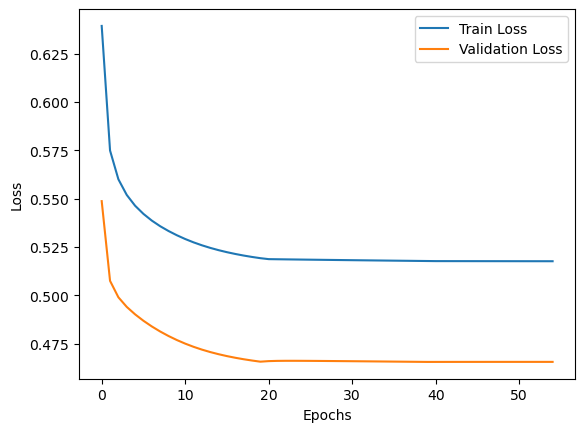

150/150 [==============================] - 0s 1ms/step
------------------------------------------------------------------------
Training for fold 2
Epoch 1/55
562/562 [==============================] - 4s 4ms/step - loss: 0.6449 - accuracy: 0.6371 - val_loss: 0.5386 - val_accuracy: 0.7865 - lr: 1.0000e-04
Epoch 2/55
562/562 [==============================] - 2s 3ms/step - loss: 0.5812 - accuracy: 0.7194 - val_loss: 0.5045 - val_accuracy: 0.7958 - lr: 1.0000e-04
Epoch 3/55
562/562 [==============================] - 2s 3ms/step - loss: 0.5685 - accuracy: 0.7244 - val_loss: 0.4935 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 4/55
562/562 [==============================] - 2s 3ms/step - loss: 0.5596 - accuracy: 0.7282 - val_loss: 0.4861 - val_accuracy: 0.8031 - lr: 1.0000e-04
Epoch 5/55
562/562 [==============================] - 2s 3ms/step - loss: 0.5536 - accuracy: 0.7309 - val_loss: 0.4811 - val_accuracy: 0.8054 - lr: 1.0000e-04
Epoch 6/55
562/562 [==============================] - 2s 

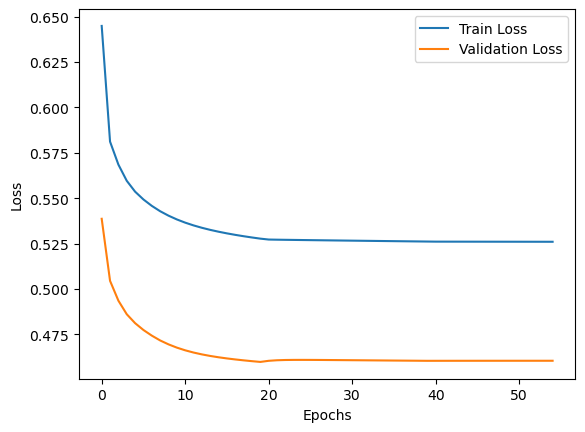

150/150 [==============================] - 1s 2ms/step
------------------------------------------------------------------------
Training for fold 3
Epoch 1/55
560/560 [==============================] - 4s 4ms/step - loss: 0.6810 - accuracy: 0.5624 - val_loss: 0.5917 - val_accuracy: 0.7992 - lr: 1.0000e-04
Epoch 2/55
560/560 [==============================] - 2s 3ms/step - loss: 0.5914 - accuracy: 0.7172 - val_loss: 0.5025 - val_accuracy: 0.8025 - lr: 1.0000e-04
Epoch 3/55
560/560 [==============================] - 2s 3ms/step - loss: 0.5670 - accuracy: 0.7245 - val_loss: 0.4899 - val_accuracy: 0.8040 - lr: 1.0000e-04
Epoch 4/55
560/560 [==============================] - 2s 4ms/step - loss: 0.5574 - accuracy: 0.7292 - val_loss: 0.4848 - val_accuracy: 0.8046 - lr: 1.0000e-04
Epoch 5/55
560/560 [==============================] - 2s 3ms/step - loss: 0.5516 - accuracy: 0.7334 - val_loss: 0.4814 - val_accuracy: 0.8044 - lr: 1.0000e-04
Epoch 6/55
560/560 [==============================] - 2s 

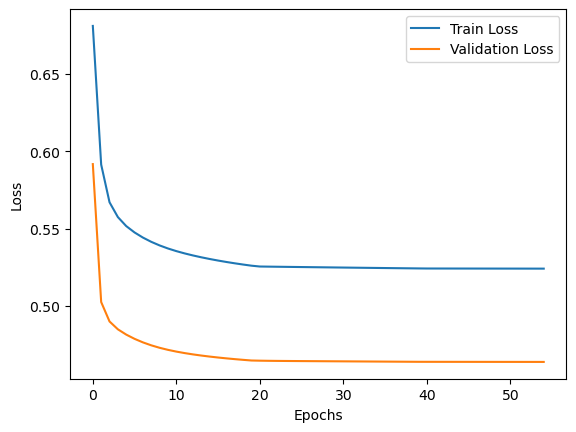

150/150 [==============================] - 1s 1ms/step
------------------------------------------------------------------------
Training for fold 4
Epoch 1/55
560/560 [==============================] - 4s 4ms/step - loss: 0.6217 - accuracy: 0.7170 - val_loss: 0.5406 - val_accuracy: 0.7873 - lr: 1.0000e-04
Epoch 2/55
560/560 [==============================] - 2s 3ms/step - loss: 0.5731 - accuracy: 0.7299 - val_loss: 0.5038 - val_accuracy: 0.7952 - lr: 1.0000e-04
Epoch 3/55
560/560 [==============================] - 2s 4ms/step - loss: 0.5599 - accuracy: 0.7335 - val_loss: 0.4930 - val_accuracy: 0.7994 - lr: 1.0000e-04
Epoch 4/55
560/560 [==============================] - 2s 4ms/step - loss: 0.5516 - accuracy: 0.7359 - val_loss: 0.4866 - val_accuracy: 0.8006 - lr: 1.0000e-04
Epoch 5/55
560/560 [==============================] - 2s 4ms/step - loss: 0.5458 - accuracy: 0.7390 - val_loss: 0.4826 - val_accuracy: 0.8015 - lr: 1.0000e-04
Epoch 6/55
560/560 [==============================] - 2s 

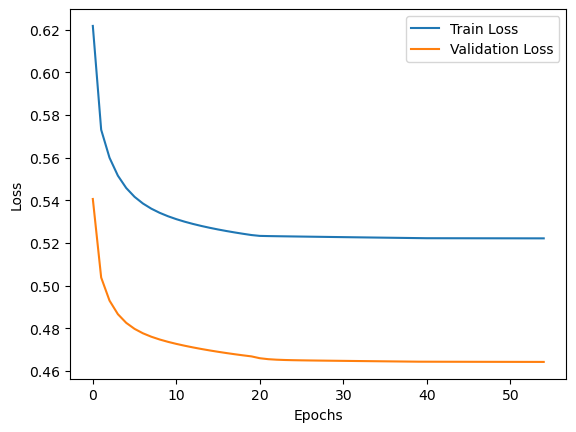

150/150 [==============================] - 1s 1ms/step
------------------------------------------------------------------------
Training for fold 5
Epoch 1/55
563/563 [==============================] - 4s 5ms/step - loss: 0.6432 - accuracy: 0.6774 - val_loss: 0.5532 - val_accuracy: 0.7837 - lr: 1.0000e-04
Epoch 2/55
563/563 [==============================] - 2s 4ms/step - loss: 0.5769 - accuracy: 0.7255 - val_loss: 0.5108 - val_accuracy: 0.7875 - lr: 1.0000e-04
Epoch 3/55
563/563 [==============================] - 2s 4ms/step - loss: 0.5633 - accuracy: 0.7308 - val_loss: 0.4996 - val_accuracy: 0.7923 - lr: 1.0000e-04
Epoch 4/55
563/563 [==============================] - 2s 4ms/step - loss: 0.5535 - accuracy: 0.7348 - val_loss: 0.4916 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 5/55
563/563 [==============================] - 2s 4ms/step - loss: 0.5463 - accuracy: 0.7384 - val_loss: 0.4863 - val_accuracy: 0.7944 - lr: 1.0000e-04
Epoch 6/55
563/563 [==============================] - 2s 

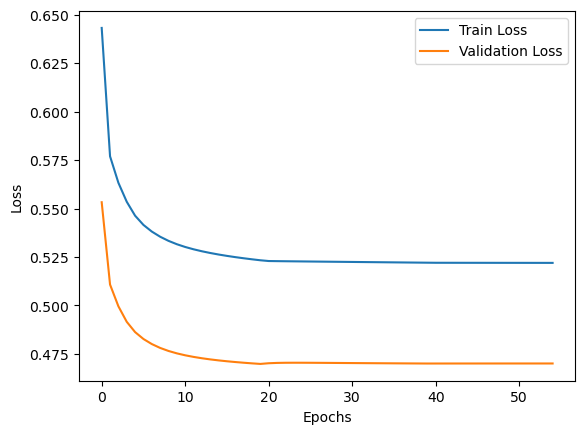

150/150 [==============================] - 0s 1ms/step
Accuracy: 0.807 (+/- 0.003)
Precision: 0.578 (+/- 0.015)
Recall: 0.469 (+/- 0.015)
F1 score: 0.518 (+/- 0.012)
AUC score: 0.686 (+/- 0.007)


In [47]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
AUC_scores = []

fold_no = 1
for train_index, test_index in kf.split(X_train, y_train):
    X_train_dl, X_test_dl = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train_dl, y_test_dl = y_train.iloc[train_index], y_train.iloc[test_index]

    # Perform preprocessing steps on X_train_dl
    X_train_dl_preprocessed = enc_dl.fit_transform(X_train_dl)
    X_test_dl_preprocessed = enc_dl.transform(X_test_dl)

    # Apply SMOTE and undersampling to address class imbalance
    over = SMOTE(sampling_strategy=0.4, random_state=42)
    under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
    steps = [('o',over),('u',under)]
    pipe = Pipeline(steps=steps)
        
    X_train_dl_resampled, y_train_dl_resampled =  pipe.fit_resample(X_train_dl_preprocessed, y_train_dl)
    
    round_cols = ['SEX','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6'] + X_train_dl_resampled.filter(like='EDUCATION').columns.to_list() + X_train_dl_resampled.filter(like='MARRIAGE').columns.to_list() 
    for col in round_cols:
        X_train_dl_resampled[col] = X_train_dl_resampled[col].round()
        
    y_train_dl_resampled = pd.Series(y_train_dl_resampled,name='DEFAULT')
    concat = pd.concat([X_train_dl_resampled,y_train_dl_resampled],axis=1)
    non_default = concat[concat['DEFAULT']==0].drop('DEFAULT',axis=1)
    default = concat[concat['DEFAULT']==1].drop('DEFAULT',axis=1)
    
    null_columns = ['LIMIT_BAL','AGE','BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6']
    
    augmented_default = augment_data_with_knn(default, null_columns)
    augmented_non_default = augment_data_with_knn(non_default, null_columns)
    augmented_non_default['DEFAULT'] = 0
    augmented_default['DEFAULT'] = 1
    augmented_data = pd.concat([augmented_default,augmented_non_default],axis=0)
    augmented_data = augmented_data.sample(frac=1, random_state=42)
    
    X_train_dl_augmented = augmented_data.drop('DEFAULT',axis=1)
    y_train_dl_augmented = augmented_data['DEFAULT']
    
    #scale = RobustScaler()
    #X_train_dl_augmented_scaled = X_train_dl_augmented.copy()
    #X_train_dl_augmented_scaled = scale.fit_transform(X_train_dl_augmented)
    #X_train_dl_augmented_scaled = pd.DataFrame(X_train_dl_augmented_scaled, columns =X_train_dl_augmented.columns)
   
    
    # Split training data into static and temporal features
    # Perform any necessary reshaping or transformations
    temp_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
    'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
    'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
    'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    static_cols_train = X_train_dl_augmented.drop(temp_cols,axis=1).columns.to_list()
    static_cols_test = X_test_dl_preprocessed.drop(temp_cols,axis=1).columns.to_list()
    
    X_train_dl_temp = X_train_dl_augmented[temp_cols]
    X_train_dl_static = X_train_dl_augmented[static_cols_train]
    X_test_dl_temp = X_test_dl_preprocessed[temp_cols]
    X_test_dl_static = X_test_dl_preprocessed[static_cols_test]

    PAY_cols = ['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2','PAY_1']
    BILL_AMT_cols = ['BILL_AMT6','BILL_AMT5','BILL_AMT4','BILL_AMT3','BILL_AMT2','BILL_AMT1']
    PAY_AMT_cols = ['PAY_AMT6','PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
    
    PAY_train_dl = X_train_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_train_dl = X_train_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_train_dl = X_train_dl_temp[PAY_AMT_cols].to_numpy()
    
    PAY_test_dl = X_test_dl_temp[PAY_cols].to_numpy()
    BILL_AMT_test_dl = X_test_dl_temp[BILL_AMT_cols].to_numpy()
    PAY_AMT_test_dl = X_test_dl_temp[PAY_AMT_cols].to_numpy()   
    
    # Stack temporal features
    stacked_train = np.dstack((PAY_train_dl,BILL_AMT_train_dl,PAY_AMT_train_dl))
    stacked_test = np.dstack((PAY_test_dl,BILL_AMT_test_dl,PAY_AMT_test_dl))
    y_train_dl_augmented = y_train_dl_augmented.to_numpy()
    y_test_dl = y_test_dl.to_numpy()

    # Build and compile LSTM model
    num_time_steps, num_features = stacked_train.shape[1], stacked_train.shape[2]

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(16,return_sequences=True, input_shape=(num_time_steps, num_features)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    initial_learning_rate = 0.0001  # Initial learning rate
    decay_rate = 0.1  # Decay rate
    decay_steps = 20  # Decay steps (number of steps before applying decay)
    epochs = 55

    def learning_rate_scheduler(epoch):
        return initial_learning_rate * decay_rate ** (epoch // decay_steps)
    
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=initial_learning_rate), metrics=['accuracy'])
    
    lr_scheduler = LearningRateScheduler(learning_rate_scheduler)
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no}')
 
    # Train the model
    batch_size = 64
    
    # Train the model
    history = model.fit(stacked_train, y_train_dl_augmented, epochs=epochs, batch_size=batch_size, validation_data=(stacked_test, y_test_dl),shuffle=False,callbacks=[lr_scheduler])
    
    # Plot the loss on train vs validate tests
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    y_pred_probs = model.predict(stacked_test)
    y_pred = (y_pred_probs>=0.5).astype(int)    
    
    accuracy =  accuracy_score(y_test_dl,y_pred)
    precision = precision_score(y_test_dl,y_pred)
    recall = recall_score(y_test_dl,y_pred)
    f1 =  f1_score(y_test_dl,y_pred)
    AUC = roc_auc_score(y_test_dl,y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    AUC_scores.append(AUC)
    
    fold_no = fold_no + 1


# Calculate the average and standard deviation of the evaluation metrics
print('Accuracy: %.3f (+/- %.3f)' % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print('Precision: %.3f (+/- %.3f)' % (np.mean(precision_scores), np.std(precision_scores)))
print('Recall: %.3f (+/- %.3f)' % (np.mean(recall_scores), np.std(recall_scores)))
print('F1 score: %.3f (+/- %.3f)' % (np.mean(f1_scores), np.std(f1_scores)))
print('AUC score: %.3f (+/- %.3f)' % (np.mean(AUC_scores), np.std(AUC_scores)))


* Accuracy: 0.806 (+/- 0.004)
* Precision: 0.581 (+/- 0.012)
* Recall: 0.450 (+/- 0.011)
* F1 score: 0.507 (+/- 0.006)
* AUC score: 0.679 (+/- 0.004)

In [369]:
import tensorflow as tf

from keras.layers import Lambda
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model
from keras.losses import mse
from keras import backend as K

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

# Visual Libraries
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

class VAE_oversampling:
    def __init__(self, epochs=10, hidden_dim=10,
                 batch_size=1, latent_dim=2, original_dim=30,
                 minority_class_id=1, 
                 random_state=0, num_samples_to_generate=100,
                 optimizer = "adam"):
        self.epochs = epochs
        self.batch_size = batch_size
        self.original_dim = original_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.minority_class_id = minority_class_id
        self.random_state = random_state
        self.num_samples_to_generate = num_samples_to_generate
        self.optimizer = optimizer

        #set random seed
        np.random.seed(random_state)

    #Reparameterization function
    def sampling(self, args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 2))
        return z_mean + K.exp(0.5*z_log_var) * epsilon
    
    def display_vae_training_history(self, history):        
        plt.figure(figsize=(6,3))
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val loss')
        plt.ylabel('MSE + KLD')
        plt.xlabel('No. epoch')
        plt.legend(loc="upper left") 
        plt.title("Autoencoder Training History")
        plt.show()
        
    def build_train_vae(self, X_train_AE):
        # Mapping inputs to latent distribution parameters
        inputs = Input(shape=(self.original_dim,))
        h = Dense(self.hidden_dim, activation='relu')(inputs)

        #Latent space layer
        z_mean = Dense(self.latent_dim)(h)
        z_log_sigma = Dense(self.latent_dim)(h)

        z = Lambda(self.sampling, output_shape=(self.latent_dim,))([z_mean, z_log_sigma])

        #Mapping these sampled latent points back to reconstructed inputs
        # Create encoder
        encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

        # Create decoder
        latent_inputs = Input(shape=(self.latent_dim,), name='z_sampling')
        x = Dense(self.hidden_dim, activation='relu')(latent_inputs)
        outputs = Dense(self.original_dim, activation='sigmoid')(x)
        decoder = Model(latent_inputs, outputs, name='decoder')

        # instantiate VAE model
        outputs = decoder(encoder(inputs)[2])
        vae = Model(inputs, outputs, name='vae_mlp')

        #Caclulate reconstruction from input and output
        reconstruction_loss = mse(inputs, outputs)
        reconstruction_loss *= self.original_dim
            
        #Kullback-liebler divergence loss
        kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        
        #The total vae loss
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        vae.add_loss(vae_loss)

        vae.compile(optimizer=self.optimizer)

        history = vae.fit(X_train_AE, X_train_AE, self.batch_size, self.epochs, validation_split=0.1)

        self.display_vae_training_history(history)

        self.encoder = encoder
        self.decoder = decoder

        return vae
    
    def fit_sample(self, Xtrain, ytrain):
        #Number of samples to generate
        num_samples_to_generate = self.num_samples_to_generate
        
        #Scale the data set
        
        Xtrain_1 = Xtrain[ytrain == self.minority_class_id]
        X_train_AE_scaled = enc_dl.fit_transform(Xtrain_1[:])

        #Pass data set to the build function
        self.build_train_vae(X_train_AE_scaled)
        
        #randomly sample from standard normal
        z_latent_sample = np.random.normal(0, 1,
                                    (num_samples_to_generate,
                                     self.latent_dim))
        
        #Generate the synthetic samples by passing the z sample
        synthetic_samples = self.decoder.predict(z_latent_sample)
            
        synthetic_X = ss.inverse_transform(synthetic_samples)
        synthetic_y = np.ones(num_samples_to_generate)\
            * self.minority_class_id
        
        #Final step, concetenate original observations with synthetic observations
        X_new = np.concatenate((Xtrain, synthetic_X))
        y_new = np.concatenate((ytrain, synthetic_y))
        return(X_new, y_new)

In [344]:
std = StandardScaler()

p_std = std.fit_transform(p) 




In [379]:
y_sub

6699     0
23576    0
7773     0
15511    0
20152    0
        ..
14825    1
17798    1
10717    0
8867     1
13077    1
Name: DEFAULT, Length: 300, dtype: int64

In [376]:
 vos = VAE_oversampling(hidden_dim= 64,
                                latent_dim=2,
                                original_dim=p_sub.shape[1],
                                minority_class_id=1,
                                epochs=100,
                                batch_size=1,
                                num_samples_to_generate = 100,
                                random_state = 0,
                                optimizer="adam")

    


p_new,y_new = vos.fit_sample(p_sub,y_sub)

Epoch 1/100


ValueError: in user code:

    File "c:\Users\diama\anaconda3\envs\spyder\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\diama\anaconda3\envs\spyder\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\diama\anaconda3\envs\spyder\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\diama\anaconda3\envs\spyder\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\diama\anaconda3\envs\spyder\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\diama\anaconda3\envs\spyder\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "vae_mlp" is incompatible with the layer: expected shape=(None, 23), found shape=(1, 25)


In [349]:
X_res_val = pd.DataFrame(X_res_val)

In [351]:
p_std

array([[-0.82752799, -1.23711731,  0.21028223, ..., -0.31794608,
        -0.31648605, -0.29462289],
       [ 0.86949082,  0.80833078, -1.13162756, ..., -0.31794608,
        -0.29330356, -0.27785986],
       [-0.67325355,  0.80833078,  1.55219203, ..., -0.31794608,
        -0.31648605, -0.29462289],
       ...,
       [-0.4418419 ,  0.80833078,  0.21028223, ...,  0.01517391,
        -0.18249128, -0.24913131],
       [ 1.48658857, -1.23711731, -1.13162756, ..., -0.31794608,
        -0.31648605, -0.29462289],
       [ 1.02376526, -1.23711731, -1.13162756, ..., -0.31794608,
        -0.31648605, -0.29462289]])

In [350]:
X_res_val

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,-0.827528,-1.237117,0.210282,0.846309,0.822714,0.902546,-1.557234,-0.696624,-0.669022,-1.533004,...,-0.667331,-0.674045,-0.663933,-0.653313,-0.347288,-0.229635,-0.295341,-0.317946,-0.316486,-0.294623
1,0.869491,0.808331,-1.131628,-1.071793,0.387132,-1.767027,-1.557234,-1.533763,-1.526172,-1.533004,...,-0.676625,-0.674045,-0.663933,-0.647428,-0.347288,-0.258438,-0.295341,-0.317946,-0.293304,-0.277860
2,-0.673254,0.808331,1.552192,-1.071793,0.931610,-0.877169,-0.723828,-0.696624,-1.526172,-1.533004,...,-0.678588,-0.674045,-0.663933,-0.653313,0.014184,-0.264520,-0.295341,-0.317946,-0.316486,-0.294623
3,0.252393,-1.237117,0.210282,-1.071793,0.060445,-0.877169,-0.723828,-0.696624,-0.669022,-0.649843,...,-0.668529,-0.674045,-0.618350,-0.630075,-0.117722,-0.233347,-0.295341,-0.133464,-0.221239,-0.158543
4,0.715216,0.808331,0.210282,-1.071793,1.040505,0.012689,0.109577,0.140515,0.188129,0.233318,...,2.117070,1.869138,1.640633,1.586405,0.613893,0.182955,0.098794,0.048486,0.014692,-0.068858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27095,-0.273590,-0.037141,0.109725,-0.050111,0.300218,0.612583,0.495579,0.442738,0.410023,0.385934,...,-0.033765,-0.024872,-0.017686,-0.015019,-0.136214,-0.114653,-0.103628,-0.105051,-0.099993,-0.098126
27096,-0.206921,-0.052499,0.102712,-0.050111,0.136079,0.612583,0.495579,0.442738,0.410023,0.385934,...,0.279764,0.138969,0.093883,0.110645,-0.007669,-0.064091,-0.045097,0.059049,0.056001,-0.042525
27097,-0.297759,-0.058142,0.100384,0.211697,0.025733,0.612583,0.495579,0.442738,0.410023,0.385934,...,-0.033765,-0.024872,-0.017686,-0.015019,-0.136220,-0.114656,-0.103639,-0.105078,-0.100011,-0.098132
27098,-0.294440,-0.041041,0.243715,-0.050111,0.197438,0.612583,0.495579,0.442738,0.410023,0.385934,...,-0.033765,-0.024872,-0.017686,-0.015019,-0.136216,-0.114654,-0.103634,-0.105067,-0.100005,-0.098130
